# Datasets for Other Proteins

This notebook formats data for the additional protein data used. It is used for part 2 of the project.

In [1]:
# import statements
import os
import numpy as np
import pandas as pd
import requests
from Bio import SeqIO
from io import StringIO
import Bio.PDB.Polypeptide
import re
from scipy.stats import kurtosis

In [2]:
import secStrucFormatting as ssf

In [5]:
# setting jupyter notebook viewing options
max_rows = 1000
max_cols = 1000
pd.set_option("display.max_rows", max_rows, "display.max_columns", max_cols)

In [6]:
# Parameters:
# - orig_df: original dataframe with all mutations and "positions_split" column which has mutation positions in split list
#            as ints
# - sec_st_df: new dataframe with all rows that have mutations in the secondary structure of protein
# - mixed_df: new dataframe with all rows that have mutations in both in and out of the secondary stucture of the protein
# - start: (inclusive) index where the domain of the protein in PDB file starts
# - end: (inclusive) index where the domain of the protein in PDB file ends
def get_ss_dataset(orig_df, bool_ss_list, domain_start_index):
    
    has_sec_str = []
    
    for val in orig_df["positions_split"]:
        # list of boolean values that are true if all mutation positions in line are sec. strc.
        all_pos_sec_struc = []
        
        for position in val:
            if (bool_ss_list[position - domain_start_index] == False): # line up ss_indexes w/ position
                all_pos_sec_struc.append(False)
            else:
                all_pos_sec_struc.append(True)
        
        if (all_pos_sec_struc.count(False) == 0):
            has_only_sec_str = True
        else:
            has_only_sec_str = False
        
        has_sec_str.append(has_only_sec_str)
        all_pos_sec_struc.clear()
        
    orig_df['has_sec_str'] = has_sec_str
    print(orig_df)
    condition = orig_df['has_sec_str'] == True
    rows = orig_df.loc[condition, :]
    
    sec_str_df = pd.DataFrame(columns=orig_df.columns)
    sec_str_df = sec_str_df.append(rows, ignore_index=True)
    sec_str_df = sec_str_df.drop(['has_sec_str'], axis=1)
    orig_df = orig_df.drop(['has_sec_str'], axis=1)
    
    return sec_str_df

In [7]:
def get_not_ss_dataset(orig_df, bool_ss_list, domain_start_index):
    is_not_sec_str = []
    
    for val in orig_df["positions_split"]:
        
        all_pos_sec_struc = []
        
        for position in val:
            # print(position - domain_start_index)
            # print(str(position) + " " + str(domain_start_index))
            if (bool_ss_list[position - domain_start_index] == False):
                all_pos_sec_struc.append(False)
            else:
                all_pos_sec_struc.append(True)
    
        
        if (all_pos_sec_struc.count(True) == 0):
            has_no_sec_str = True
        else:
            has_no_sec_str = False
        
        is_not_sec_str.append(has_no_sec_str)
        all_pos_sec_struc.clear()
        
    orig_df['is_not_sec_str'] = is_not_sec_str
     
    condition = orig_df['is_not_sec_str'] == True
    rows = orig_df.loc[condition, :]
    
    not_sec_str_df = pd.DataFrame(columns=orig_df.columns)
    not_sec_str_df = not_sec_str_df.append(rows, ignore_index=True)
    not_sec_str_df = not_sec_str_df.drop(['is_not_sec_str'], axis=1)
    orig_df = orig_df.drop(['is_not_sec_str'], axis=1)
    
    return not_sec_str_df

### Metadata from compiled dataset

In [7]:
path = "../Raw Data/" + 'all_data_clean.csv'
df = pd.read_csv(path)
# print(df.head)
print(df.columns)

print(df["PROTEIN"].value_counts().head(10))
print(df.loc[df['PROTEIN'] == 'Lysozyme'])

Index(['DATABASE', 'PROTEIN', 'UNIPROT_ID', 'MUTATION', 'SOURCE', 'PBD_WILD',
       'PBD_CHAIN_MUTATION', 'pH', 'T_(C)', 'Tm_(C)', 'dTm_(C)',
       'dH_(kcal/mol)', 'dG_(kcal/mol)', 'ddG_(kcal/mol)',
       'ddG_H2O_(kcal/mol)', 'STATE', 'REVERSIBILITY', 'PUBMED_ID',
       'REFERENCE', 'MUTATED_CHAIN', 'KINGDOM', 'PBD_MUTANT', 'MEASURE',
       'METHOD', 'POSITION', 'WILD_TYPE_RES', 'MUTATED_RES', 'IS_CURATED',
       'CONSERVATION', 'NOTES', 'DATASETS'],
      dtype='object')
Lysozyme                                                   2897
Immunoglobulin G-binding protein G                         1996
Thermonuclease                                             1586
Staphylococcal nuclease                                    1457
Endolysin                                                  1110
Ribonuclease                                                983
Ribonuclease HI                                             710
Guanine nucleotide-binding protein G(i) subunit alpha-1     704
Myo

In [12]:
print(df["UNIPROT_ID"].value_counts().head(10)) # 4 possible could be used?

P00644    3033
P00720    2767
P06654    2297
P61626    1146
P00648     981
P00651     904
P0A7Y4     722
P63096     698
P00044     546
P00698     491
Name: UNIPROT_ID, dtype: int64


#### P00644 (Thermonuclease)

In [29]:
# finding column with most values
# print(nuclease_df)
# print(df.loc[df['UNIPROT_ID'] == 'P00644'])
nuclease_df = df.loc[df['UNIPROT_ID'] == 'P00644']
print(nuclease_df.head(50))
nuclease_df = nuclease_df.loc[nuclease_df['PROTEIN'].str.contains('Thiol:disulfide interchange protein DsbA') == False]
# print(nuclease_df.columns)
nuclease_df = nuclease_df[nuclease_df['ddG_(kcal/mol)'].notna()]
nuclease_df = nuclease_df[nuclease_df['MUTATION'].str.contains('wild-type') == False]
print(nuclease_df['ddG_(kcal/mol)'].tail(40))

# rename ddG to score and mutation to variant
nuclease_df = nuclease_df.rename(columns={'MUTATION': 'variant', 'ddG_(kcal/mol)': 'score'})
print(nuclease_df['score'])
nuclease_df['score'] = nuclease_df['score'].round(6)
# print(nuclease_df['variant'].head(30))

nuclease_df["positions_split"] = ssf.get_positions_split(nuclease_df)

positions_split_subtracted = []
for pos_list in nuclease_df["positions_split"]:
    pos_list = [x - 1 for x in pos_list]
    positions_split_subtracted.append(pos_list)  

nuclease_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in nuclease_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    # print(pos_string)
    new_positions.append(pos_string)
    pos_string = ""
# print(len(new_positions))
# print(len(nuclease_df["POSITION"]))

nuclease_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

NameError: name 'df' is not defined

In [131]:
print(nuclease_df['score'])


10556    -2.6
10557     0.8
10558    -1.3
10559     0.5
10560    -2.5
         ... 
29815     7.2
29816     7.3
29817     9.3
29818    11.3
37335     0.7
Name: score, Length: 1280, dtype: float64


In [132]:
# get protein from uniprot
protein_seq_nuclease = ssf.get_protein_seq('P00644')
print(protein_seq_nuclease)

MET LEU VAL MET THR GLU TYR LEU LEU SER ALA GLY ILE CYS MET ALA ILE VAL SER ILE LEU LEU ILE GLY MET ALA ILE SER ASN VAL SER LYS GLY GLN TYR ALA LYS ARG PHE PHE PHE PHE ALA THR SER CYS LEU VAL LEU THR LEU VAL VAL VAL SER SER LEU SER SER SER ALA ASN ALA SER GLN THR ASP ASN GLY VAL ASN ARG SER GLY SER GLU ASP PRO THR VAL TYR SER ALA THR SER THR LYS LYS LEU HIS LYS GLU PRO ALA THR LEU ILE LYS ALA ILE ASP GLY ASP THR VAL LYS LEU MET TYR LYS GLY GLN PRO MET THR PHE ARG LEU LEU LEU VAL ASP THR PRO GLU THR LYS HIS PRO LYS LYS GLY VAL GLU LYS TYR GLY PRO GLU ALA SER ALA PHE THR LYS LYS MET VAL GLU ASN ALA LYS LYS ILE GLU VAL GLU PHE ASP LYS GLY GLN ARG THR ASP LYS TYR GLY ARG GLY LEU ALA TYR ILE TYR ALA ASP GLY LYS MET VAL ASN GLU ALA LEU VAL ARG GLN GLY LEU ALA LYS VAL ALA TYR VAL TYR LYS PRO ASN ASN THR HIS GLU GLN HIS LEU ARG LYS SER GLU ALA GLN ALA LYS LYS GLU LYS LEU ASN ILE TRP SER GLU ASP ASN ALA ASP SER GLY GLN


In [133]:
protein_seq_nuclease_split = protein_seq_nuclease.split()
print(protein_seq_nuclease_split[221:224])
print(len(protein_seq_nuclease_split))

['TRP', 'SER', 'GLU']
231


In [134]:
nuclease_df["variant"] = ssf.get_mutations_names_list(nuclease_df)
# print(nuclease_df.head(10))

In [139]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'thermonuclease_stride.txt'
nuclease_stride_file = open(path, 'r')

In [140]:
nuclease_ss_indexes = ssf.get_all_sec_struc_boolean(nuclease_stride_file) # boolean list of secondary structure assignements from uniprot
print(nuclease_ss_indexes.count(True))
print(nuclease_ss_indexes.count(False))

193
38


In [141]:
nuclease_df = add_sec_str_col(nuclease_df, nuclease_ss_indexes, 0)

In [138]:
nuclease_df = ssf.get_domain_dataset(nuclease_df, 0, 231, [])

C:\Users\deepti\OneDrive\UW\GitHub\secondary-structure-CNN-learning\Jupyter Notebooks\secStrucFormatting.py:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  in_domain_df = in_domain_df.append(rows, ignore_index=True)


In [139]:
print(len(nuclease_df))

1280


In [142]:
# print(nuclease_df.head(5))
print(len(nuclease_df))
nuclease_df = nuclease_df[nuclease_df['score'] != 0.0]
print(len(nuclease_df))

1258
1258


In [146]:
nuclease_train_df, nuclease_test_df, nuclease_remaining_df = get_train_and_test_df(nuclease_df, 0.62, 453)
nuclease_df_format = pd.concat([nuclease_train_df, nuclease_test_df])
print(len(nuclease_df_format))
ssf.write_data_file("nuclease_MLformat_453_train_539_test_t3", protein_seq_nuclease, nuclease_df_format)

in fraction,df len1258
280
173
Train Data Fraction: 0.618
false_df len379
true_df len879
in fraction,df len805
Test Data Fraction: 0.62
false_df len206
true_df len599
Size of Test Dataset: 539
Size of Total Dataset: 992
992
Filename: nuclease_MLformat_453_train_539_test_t3.txt


In [74]:
ss = nuclease_ss_indexes.count(True)
not_ss = nuclease_ss_indexes.count(False)
print(ss)
print(not_ss)

144
87


#### P00720 (Endolysin)

In [24]:
endolysin_df = df.loc[df['UNIPROT_ID'] == 'P00720']
# endolysin_df = protein_G_df["PROTEIN"].value_counts()
print(len(endolysin_df))
endolysin_df.count()
print(endolysin_df["PROTEIN"].value_counts())

2767
Lysozyme                                     1637
Endolysin                                    1101
T4 lysozyme                                    20
N,O-diacetylmuramidase                          2
Beta-galactosidase                              2
Invertase 2                                     1
Spanin, inner membrane subunit                  1
Cytosol aminopeptidase                          1
Thermophilic aminopeptidase 1 alpha chain       1
Carboxypeptidase Y                              1
Name: PROTEIN, dtype: int64


In [43]:
lys_df = df.loc[df['PROTEIN'].str.contains('Lysozyme') == True]
print(lys_df["PROTEIN"].value_counts())
print(lys_df['MUTATION'].head(50))

Lysozyme                    2897
Lysozyme C                   449
Lysozyme C, milk isozyme      14
Name: PROTEIN, dtype: int64
57       wild-type
97       wild-type
98            L46A
99           L118A
100          L121A
101           L99A
102          L133A
103          F153A
104     L99A F153A
105      wild-type
106           E25Q
107           D36N
108           D67N
109           D85N
110          D120N
111          D138N
112      wild-type
113           E25Q
114           D36N
115           D67N
116           D85N
117          D120N
118          D138N
119      wild-type
120           E25Q
121           D85N
122          D120N
123          D138N
124      wild-type
125           E25Q
126           D85N
127          D120N
128          D138N
129      wild-type
130      wild-type
131           G67A
132           G85A
133           G89A
134          G120A
135          G135A
136      wild-type
137           K16E
138          R119E
139          K135E
140          K147E
141          R154E

In [44]:
endo_df = df.loc[df['PROTEIN'].str.contains('Endolysin') == True]
print(print(endo_df["PROTEIN"].value_counts()))
# print(endo_df['MUTATION'].head(50))

Endolysin    1110
Name: PROTEIN, dtype: int64
None


In [11]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'endolysin_stride.txt'
endolysin_stride_file = open(path, 'r')

In [29]:
# getting protein string
protein_seq_endolysin = ssf.get_protein_seq('P00720')
print(protein_seq_endolysin)

MET ASN ILE PHE GLU MET LEU ARG ILE ASP GLU ARG LEU ARG LEU LYS ILE TYR LYS ASP THR GLU GLY TYR TYR THR ILE GLY ILE GLY HIS LEU LEU THR LYS SER PRO SER LEU ASN ALA ALA LYS SER GLU LEU ASP LYS ALA ILE GLY ARG ASN CYS ASN GLY VAL ILE THR LYS ASP GLU ALA GLU LYS LEU PHE ASN GLN ASP VAL ASP ALA ALA VAL ARG GLY ILE LEU ARG ASN ALA LYS LEU LYS PRO VAL TYR ASP SER LEU ASP ALA VAL ARG ARG CYS ALA LEU ILE ASN MET VAL PHE GLN MET GLY GLU THR GLY VAL ALA GLY PHE THR ASN SER LEU ARG MET LEU GLN GLN LYS ARG TRP ASP GLU ALA ALA VAL ASN LEU ALA LYS SER ILE TRP TYR ASN GLN THR PRO ASN ARG ALA LYS ARG VAL ILE THR THR PHE ARG THR GLY THR TRP ASP ALA TYR LYS ASN LEU


In [55]:
protein_seq_endolysin_split = protein_seq_endolysin.split()
print(len(protein_seq_endolysin_split))

164


In [12]:
endolysin_ss_indexes = ssf.get_sec_struc_boolean(endolysin_stride_file) # boolean list of secondary structure assignements

In [13]:
ss = endolysin_ss_indexes.count(True)
not_ss = endolysin_ss_indexes.count(False)
print(ss)
print(not_ss)

122
41


#### P06654 (Immunoglobulin G-binding protein G)

In [106]:
protein_G_df = df.loc[df['UNIPROT_ID'] == 'P06654']
print(protein_G_df["PROTEIN"].value_counts())
protein_G_df = protein_G_df.loc[protein_G_df['PROTEIN'].str.contains('Single Domain Antibody') == False]
protein_G_df = protein_G_df[protein_G_df["POSITION"].str.contains("pga_A") == False]

protein_G_df = protein_G_df[protein_G_df["ddG_(kcal/mol)"].notna()]
print(len(protein_G_df))

protein_G_df = protein_G_df.rename(columns={'MUTATION': 'variant', 'ddG_(kcal/mol)': 'score'})
protein_G_df['score'] = protein_G_df['score'].round(6)
# print(protein_G_df['variant'].head(30))

protein_G_df["positions_split"] = ssf.get_positions_split(protein_G_df)

positions_split_subtracted = []
for pos_list in protein_G_df["positions_split"]:
    pos_list = [x - 1 for x in pos_list]
    positions_split_subtracted.append(pos_list)  

protein_G_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in protein_G_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    # print(pos_string)
    new_positions.append(pos_string)
    pos_string = ""
# print(len(new_positions))
# print(len(protein_G_df["POSITION"]))

protein_G_df["POSITION"] = new_positions
# print(protein_G_df["variant"].head(10))
# print(protein_G_df["POSITION"].head(10))

Immunoglobulin G-binding protein G    1995
Protein G                              285
Single Domain Antibody                  17
Name: PROTEIN, dtype: int64
1221


In [107]:
protein_G_df["variant"] = ssf.get_mutations_names_list(protein_G_df)
print(protein_G_df["variant"].head(10))
protein_G_df = add_sec_str_col(protein_G_df, protein_G_ss_indexes, 0)

9330            231ARG, 278GLU, 269ALA
9331            231ARG, 278ALA, 269ARG
9332            231ARG, 278ALA, 269ALA
9333                    278GLU, 269ARG
9334                    278GLU, 269ALA
9335                    278ALA, 269ARG
9336                    278ALA, 269ALA
9483    241ILE, 243ILE, 250GLU, 254PHE
9484    241ILE, 243ILE, 250GLU, 254TYR
9485            241ILE, 243ILE, 254TRP
Name: variant, dtype: object


In [101]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'protein_G_stride.txt'
protein_G_stride_file = open(path, 'r')

In [102]:
protein_G_ss_indexes = ssf.get_sec_struc_boolean(protein_G_stride_file) # boolean list of secondary structure assignements

In [88]:
protein_seq_protein_G = ssf.get_protein_seq('P06654')
print(protein_seq_protein_G)

MET GLU LYS GLU LYS LYS VAL LYS TYR PHE LEU ARG LYS SER ALA PHE GLY LEU ALA SER VAL SER ALA ALA PHE LEU VAL GLY SER THR VAL PHE ALA VAL ASP SER PRO ILE GLU ASP THR PRO ILE ILE ARG ASN GLY GLY GLU LEU THR ASN LEU LEU GLY ASN SER GLU THR THR LEU ALA LEU ARG ASN GLU GLU SER ALA THR ALA ASP LEU THR ALA ALA ALA VAL ALA ASP THR VAL ALA ALA ALA ALA ALA GLU ASN ALA GLY ALA ALA ALA TRP GLU ALA ALA ALA ALA ALA ASP ALA LEU ALA LYS ALA LYS ALA ASP ALA LEU LYS GLU PHE ASN LYS TYR GLY VAL SER ASP TYR TYR LYS ASN LEU ILE ASN ASN ALA LYS THR VAL GLU GLY ILE LYS ASP LEU GLN ALA GLN VAL VAL GLU SER ALA LYS LYS ALA ARG ILE SER GLU ALA THR ASP GLY LEU SER ASP PHE LEU LYS SER GLN THR PRO ALA GLU ASP THR VAL LYS SER ILE GLU LEU ALA GLU ALA LYS VAL LEU ALA ASN ARG GLU LEU ASP LYS TYR GLY VAL SER ASP TYR HIS LYS ASN LEU ILE ASN ASN ALA LYS THR VAL GLU GLY VAL LYS GLU LEU ILE ASP GLU ILE LEU ALA ALA LEU PRO LYS THR ASP THR TYR LYS LEU ILE LEU ASN GLY LYS THR LEU LYS GLY GLU THR THR THR GLU ALA VAL ASP ALA ALA 

In [99]:
protein_seq_protein_G_split = protein_seq_protein_G.split()
print(protein_seq_protein_G_split[227:234])

['THR', 'TYR', 'LYS', 'LEU', 'ILE', 'LEU', 'ASN']


In [108]:
print(len(protein_G_df))

1221


In [111]:
# protein_G_train_df, protein_G_test_df, protein_G_remaining_df = get_train_and_test_df(protein_G_df, 0.53, 878)
# protein_G_df_format = pd.concat([protein_G_train_df, protein_G_test_df])
# print(len(protein_G_df_format))
# # ssf.write_data_file("protein_G_MLformat_453_train_639_test_t3", protein_seq_protein_G, protein_G_df_format)

# not enough for test and train set

From Gelman et al.

**avGFP**

In [31]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'avgfp_stride.txt'
avgfp_stride_file = open(path, 'r')

In [51]:
avgfp_ss_indexes = ssf.get_all_sec_struc_boolean(avgfp_stride_file) # boolean list of secondary structure assignements

In [33]:
ss = avgfp_ss_indexes.count(True)
not_ss = avgfp_ss_indexes.count(False)
print(ss)
print(not_ss)

209
28


Formatting Data

In [34]:
# importing avGFP data from Gelman et al.
avgfp_df1 = pd.read_csv("../Raw Data/avgfp.tsv.txt", sep="\t")
avgfp_df = avgfp_df1.dropna()
print(len(avgfp_df))
print(avgfp_df.columns)

54024
Index(['variant', 'num_mutations', 'score', 'score_wt_norm'], dtype='object')


In [35]:
# rounding score column to 2 decimal points
avgfp_df["score"] = avgfp_df["score"].round(6)
print(len(avgfp_df))

# remove values with wildcard star thing cause idk what it means
avgfp_df = avgfp_df[avgfp_df["variant"].str.contains("\*") == False]

# pab1_df = pab1_df.head(37600)
# avgfp_df = avgfp_df.sample(n=160)
print(len(avgfp_df))

54024
51714


In [36]:
# getting dataset size to run

string_seq = "SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"
print(len(string_seq)) 
protein_seq_avgfp = ssf.get_expanded_seq(string_seq)
print(protein_seq_avgfp)

237
SER LYS GLY GLU GLU LEU PHE THR GLY VAL VAL PRO ILE LEU VAL GLU LEU ASP GLY ASP VAL ASN GLY HIS LYS PHE SER VAL SER GLY GLU GLY GLU GLY ASP ALA THR TYR GLY LYS LEU THR LEU LYS PHE ILE CYS THR THR GLY LYS LEU PRO VAL PRO TRP PRO THR LEU VAL THR THR LEU SER TYR GLY VAL GLN CYS PHE SER ARG TYR PRO ASP HIS MET LYS GLN HIS ASP PHE PHE LYS SER ALA MET PRO GLU GLY TYR VAL GLN GLU ARG THR ILE PHE PHE LYS ASP ASP GLY ASN TYR LYS THR ARG ALA GLU VAL LYS PHE GLU GLY ASP THR LEU VAL ASN ARG ILE GLU LEU LYS GLY ILE ASP PHE LYS GLU ASP GLY ASN ILE LEU GLY HIS LYS LEU GLU TYR ASN TYR ASN SER HIS ASN VAL TYR ILE MET ALA ASP LYS GLN LYS ASN GLY ILE LYS VAL ASN PHE LYS ILE ARG HIS ASN ILE GLU ASP GLY SER VAL GLN LEU ALA ASP HIS TYR GLN GLN ASN THR PRO ILE GLY ASP GLY PRO VAL LEU LEU PRO ASP ASN HIS TYR LEU SER THR GLN SER ALA LEU SER LYS ASP PRO ASN GLU LYS ARG ASP HIS MET VAL LEU LEU GLU PHE VAL THR ALA ALA GLY ILE THR HIS GLY MET ASP GLU LEU TYR LYS


In [37]:
protein_seq_avgfp_split = protein_seq_avgfp.split()
print(len(protein_seq_avgfp_split))
print(protein_seq_avgfp_split[60])

# 165VAL -> ILE

237
THR


In [38]:
# splitting variant list if there are multiple mutations
avgfp_mut = avgfp_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
avgfp_df["WILD_TYPE_RES"] = ssf.get_wild_type(avgfp_mut)

# get mutated residue and place in seperate col
avgfp_df["MUTATED_RES"] = ssf.get_mutation_type(avgfp_mut)

# get position and place in seperate col
avgfp_df["POSITION"] = ssf.get_position(avgfp_mut)

# replace variant column with reformatted variant name
avgfp_df["variant"] = ssf.get_mutations_names_list(avgfp_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

# avgfp_df = avgfp_df.drop(columns=to_drop)

In [39]:

# need positionssplit
avgfp_df["positions_split"] = ssf.get_positions_split(avgfp_df)

# add in_sec_str_col
avgfp_df = add_sec_str_col(avgfp_df, avgfp_ss_indexes, 0)

In [23]:
avgfp_train_df, avgfp_test_df, avgfp_remaining_df = get_train_and_test_df(avgfp_test_df, 0.88, 465)
avgfp_df_format = pd.concat([avgfp_train_df, avgfp_test_df_2])
print(len(avgfp_df_format))
# ssf.write_data_file("avgfp_MLformat_465_train_19458_test_t3", protein_seq_avgfp, avgfp_df_format)

NameError: name 'avgfp_test_df' is not defined

In [46]:
avgfp_train_df, avgfp_test_df, avgfp_remaining_df = get_train_and_test_df(avgfp_df, 0.88, 465)
avgfp_train_dummy, avgfp_small_test_df, avgfp_remaining_df = get_train_and_test_df(avgfp_test_df, 0.88, 20000)
print("SMALL TEST")
print(len(avgfp_small_test_df))
avgfp_df_format = pd.concat([avgfp_train_df, avgfp_small_test_df])
print(len(avgfp_df_format))
ssf.write_data_file("avgfp_MLformat_465_train_15150_test_t3", protein_seq_avgfp, avgfp_df_format)

in fraction,df len51714
409
56
Train Data Fraction: 0.88
false_df len20361
true_df len31353
in fraction,df len51249
Test Data Fraction: 0.88
false_df len20305
true_df len30944
Size of Test Dataset: 35158
Size of Total Dataset: 35623
in fraction,df len35158
17600
2400
Train Data Fraction: 0.88
false_df len4219
true_df len30939
in fraction,df len15158
Test Data Fraction: 0.88
false_df len1819
true_df len13339
Size of Test Dataset: 15150
Size of Total Dataset: 35150
SMALL TEST
15150
15615
Filename: avgfp_MLformat_465_train_15150_test_t3.txt


In [103]:
avgfp_train_df_2, avgfp_test_df_2, avgfp_remaining_df_2 = get_train_and_test_df(avgfp_df, 0.64, 465)
avgfp_df_format_2 = pd.concat([avgfp_train_df_2, avgfp_test_df_2])
print(len(avgfp_df_format_2))
ssf.write_data_file("avgfp_MLformat_465_train_19458_test_t2", protein_seq_avgfp, avgfp_df_format_2)

in fraction,df len51714
297
168
Train Data Fraction: 0.639
false_df len38961
true_df len12753
in fraction,df len51249
Test Data Fraction: 0.64
false_df len38793
true_df len12456
Size of Test Dataset: 19458
Size of Total Dataset: 19923
19923
Filename: avgfp_MLformat_982_train_19458_test_t2.txt


In [104]:
avgfp_train_df_3, avgfp_test_df_3, avgfp_remaining_df_3 = get_train_and_test_df(avgfp_df, 0.64, 465)
avgfp_df_format_3 = pd.concat([avgfp_train_df_3, avgfp_test_df_3])
print(len(avgfp_df_format_3))
ssf.write_data_file("avgfp_MLformat_465_train_19458_test_t3", protein_seq_avgfp, avgfp_df_format_3)

in fraction,df len51714
297
168
Train Data Fraction: 0.639
false_df len38961
true_df len12753
in fraction,df len51249
Test Data Fraction: 0.64
false_df len38793
true_df len12456
Size of Test Dataset: 19458
Size of Total Dataset: 19923
19923
Filename: avgfp_MLformat_982_train_19458_test_t3.txt


In [105]:
print(len(avgfp_train_df))
print(len(avgfp_test_df))
print(len(avgfp_train_df_2))
print(len(avgfp_test_df_2))
print(len(avgfp_train_df_3))
print(len(avgfp_test_df_3))

465
19458
465
19458
465
19458


In [100]:
# avgfp_train_df, avgfp_new_test_df, avgfp_new_remaining_df = get_train_and_test_df(avgfp_test_df, 0.64, 465)

in fraction,df len51714
297
168
Train Data Fraction: 0.639
false_df len38961
true_df len12753
in fraction,df len51249
Test Data Fraction: 0.64
false_df len38793
true_df len12456
Size of Test Dataset: 19458
Size of Total Dataset: 19923


# Adding Noise to avgfp

In [20]:
# importing and formatting data (25737 usable vals)
avgfp_df1 = pd.read_csv("../Raw Data/avgfp.tsv.txt", sep="\t")
avgfp_df = avgfp_df1.dropna()

# rounding score column to 6 decimal points
avgfp_df["score"] = avgfp_df["score"].round(6)

# remove values with wildcard star next to them
avgfp_df = avgfp_df[avgfp_df["variant"].str.contains("\*") == False]

# splitting variant list if there are multiple mutations
avgfp_mut = avgfp_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
avgfp_df["WILD_TYPE_RES"] = ssf.get_wild_type(avgfp_mut)

# get mutated residue and place in seperate col
avgfp_df["MUTATED_RES"] = ssf.get_mutation_type(avgfp_mut)

# get position and place in seperate col
avgfp_df["POSITION"] = ssf.get_position(avgfp_mut)

avgfp_df["positions_split"] = ssf.get_positions_split(avgfp_df)

# replace variant column with reformatted variant name
avgfp_df["variant"] = ssf.get_mutations_names_list(avgfp_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

print(len(avgfp_df))

51714


In [21]:
# secondary structure assignments
path = "../PDB and STRIDE Files/" + 'avgfp_stride.txt'
avgfp_stride_file = open(path, 'r')

avgfp_ss_indexes = ssf.get_sec_struc_boolean(avgfp_stride_file) # not including turns

In [22]:
# need positionssplit
avgfp_df["positions_split"] = ssf.get_positions_split(avgfp_df)

# avgfp_only_ss_df = get_ss_dataset(avgfp_df, avgfp_ss_indexes, 0)
# avgfp_only_not_ss_df = get_not_ss_dataset(avgfp_df, avgfp_ss_indexes, 0)
# avgfp_no_mixed_pos_df = pd.concat([avgfp_only_ss_df, avgfp_only_not_ss_df])

# # add in_sec_str_col
avgfp_no_mixed_pos_df = avgfp_df
avgfp_no_mixed_pos_df = add_sec_str_col(avgfp_no_mixed_pos_df, avgfp_ss_indexes, 0)

In [23]:
print(len(avgfp_df))
print(len(avgfp_no_mixed_pos_df))

51714
51714


In [24]:
# shuffling data
avgfp_no_mixed_pos_df = avgfp_no_mixed_pos_df.sample(frac=1)

In [25]:
# protein sequence
string_seq = "SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"
protein_seq_avgfp = ssf.get_expanded_seq(string_seq)

In [29]:
# getting training set (5k in ss, 5k not in ss)
# avgfp_train_ss = avgfp_no_mixed_pos_df[avgfp_no_mixed_pos_df['in_sec_str'] == True].sample(72)
# avgfp_train_not_ss = avgfp_no_mixed_pos_df[avgfp_no_mixed_pos_df['in_sec_str'] == False].sample(72)
# avgfp_train_df = pd.concat([avgfp_train_ss, avgfp_train_not_ss])
avgfp_train_df = avgfp_no_mixed_pos_df.sample(13)

# avgfp_test_ss = avgfp_no_mixed_pos_df[avgfp_no_mixed_pos_df['in_sec_str'] == True].sample(15)
# avgfp_test_not_ss = avgfp_no_mixed_pos_df[avgfp_no_mixed_pos_df['in_sec_str'] == False].sample(15)
# avgfp_test_df = pd.concat([avgfp_test_ss, avgfp_test_not_ss])

avgfp_test_df = avgfp_no_mixed_pos_df.sample(10342)

# getting test set (2.5k in ss, 2.5k not in ss)
print(avgfp_train_df['in_sec_str'].value_counts())
print(avgfp_test_df['in_sec_str'].value_counts())

False    9
True     4
Name: in_sec_str, dtype: int64
False    7804
True     2538
Name: in_sec_str, dtype: int64


In [223]:
# # getting dataset with correct ratios (only using training dataset)
# avgfp_train_df, avgfp_test_df_1, avgfp_remaining_df = get_train_and_test_df(avgfp_no_mixed_pos_df, 0.64, 5000)

In [224]:
# avgfp_test_df, avgfp_dummy, avgfp_remaining_df_1 = get_train_and_test_df(avgfp_test_df_1, 0.64, 2000)

In [36]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = avgfp_train_df['score'].std()
mean = avgfp_train_df['score'].mean()
median = avgfp_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(avgfp_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (avgfp_train_df.in_sec_str == True).sum()
num_not_ss_vals = (avgfp_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 6.0, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 6.0, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = avgfp_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = avgfp_train_df['score']
print(unchanged_scores[0:10])
ss_scores = avgfp_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = avgfp_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 0.9429280004661352
Dataset Mean: 3.0688599236111114
Dataset Median: 3.560065
Kurtosis: 2.39464715467682
4375     1.465188
2349     3.695193
7441     1.780285
5749     3.619612
6935     3.569778
4015     1.309358
10840    3.695479
10167    3.378846
10095    1.603491
6864     1.603909
Name: score, dtype: float64
4375      3.677788
2349      2.020927
7441      5.547270
5749     -1.583931
6935     15.979786
4015      0.771712
10840    -6.062932
10167     4.477339
10095     6.521446
6864     -1.195851
Name: score, dtype: float64
4375     1.465188
2349     3.695193
7441     1.780285
5749     3.619612
6935     3.569778
4015     1.309358
10840    3.695479
10167    3.378846
10095    1.603491
6864     1.603909
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\1354598650.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\1354598650.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\1354598650.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [37]:
abs_val_list = [abs(x) for x in avgfp_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

3.0688599236111105

4.4731570331181825
Percentage Change: 45.75957014859914
3.8219012755040547
Percentage Change: 24.538146759297003


4.351688913762123


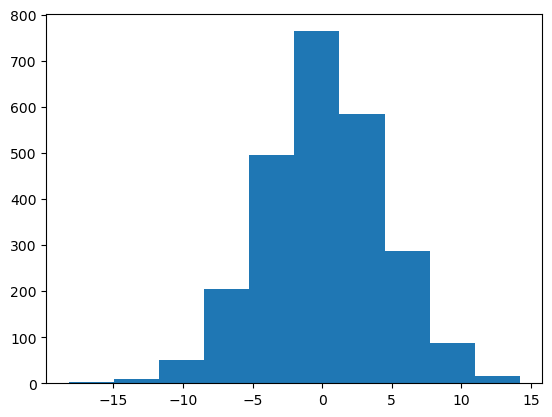

In [237]:
import matplotlib
import matplotlib.pyplot as plt

plt.hist(noise_ss_v2)
print(np.std(noise_ss_v2))
plt.show()

3.2088838055978424


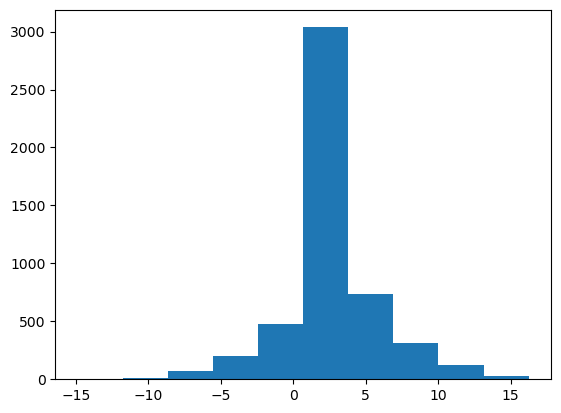

In [238]:
avgfp_train_df['score'] = ss_scores
plt.hist(avgfp_train_df['score'])
print(avgfp_train_df['score'].std())

In [35]:
# copy of above cell

# getting training set (5k in ss, 5k not in ss)
# avgfp_train_ss = avgfp_no_mixed_pos_df[avgfp_no_mixed_pos_df['in_sec_str'] == True].sample(72)
# avgfp_train_not_ss = avgfp_no_mixed_pos_df[avgfp_no_mixed_pos_df['in_sec_str'] == False].sample(72)
# avgfp_train_df = pd.concat([avgfp_train_ss, avgfp_train_not_ss])
avgfp_train_df = avgfp_no_mixed_pos_df.sample(13)

# avgfp_test_ss = avgfp_no_mixed_pos_df[avgfp_no_mixed_pos_df['in_sec_str'] == True].sample(15)
# avgfp_test_not_ss = avgfp_no_mixed_pos_df[avgfp_no_mixed_pos_df['in_sec_str'] == False].sample(15)
# avgfp_test_df = pd.concat([avgfp_test_ss, avgfp_test_not_ss])

avgfp_test_df = avgfp_no_mixed_pos_df.sample(10342)

# getting test set (2.5k in ss, 2.5k not in ss)
# print(avgfp_train_df['in_sec_str'].value_counts())
# print(avgfp_test_df['in_sec_str'].value_counts())

In [41]:
# creating files (NO NOISE for test values)

# unchanged
# avgfp_train_df['score'] = unchanged_scores
# avgfp_full_df = pd.concat([avgfp_train_df, avgfp_test_df])
ssf.write_data_file("avgfp_trainbatch_train_13_test_10342_t3", protein_seq_avgfp, avgfp_full_df)

# # ss
# avgfp_trabin_df['score'] = ss_scores
# avgfp_full_df = pd.conbcat([avgfp_train_df, avgfp_test_df])
# ssf.write_data_file("avgfp_MLformat_5000_train_2000_ss_noise_t2_v2", protein_seq_avgfp, avgfp_full_df)

# # not ss
# avgfp_train_df['score'] = not_ss_scores
# avgfp_full_df = pd.concat([avgfp_train_df, avgfp_test_df])
# ssf.write_data_file("avgfp_MLformat_5000_train_2000_not_ss_noise_t2_v2", protein_seq_avgfp, avgfp_full_df)

Filename: avgfp_trainbatch_train_13_test_10342_t3.txt


In [ ]:
avgfp_train_df = avgfp_no_mixed_pos_df.sample(13)
avgfp_test_df = avgfp_no_mixed_pos_df.sample(10342)
avgfp_full_df = pd.concat([avgfp_train_df, avgfp_test_df])
ssf.write_data_file("avgfp_trainbatch_train_13_test_10342_t3", protein_seq_avgfp, avgfp_full_df)

**GB1**

In [87]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'gb1_stride.txt'
gb1_stride_file = open(path, 'r')

In [88]:
gb1_ss_indexes = ssf.get_all_sec_struc_boolean(gb1_stride_file) # boolean list of secondary structure assignements

In [89]:
ss = gb1_ss_indexes.count(True)
not_ss = gb1_ss_indexes.count(False)
print(ss)
print(not_ss)

47
9


In [90]:
# importing pab1 data from Gelman et al.
gb1_df1 = pd.read_csv("../Raw Data/gb1.tsv.txt", sep="\t")
gb1_df = gb1_df1.dropna()
print(len(gb1_df))
# gb1_df = gb1_df.sample(n=480)
print(gb1_df.columns)
gb1_df = gb1_df.sample(frac=1)

536084
Index(['variant', 'num_mutations', 'inp', 'sel', 'score'], dtype='object')


In [91]:
# rounding score column to 2 decimal points
gb1_df["score"] = gb1_df["score"].round(6)
print(len(gb1_df))

# remove values with wildcard star thing cause idk what it means
gb1_df = gb1_df[gb1_df["variant"].str.contains("\*") == False]

# gb1_df = gb1_df.sample(n=40)
# pab1_df = pab1_df.head(37600)
print(len(gb1_df))

536084
536084


In [183]:
# getting protein sequence
# protein_seq_gb1 = ssf.get_protein_seq("P04386")

In [92]:
# getting dataset size to run

string_seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
print(len(string_seq)) # <- domain length of 75
protein_seq_gb1 = ssf.get_expanded_seq(string_seq)
print(protein_seq_gb1)

56
MET GLN TYR LYS LEU ILE LEU ASN GLY LYS THR LEU LYS GLY GLU THR THR THR GLU ALA VAL ASP ALA ALA THR ALA GLU LYS VAL PHE LYS GLN TYR ALA ASN ASP ASN GLY VAL ASP GLY GLU TRP THR TYR ASP ASP ALA THR LYS THR PHE THR VAL THR GLU


In [93]:
# splitting variant list if there are multiple mutations
gb1_mut = gb1_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
gb1_df["WILD_TYPE_RES"] = ssf.get_wild_type(gb1_mut)

# get mutated residue and place in seperate col
gb1_df["MUTATED_RES"] = ssf.get_mutation_type(gb1_mut)

# get position and place in seperate col
gb1_df["POSITION"] = ssf.get_position(gb1_mut)

# replace variant column with reformatted variant name
gb1_df["variant"] = ssf.get_mutations_names_list(gb1_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

# gb1_df = gb1_df.drop(columns=to_drop)

In [94]:
# need positionssplit
gb1_df["positions_split"] = ssf.get_positions_split(gb1_df)

# add in_sec_str_col
gb1_df = add_sec_str_col(gb1_df, gb1_ss_indexes, 0)

In [15]:
# ssf.write_data_file("gb1_MLformat_full_dataset", protein_seq_gb1, gb1_df)

Filename: gb1_MLformat_full_dataset.txt


In [99]:
gb1_train_df, gb1_test_df, gb1_remaining_df = get_train_and_test_df(gb1_df, 0.70, 110)
# gb1_test_10000 = gb1_test_df.head(10000)
gb1_df_format = pd.concat([gb1_train_df, gb1_test_10000])
print(len(gb1_df_format))
# writing data to txt file
# ssf.write_data_file("gb1_MLformat_110_train_382146_test_t1", protein_seq_gb1, gb1_df_format)

in fraction,df len536084
77
33
Train Data Fraction: 0.7
false_df len145781
true_df len390303
in fraction,df len535974
Test Data Fraction: 0.7
false_df len145748
true_df len390226
Size of Test Dataset: 485823
Size of Total Dataset: 485933


NameError: name 'gb1_test_10000' is not defined

In [117]:
# make a smaller test size so program doesn't crash
gb1_train_dummy, gb1_test_df, gb1_remaining_df = get_train_and_test_df(gb1_df, 0.70, 30000)

in fraction,df len536084
244999
105001
Train Data Fraction: 0.7
false_df len268502
true_df len267582
in fraction,df len186084
Test Data Fraction: 0.7
false_df len163501
true_df len22583
Size of Test Dataset: 32256
Size of Total Dataset: 382256


In [116]:
print(len(gb1_test_df))

32256


In [114]:
gb1_train_df, gb1_test_df, gb1_remaining_df = get_train_and_test_df(gb1_df, 0.84, 110)
gb1_train_dummy, gb1_small_test_df, gb1_remaining_df = get_train_and_test_df(gb1_test_df, 0.84, 450000)
print("SMALL TEST")
print(len(gb1_small_test_df))
gb1_df_format = pd.concat([gb1_train_df, gb1_small_test_df])
print(len(gb1_df_format))
ssf.write_data_file("gb1_MLformat_110_train_14524_test_t3", protein_seq_gb1, gb1_df_format)

in fraction,df len536084
92
18
Train Data Fraction: 0.836
false_df len145781
true_df len390303
in fraction,df len535974
Test Data Fraction: 0.84
false_df len145763
true_df len390211
Size of Test Dataset: 464531
Size of Total Dataset: 464641
in fraction,df len464531
378000
72000
Train Data Fraction: 0.84
false_df len74325
true_df len390206
in fraction,df len14531
Test Data Fraction: 0.84
false_df len2325
true_df len12206
Size of Test Dataset: 14524
Size of Total Dataset: 464524
SMALL TEST
14524
14634
Filename: gb1_MLformat_110_train_14524_test_t3.txt


In [37]:
gb1_train_df_2, gb1_test_df_2, gb1_remaining_df_2 = get_train_and_test_df(gb1_df, 0.70, 110)
gb1_df_format_2 = pd.concat([gb1_train_df_2, gb1_test_df_2])
print(len(gb1_df_format_2))
ssf.write_data_file("gb1_MLformat_982_train_13945_test_t2", protein_seq_gb1, gb1_df_format_2)

in fraction,df len25737
530
452
Train Data Fraction: 0.54
false_df len17674
true_df len8063
in fraction,df len24755
Test Data Fraction: 0.54
false_df len17222
true_df len7533
Size of Test Dataset: 13945
Size of Total Dataset: 14927
14927
Filename: bgl3_MLformat_982_train_13945_test_t2.txt


In [41]:
gb1_train_df_3, gb1_test_df_3, gb1_remaining_df_3 = get_train_and_test_df(gb1_df, 0.70, 110)
gb1_df_format_3 = pd.concat([gb1_train_df_3, gb1_test_df_3])
print(len(gb1_df_format_3))
ssf.write_data_file("gb1_MLformat_982_train_13945_test_t3", protein_seq_gb1, gb1_df_format_3)

in fraction,df len25737
530
452
Train Data Fraction: 0.54
false_df len17674
true_df len8063
in fraction,df len24755
Test Data Fraction: 0.54
false_df len17222
true_df len7533
Size of Test Dataset: 13945
Size of Total Dataset: 14927
14927
Filename: bgl3_MLformat_982_train_13945_test_t3.txt


In [42]:
print(len(gb1_train_df))
print(len(gb1_test_df))
print(len(gb1_train_df_2))
print(len(gb1_test_df_2))
print(len(gb1_train_df_3))
print(len(gb1_test_df_3))

982
13945
982
13945
982
13945


# Adding Noise to GB1

In [65]:
# importing and formatting data (25737 usable vals)
gb1_df1 = pd.read_csv("../Raw Data/gb1.tsv.txt", sep="\t")
gb1_df = gb1_df1.dropna()
gb1_df = gb1_df.sample(frac=1)

# print(gb1_df.head(10))
# rounding score column to 6 decimal points
gb1_df["score"] = gb1_df["score"].round(6)

# remove values with wildcard star next to them
gb1_df = gb1_df[gb1_df["variant"].str.contains("\*") == False]

# splitting variant list if there are multiple mutations
gb1_mut = gb1_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
gb1_df["WILD_TYPE_RES"] = ssf.get_wild_type(gb1_mut)

# get mutated residue and place in seperate col
gb1_df["MUTATED_RES"] = ssf.get_mutation_type(gb1_mut)

# get position and place in seperate col
gb1_df["POSITION"] = ssf.get_position(gb1_mut)

gb1_df["positions_split"] = ssf.get_positions_split(gb1_df)

# replace variant column with reformatted variant name
gb1_df["variant"] = ssf.get_mutations_names_list(gb1_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]
# print(gb1_df.head(10))
print(len(gb1_df))

536084


In [66]:
# secondary structure assignments
path = "../PDB and STRIDE Files/" + 'gb1_stride.txt'
gb1_stride_file = open(path, 'r')

gb1_ss_indexes = ssf.get_sec_struc_boolean(gb1_stride_file) # not including turns

In [67]:
# need positionssplit
gb1_df["positions_split"] = ssf.get_positions_split(gb1_df)

# gb1_only_ss_df = get_ss_dataset(gb1_df, gb1_ss_indexes, 0)
# gb1_only_not_ss_df = get_not_ss_dataset(gb1_df, gb1_ss_indexes, 0)
# gb1_no_mixed_pos_df = pd.concat([gb1_only_ss_df, gb1_only_not_ss_df])
gb1_no_mixed_pos_df = gb1_df

In [68]:
print(len(gb1_df))
print(len(gb1_no_mixed_pos_df))

536084
536084


In [69]:
gb1_no_mixed_pos_df = add_sec_str_col(gb1_no_mixed_pos_df, gb1_ss_indexes, 0)
print(gb1_no_mixed_pos_df['in_sec_str'].value_counts())

False    268560
True     267524
Name: in_sec_str, dtype: int64


In [70]:
# shuffling data
gb1_no_mixed_pos_df = gb1_no_mixed_pos_df.sample(frac=1)
print(len(gb1_no_mixed_pos_df))

536084


In [71]:
# protein sequence
string_seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
protein_seq_gb1 = ssf.get_expanded_seq(string_seq)

In [56]:
# getting training set (5k in ss, 5k not in ss)
gb1_train_ss = gb1_no_mixed_pos_df[gb1_no_mixed_pos_df['in_sec_str'] == True].sample(40)
gb1_train_not_ss = gb1_no_mixed_pos_df[gb1_no_mixed_pos_df['in_sec_str'] == False].sample(40)
gb1_train_df = pd.concat([gb1_train_ss, gb1_train_not_ss])

gb1_test_ss = gb1_no_mixed_pos_df[gb1_no_mixed_pos_df['in_sec_str'] == True].sample(8)
gb1_test_not_ss = gb1_no_mixed_pos_df[gb1_no_mixed_pos_df['in_sec_str'] == False].sample(8)
gb1_test_df = pd.concat([gb1_test_ss, gb1_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(gb1_train_df['in_sec_str'].value_counts())
print(gb1_test_df['in_sec_str'].value_counts())

True     40
False    40
Name: in_sec_str, dtype: int64
True     8
False    8
Name: in_sec_str, dtype: int64


In [259]:
# # getting dataset with correct ratios (only using training dataset)
# gb1_train_df, gb1_test_df_1, gb1_remaining_df = get_train_and_test_df(gb1_no_mixed_pos_df, 0.70, 10000)

In [260]:
# gb1_test_df, gb1_dummy_df, gb1_remaining_df_1 = get_train_and_test_df(gb1_test_df_1, 0.70, 5000)

In [57]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = gb1_train_df['score'].std()
mean = gb1_train_df['score'].mean()
median = gb1_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(gb1_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (gb1_train_df.in_sec_str == True).sum()
num_not_ss_vals = (gb1_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = gb1_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = gb1_train_df['score']
# print(unchanged_scores[0:10])
ss_scores = gb1_train_df['score'] + noise_ss_to_add
# print(ss_scores[0:10])
not_ss_scores = gb1_train_df['score'] + noise_not_ss_to_add
# print(not_ss_scores[0:10])

Dataset Standard Deviation: 2.204906979409146
Dataset Mean: -2.0552613375
Dataset Median: -1.5347925
Kurtosis: 1.9212641745260335


In [58]:
abs_val_list = [abs(x) for x in gb1_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

2.2690442875000008

3.557484593696043
Percentage Change: 56.78339172549279
4.165350043091337
Percentage Change: 83.57288423315252


In [33]:
# creating files (NO NOISE for test values)

# unchanged
# gb1_train_df['score'] = unchanged_scores
gb1_full_df = gb1_no_mixed_pos_df.sample(34)
ssf.write_data_file("gb1_trainbatch_train_27_test_7_t3", protein_seq_gb1, gb1_full_df)

# # ss
# gb1_train_df['score'] = ss_scores
# gb1_full_df = pd.concat([gb1_train_df, gb1_test_df])
# ssf.write_data_file("gb1_MLformat_10000_train_5000_ss_noise_t2_v2", protein_seq_gb1, gb1_full_df)

# # not ss
# gb1_train_df['score'] = not_ss_scores
# gb1_full_df = pd.concat([gb1_train_df, gb1_test_df])
# ssf.write_data_file("gb1_MLformat_10000_train_5000_not_ss_noise_t2_v2", protein_seq_gb1, gb1_full_df)

Filename: gb1_trainbatch_train_27_test_7_t3.txt


In [87]:
gb1_full_df = gb1_no_mixed_pos_df.sample(21471)
ssf.write_data_file("gb1_trainbatch_train_27_test_21444_t3", protein_seq_gb1, gb1_full_df)

Filename: gb1_trainbatch_train_27_test_21444_t3.txt


**GAL4**

In [77]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'gal4_stride.txt'
gal4_stride_file = open(path, 'r')

In [78]:
gal4_ss_indexes = ssf.get_sec_struc_boolean(gal4_stride_file) # boolean list of secondary structure assignements

In [79]:
ss = gal4_ss_indexes.count(True)
not_ss = gal4_ss_indexes.count(False)
print(ss)
print(not_ss)

415
466


**Alpha-synuclein**

In [80]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'alpha-synuclein_stride.txt'
alpha_synuclein_stride_file = open(path, 'r')

In [81]:
alpha_synuclein_ss_indexes = ssf.get_sec_struc_boolean(alpha_synuclein_stride_file) # boolean list of secondary structure assignements

In [82]:
ss = alpha_synuclein_ss_indexes.count(True)
not_ss = alpha_synuclein_ss_indexes.count(False)
print(ss)
print(not_ss)

92
48


**Small ubiquitin-related modifier 1**

In [74]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'modifier_1_stride.txt'
modifier_1_stride_file = open(path, 'r')

In [75]:
modifier_1_ss_indexes = ssf.get_sec_struc_boolean(modifier_1_stride_file) # boolean list of secondary structure assignements

In [76]:
ss = modifier_1_ss_indexes.count(True)
not_ss = modifier_1_ss_indexes.count(False)
print(ss)
print(not_ss)

47
54


**TAR DNA-binding protein 43**

In [86]:
# importing STRIDE file
path = "../PDB and STRIDE Files/" + 'tar_stride.txt'
tar_stride_file = open(path, 'r')

In [87]:
tar_ss_indexes = ssf.get_sec_struc_boolean(tar_stride_file) # boolean list of secondary structure assignements

In [88]:
ss = tar_ss_indexes.count(True)
not_ss = tar_ss_indexes.count(False)
print(ss)
print(not_ss)

149
265


**Human Glucokinase**

## Cleaning MaveDB Data

In [21]:
import re
# delete rows with "del" in it or *
# normalize scores? (already done in script)
def format_mavedb_variant(df, variant_col_name, offset):
    new_var_col = []
    for variant in df[variant_col_name]:
        wild_type = Bio.PDB.Polypeptide.three_to_one(variant[2:5].upper())
        position = int(re.findall("[0-9]+", variant)[0]) + offset
        mut_type = Bio.PDB.Polypeptide.three_to_one(variant[-3:].upper())
        new_var_col.append(wild_type + str(position) + mut_type)
    return new_var_col

**GAL4**

In [235]:
gal4_df1 = pd.read_csv("../Raw Data/gal4.csv.csv")

In [236]:
# take note of offset

# find columns and rename title column
gal4_df1 = pd.read_csv("../Raw Data/gal4.csv.csv")
gal4_df1.columns = gal4_df1.iloc[3]
print(gal4_df1.columns)
print(len(gal4_df1))


gal4_df = gal4_df1[(gal4_df1["hgvs_pro"].str.contains("del") == False) & (gal4_df1["hgvs_pro"].str.contains("hgvs") == False)
                   & (gal4_df1["hgvs_pro"].str.contains("Ter") == False)]
gal4_df = gal4_df.sample(frac=1)

print(len(gal4_df))

Index(['accession', 'hgvs_nt', 'hgvs_splice', 'hgvs_pro', 'score'], dtype='object', name=3)
1323
1196


In [244]:
# getting uniprot to compare offset
protein_seq_gal4 = ssf.get_protein_seq("P04386")

In [245]:
# comparing offset
protein_seq_gal4_list = protein_seq_gal4.split(" ")
# print(protein_seq_gal4_list)
print(protein_seq_gal4_list[41]) 

PRO


In [257]:
gal4_df["variant"] = format_mavedb_variant(gal4_df, "hgvs_pro", 0)

C:\Users\deepti\AppData\Local\Temp/ipykernel_1360/276527083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gal4_df["variant"] = format_mavedb_variant(gal4_df, "hgvs_pro", 0)


In [258]:
# splitting variant list if there are multiple mutations
gal4_mut = gal4_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
gal4_df["WILD_TYPE_RES"] = ssf.get_wild_type(gal4_mut)

# get mutated residue and place in seperate col
gal4_df["MUTATED_RES"] = ssf.get_mutation_type(gal4_mut)

# get position and place in seperate col
gal4_df["POSITION"] = ssf.get_position(gal4_mut)

# replace variant column with reformatted variant name
gal4_df["variant"] = ssf.get_mutations_names_list(gal4_df)

# drop unneccesary columns
# to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

# pab1_df = pab1_df.drop(columns=to_drop)

C:\Users\deepti\AppData\Local\Temp/ipykernel_1360/789454968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gal4_df["WILD_TYPE_RES"] = ssf.get_wild_type(gal4_mut)
C:\Users\deepti\AppData\Local\Temp/ipykernel_1360/789454968.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gal4_df["MUTATED_RES"] = ssf.get_mutation_type(gal4_mut)
C:\Users\deepti\AppData\Local\Temp/ipykernel_1360/789454968.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [ ]:
# getting training and test datasets

# get ss position indexes
path = "../PDB and STRIDE Files/" + 'gal4_stride.txt'
gal4_stride_file = open(path, 'r')

gal4_ss_indexes = ssf.get_sec_struc_boolean(gal4_stride_file) # boolean list of secondary structure assignements

# need positionssplit
gal4_df["positions_split"] = ssf.get_positions_split(gal4_df)

# add in_sec_str_col
gal4_df = add_sec_str_col(gal4_df, gal4_ss_indexes, 0)

In [ ]:
gal4_train_df, gal4_test_df = get_train_and_test_df(gal4_df, 0.47, 40)
gal4_df_format = pd.concat([gal4_train_df, gal4_test_df])

# writing data to txt file
ssf.write_data_file("gal4_MLformat_40_train", protein_seq_gal4, gal4_df_format)

**Small ubiquitin-related modifier 1**

In [77]:
modifier_1_df1 = pd.read_csv("../Raw Data/modifier_1_mod.csv")

In [78]:
# modifier_1_df1.columns = modifier_1_df1.iloc[3]
print(modifier_1_df1.columns)
print(len(modifier_1_df1))

modifier_1_df = modifier_1_df1[(modifier_1_df1["hgvs_pro"].str.contains("=") == False) & (modifier_1_df1["hgvs_pro"].str.contains("hgvs") == False)
                   & (modifier_1_df1["hgvs_pro"].str.contains("Ter") == False)]
print(len(modifier_1_df))
print(modifier_1_df.head(1))

# shuffle values
modifier_1_df = modifier_1_df.sample(frac=1)

Index(['accession', 'hgvs_nt', 'hgvs_splice', 'hgvs_pro', 'score', 'sd', 'se',
       'exp.score', 'exp.sd', 'df', 'pred.score'],
      dtype='object')
2020
1919
                   accession  hgvs_nt  hgvs_splice   hgvs_pro     score  \
0  urn:mavedb:00000001-b-1#1      NaN          NaN  p.Glu5Lys  1.311357   

         sd        se  exp.score    exp.sd   df  pred.score  
0  0.085569  0.042785    1.31651  0.024947  4.0    1.117086  


In [79]:
# getting uniprot to compare offset
protein_seq_modifier_1 = ssf.get_protein_seq("P63165")
# offset of 1
print(protein_seq_modifier_1)
print(len(protein_seq_modifier_1))

MET SER ASP GLN GLU ALA LYS PRO SER THR GLU ASP LEU GLY ASP LYS LYS GLU GLY GLU TYR ILE LYS LEU LYS VAL ILE GLY GLN ASP SER SER GLU ILE HIS PHE LYS VAL LYS MET THR THR HIS LEU LYS LYS LEU LYS GLU SER TYR CYS GLN ARG GLN GLY VAL PRO MET ASN SER LEU ARG PHE LEU PHE GLU GLY GLN ARG ILE ALA ASP ASN HIS THR PRO LYS GLU LEU GLY MET GLU GLU GLU ASP VAL ILE GLU VAL TYR GLN GLU GLN THR GLY GLY HIS SER THR VAL
403


In [65]:
protein_seq_modifier_1_split = protein_seq_modifier_1.split()

In [66]:
protein_seq_modifier_1 = protein_seq_modifier_1_split[17:98]

protein_seq_modifier_1_cut = ""
for residue in protein_seq_modifier_1:

    protein_seq_modifier_1_cut += residue + " "

protein_seq_modifier_1 = protein_seq_modifier_1_cut.rstrip()
print(protein_seq_modifier_1)

GLU GLY GLU TYR ILE LYS LEU LYS VAL ILE GLY GLN ASP SER SER GLU ILE HIS PHE LYS VAL LYS MET THR THR HIS LEU LYS LYS LEU LYS GLU SER TYR CYS GLN ARG GLN GLY VAL PRO MET ASN SER LEU ARG PHE LEU PHE GLU GLY GLN ARG ILE ALA ASP ASN HIS THR PRO LYS GLU LEU GLY MET GLU GLU GLU ASP VAL ILE GLU VAL TYR GLN GLU GLN THR GLY GLY HIS


In [80]:
modifier_1_df["variant"] = format_mavedb_variant(modifier_1_df, "hgvs_pro", -1)

In [81]:
print(modifier_1_df.head(10))

                         accession  hgvs_nt  hgvs_splice    hgvs_pro  \
1649  urn:mavedb:00000001-b-1#1650      NaN          NaN   p.Pro8Asp   
1885  urn:mavedb:00000001-b-1#1886      NaN          NaN  p.Lys16Gly   
199    urn:mavedb:00000001-b-1#200      NaN          NaN  p.Gln29Cys   
360    urn:mavedb:00000001-b-1#361      NaN          NaN  p.Arg70Leu   
95      urn:mavedb:00000001-b-1#96      NaN          NaN   p.Ala6Val   
1998  urn:mavedb:00000001-b-1#1999      NaN          NaN  p.His98Pro   
677    urn:mavedb:00000001-b-1#678      NaN          NaN  p.Lys39Asp   
476    urn:mavedb:00000001-b-1#477      NaN          NaN  p.Ser31Gln   
445    urn:mavedb:00000001-b-1#446      NaN          NaN  p.Arg63Ile   
1428  urn:mavedb:00000001-b-1#1429      NaN          NaN  p.Val90Cys   

         score        sd        se  exp.score    exp.sd   df  pred.score  \
1649 -0.538399  0.392906  0.196453  -0.646084  0.290898  4.0   -0.190205   
1885  0.800349  0.095263  0.047631   0.802951  0.034200

In [82]:
# splitting variant list if there are multiple mutations
modifier_1_mut = modifier_1_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
modifier_1_df["WILD_TYPE_RES"] = ssf.get_wild_type(modifier_1_mut)

# get mutated residue and place in seperate col
modifier_1_df["MUTATED_RES"] = ssf.get_mutation_type(modifier_1_mut)

# get position and place in seperate col
modifier_1_df["POSITION"] = ssf.get_position(modifier_1_mut)

# replace variant column with reformatted variant name
modifier_1_df["variant"] = ssf.get_mutations_names_list(modifier_1_df)

# drop unneccesary columns
# to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

# pab1_df = pab1_df.drop(columns=to_drop)

In [83]:
# getting training and test datasets

# get ss position indexes
path = "../PDB and STRIDE Files/" + 'modifier_1_stride_confident.txt'
modifier_1_stride_file = open(path, 'r')

modifier_1_ss_indexes = ssf.get_all_sec_struc_boolean(modifier_1_stride_file) # boolean list of secondary structure assignements

# need positionssplit
modifier_1_df["positions_split"] = ssf.get_positions_split(modifier_1_df)

# add in_sec_str_col
modifier_1_df = ssf.get_domain_dataset_v2(modifier_1_df, 18, 99, [-99])
modifier_1_df = add_sec_str_col(modifier_1_df, modifier_1_ss_indexes, 18)

C:\Users\deepti\OneDrive\UW\GitHub\secondary-structure-CNN-learning\Jupyter Notebooks\secStrucFormatting.py:591: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  in_domain_df = in_domain_df.append(rows, ignore_index=True)


In [84]:
print(modifier_1_ss_indexes.count(True))
print(modifier_1_ss_indexes.count(False))

68
13


In [88]:
modifier_1_train_df, modifier_1_test_df, modifier_1_remaining_df = get_train_and_test_df(modifier_1_df, 0.84, 198)
# print("TEST LEN")
# print(len(modifier_1_test_df))
modifier_1_df_format = pd.concat([modifier_1_train_df, modifier_1_test_df])
print(len(modifier_1_df_format))
# writing data to txt file
ssf.write_data_file("modifier_1_MLformat_198_train_1337_test_turns3", protein_seq_modifier_1, modifier_1_df_format)

in fraction,df len1539
166
32
Train Data Fraction: 0.838
false_df len247
true_df len1292
in fraction,df len1341
Test Data Fraction: 0.84
false_df len215
true_df len1126
Size of Test Dataset: 1337
Size of Total Dataset: 1535
1535
Filename: modifier_1_MLformat_198_train_1337_test_turns3.txt


**TAR DNA-binding protein 43**

In [153]:
tar_df_pt1 = pd.read_csv("../Raw Data/tar1_mod.csv")
tar_df_pt2 = pd.read_csv("../Raw Data/tar2_mod.csv")

In [154]:
print(len(tar_df_pt1))
print(len(tar_df_pt2))
# tar_df_pt1 = tar_df_pt1.sample(frac=1)
# tar_df_pt2 = tar_df_pt2.sample(frac=1)
# print(tar_df_pt1.head(30))
# print(tar_df_pt2.head(30))
# tar_df1 = pd.concat([tar_df_pt1, tar_df_pt2])
# print(len(tar_df1))

# print(tar_df1.columns)

tar_df_pt1 = tar_df_pt1[(tar_df_pt1["hgvs_pro"].str.contains("\*") == False) & (tar_df_pt1["hgvs_pro"].str.contains("hgvs") == False)
                    & (tar_df_pt1["hgvs_pro"].str.contains("Ter") == False)]

tar_df_pt2 = tar_df_pt2[(tar_df_pt2["hgvs_pro"].str.contains("\*") == False) & (tar_df_pt2["hgvs_pro"].str.contains("hgvs") == False)
                    & (tar_df_pt2["hgvs_pro"].str.contains("Ter") == False)]

# print(len(tar_df))
# # shuffle values
# tar_df = tar_df.sample(frac=1)
# print(tar_df.head(3))

704
714


In [155]:
# getting uniprot to compare offset
protein_seq_tar = ssf.get_protein_seq("Q13148")
print(protein_seq_tar)

MET SER GLU TYR ILE ARG VAL THR GLU ASP GLU ASN ASP GLU PRO ILE GLU ILE PRO SER GLU ASP ASP GLY THR VAL LEU LEU SER THR VAL THR ALA GLN PHE PRO GLY ALA CYS GLY LEU ARG TYR ARG ASN PRO VAL SER GLN CYS MET ARG GLY VAL ARG LEU VAL GLU GLY ILE LEU HIS ALA PRO ASP ALA GLY TRP GLY ASN LEU VAL TYR VAL VAL ASN TYR PRO LYS ASP ASN LYS ARG LYS MET ASP GLU THR ASP ALA SER SER ALA VAL LYS VAL LYS ARG ALA VAL GLN LYS THR SER ASP LEU ILE VAL LEU GLY LEU PRO TRP LYS THR THR GLU GLN ASP LEU LYS GLU TYR PHE SER THR PHE GLY GLU VAL LEU MET VAL GLN VAL LYS LYS ASP LEU LYS THR GLY HIS SER LYS GLY PHE GLY PHE VAL ARG PHE THR GLU TYR GLU THR GLN VAL LYS VAL MET SER GLN ARG HIS MET ILE ASP GLY ARG TRP CYS ASP CYS LYS LEU PRO ASN SER LYS GLN SER GLN ASP GLU PRO LEU ARG SER ARG LYS VAL PHE VAL GLY ARG CYS THR GLU ASP MET THR GLU ASP GLU LEU ARG GLU PHE PHE SER GLN TYR GLY ASP VAL MET ASP VAL PHE ILE PRO LYS PRO PHE ARG ALA PHE ALA PHE VAL THR PHE ALA ASP ASP GLN ILE ALA GLN SER LEU CYS GLY GLU ASP LEU ILE ILE 

In [156]:
protein_seq_tar_split = protein_seq_tar.split()
print(protein_seq_tar_split[291]) # for the first one starts at 289 (add offset of )
# row 10, col 11, 31 

SER


In [157]:
print(protein_seq_tar_split[346]) 
# row 12, 6, 31 <- 16 starts at 346: 1 starts at 331?
# have to offset seperately and then add

SER


In [158]:
tar_df_pt1["variant"] = format_mavedb_variant(tar_df_pt1, "hgvs_pro", 288)
tar_df_pt2["variant"] = format_mavedb_variant(tar_df_pt2, "hgvs_pro", 330)

In [159]:
tar_df = pd.concat([tar_df_pt1, tar_df_pt2])
tar_df = tar_df.sample(frac=1)
print(len(tar_df))

1342


In [160]:
# splitting variant list if there are multiple mutations
tar_mut = tar_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
tar_df["WILD_TYPE_RES"] = ssf.get_wild_type(tar_mut)

# get mutated residue and place in seperate col
tar_df["MUTATED_RES"] = ssf.get_mutation_type(tar_mut)

# get position and place in seperate col
tar_df["POSITION"] = ssf.get_position(tar_mut)

# replace variant column with reformatted variant name
tar_df["variant"] = ssf.get_mutations_names_list(tar_df)

# drop unneccesary columns
# to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

# pab1_df = pab1_df.drop(columns=to_drop)

In [161]:
# getting training and test datasets

# get ss position indexes
path = "../PDB and STRIDE Files/" + 'tar_stride.txt'
tar_stride_file = open(path, 'r')

tar_ss_indexes = ssf.get_sec_struc_boolean(tar_stride_file) # boolean list of secondary structure assignements

# need positionssplit
tar_df["positions_split"] = ssf.get_positions_split(tar_df)

# add in_sec_str_col
tar_df = add_sec_str_col(tar_df, tar_ss_indexes, 0)

In [113]:
# tar_train_df, tar_test_df, tar_remaining_df = get_train_and_test_df(tar_df, 0.36, 812)
# print(len(tar_test_df))
# tar_df_format = pd.concat([tar_train_df, tar_test_df])

# # writing data to txt file
# # ssf.write_data_file("tar_MLformat_812_train_10k_test_1", protein_seq_tar, tar_df_format)

# Human Glucokinase? (Adding Noise)

In [203]:
glucokinase_df1 = pd.read_csv("../Raw Data/glucokinase_scores.csv")

In [204]:
print(glucokinase_df1.columns)

Index(['# Accession: urn:mavedb:00000096-a-1', 'Unnamed: 1', 'Unnamed: 2',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')


In [205]:
# take note of offset

glucokinase_df1.columns = glucokinase_df1.iloc[3]
print(glucokinase_df1.columns)
print(len(glucokinase_df1))


glucokinase_df = glucokinase_df1[(glucokinase_df1["hgvs_pro"].str.contains("del") == False) & (glucokinase_df1["hgvs_pro"].str.contains("hgvs") == False)
                   & (glucokinase_df1["hgvs_pro"].str.contains("Ter") == False)]

glucokinase_df = glucokinase_df1[(glucokinase_df1["hgvs_pro"].str.contains("=") == False) & (glucokinase_df1["hgvs_pro"].str.contains("hgvs") == False)
                   & (glucokinase_df1["hgvs_pro"].str.contains("Ter") == False)]

glucokinase_df = glucokinase_df.sample(frac=1)

print(len(glucokinase_df))

Index(['accession', 'hgvs_nt', 'hgvs_splice', 'hgvs_pro', 'score', 'sd', 'df',
       'se'],
      dtype='object', name=3)
9366
8570


In [193]:
# getting uniprot to compare offset
protein_seq_glucokinase = ssf.get_protein_seq("P35557")
# offset of 1
print(protein_seq_glucokinase)
print(len(protein_seq_glucokinase))
# protein_seq_glucokinase

MET LEU ASP ASP ARG ALA ARG MET GLU ALA ALA LYS LYS GLU LYS VAL GLU GLN ILE LEU ALA GLU PHE GLN LEU GLN GLU GLU ASP LEU LYS LYS VAL MET ARG ARG MET GLN LYS GLU MET ASP ARG GLY LEU ARG LEU GLU THR HIS GLU GLU ALA SER VAL LYS MET LEU PRO THR TYR VAL ARG SER THR PRO GLU GLY SER GLU VAL GLY ASP PHE LEU SER LEU ASP LEU GLY GLY THR ASN PHE ARG VAL MET LEU VAL LYS VAL GLY GLU GLY GLU GLU GLY GLN TRP SER VAL LYS THR LYS HIS GLN MET TYR SER ILE PRO GLU ASP ALA MET THR GLY THR ALA GLU MET LEU PHE ASP TYR ILE SER GLU CYS ILE SER ASP PHE LEU ASP LYS HIS GLN MET LYS HIS LYS LYS LEU PRO LEU GLY PHE THR PHE SER PHE PRO VAL ARG HIS GLU ASP ILE ASP LYS GLY ILE LEU LEU ASN TRP THR LYS GLY PHE LYS ALA SER GLY ALA GLU GLY ASN ASN VAL VAL GLY LEU LEU ARG ASP ALA ILE LYS ARG ARG GLY ASP PHE GLU MET ASP VAL VAL ALA MET VAL ASN ASP THR VAL ALA THR MET ILE SER CYS TYR TYR GLU ASP HIS GLN CYS GLU VAL GLY MET ILE VAL GLY THR GLY CYS ASN ALA CYS TYR MET GLU GLU MET GLN ASN VAL GLU LEU VAL GLU GLY ASP GLU GLY ARG 

In [31]:
# protein_seq_glucokinase_split = protein_seq_glucokinase.split()
# print(len(protein_seq_glucokinase_split))
# protein_seq_glucokinase = protein_seq_glucokinase[:-4]
# print(protein_seq_glucokinase)

In [206]:
glucokinase_df["variant"] = format_mavedb_variant(glucokinase_df, "hgvs_pro", -1)
print(len(glucokinase_df))

8570


In [207]:
# splitting variant list if there are multiple mutations
glucokinase_mut = glucokinase_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
glucokinase_df["WILD_TYPE_RES"] = ssf.get_wild_type(glucokinase_mut)

# get mutated residue and place in seperate col
glucokinase_df["MUTATED_RES"] = ssf.get_mutation_type(glucokinase_mut)

# get position and place in seperate col
glucokinase_df["POSITION"] = ssf.get_position(glucokinase_mut)

# replace variant column with reformatted variant name
glucokinase_df["variant"] = ssf.get_mutations_names_list(glucokinase_df)

In [208]:
# getting training and test datasets

# get ss position indexes
path = "../PDB and STRIDE Files/" + 'glucokinase_stride_confident.txt'
glucokinase_stride_file = open(path, 'r')

glucokinase_ss_indexes = ssf.get_sec_struc_boolean(glucokinase_stride_file) # boolean list of secondary structure assignements
print(glucokinase_ss_indexes.count(False))
print(glucokinase_ss_indexes.count(True))

# need positionssplit
glucokinase_df["positions_split"] = ssf.get_positions_split(glucokinase_df)
glucokinase_df = ssf.get_domain_dataset_v2(glucokinase_df, 0, 463, [])
print(len(glucokinase_df))

# add in_sec_str_col
glucokinase_df = add_sec_str_col(glucokinase_df, glucokinase_ss_indexes, 0)


144
320
8535


C:\Users\deepti\OneDrive\UW\GitHub\secondary-structure-CNN-learning\Jupyter Notebooks\secStrucFormatting.py:591: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  in_domain_df = in_domain_df.append(rows, ignore_index=True)


In [209]:
# # need positionssplit
# glucokinase_df["positions_split"] = ssf.get_positions_split(glucokinase_df)

glucokinase_only_ss_df = get_ss_dataset(glucokinase_df, glucokinase_ss_indexes, 0)
print(len(glucokinase_only_ss_df))
glucokinase_only_not_ss_df = get_not_ss_dataset(glucokinase_df, glucokinase_ss_indexes, 0)
print(len(glucokinase_only_not_ss_df))
glucokinase_no_mixed_pos_df = pd.concat([glucokinase_only_ss_df, glucokinase_only_not_ss_df])

# add in_sec_str_col
glucokinase_no_mixed_pos_df = add_sec_str_col(glucokinase_no_mixed_pos_df, glucokinase_ss_indexes, 0)

3                        accession hgvs_nt hgvs_splice     hgvs_pro  \
0     urn:mavedb:00000096-a-1#9098     NaN         NaN  p.Ala232Lys   
1     urn:mavedb:00000096-a-1#6698     NaN         NaN  p.Cys382Ala   
2     urn:mavedb:00000096-a-1#7241     NaN         NaN   p.Gln24Ala   
3      urn:mavedb:00000096-a-1#853     NaN         NaN   p.Thr65Glu   
4     urn:mavedb:00000096-a-1#5020     NaN         NaN  p.Gly343Arg   
...                            ...     ...         ...          ...   
8530  urn:mavedb:00000096-a-1#1912     NaN         NaN  p.Ser426Met   
8531  urn:mavedb:00000096-a-1#3472     NaN         NaN  p.Lys459Tyr   
8532  urn:mavedb:00000096-a-1#6974     NaN         NaN  p.Asp409Met   
8533  urn:mavedb:00000096-a-1#7522     NaN         NaN  p.Asp247Trp   
8534   urn:mavedb:00000096-a-1#939     NaN         NaN   p.Thr49Gly   

3            score           sd df           se variant WILD_TYPE_RES  \
0     -0.272247725  0.499682549  2  0.353328919  231LYS             A   
1

C:\Users\deepti\AppData\Local\Temp\ipykernel_17412\1097654771.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sec_str_df = sec_str_df.append(rows, ignore_index=True)
C:\Users\deepti\AppData\Local\Temp\ipykernel_17412\4042603016.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  not_sec_str_df = not_sec_str_df.append(rows, ignore_index=True)
C:\Users\deepti\AppData\Local\Temp\ipykernel_17412\501139114.py:8: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  glucokinase_no_mixed_pos_df = pd.concat([glucokinase_only_ss_df, glucokinase_only_not_ss_df])


In [198]:
# shuffling data
glucokinase_no_mixed_pos_df = glucokinase_no_mixed_pos_df.sample(frac=1)
print(len(glucokinase_no_mixed_pos_df))
glucokinase_no_mixed_pos_df = glucokinase_no_mixed_pos_df.dropna(subset=["score"])
print(len(glucokinase_no_mixed_pos_df))

8535
8535


In [199]:
# getting training set (5k in ss, 5k not in ss)
glucokinase_train_ss = glucokinase_no_mixed_pos_df[glucokinase_no_mixed_pos_df['in_sec_str'] == True].sample(2000)
glucokinase_train_not_ss = glucokinase_no_mixed_pos_df[glucokinase_no_mixed_pos_df['in_sec_str'] == False].sample(2000)
glucokinase_train_df = pd.concat([glucokinase_train_ss, glucokinase_train_not_ss])

glucokinase_test_ss = glucokinase_no_mixed_pos_df[glucokinase_no_mixed_pos_df['in_sec_str'] == True].sample(500)
glucokinase_test_not_ss = glucokinase_no_mixed_pos_df[glucokinase_no_mixed_pos_df['in_sec_str'] == False].sample(500)
glucokinase_test_df = pd.concat([glucokinase_test_ss, glucokinase_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(glucokinase_train_df['in_sec_str'].value_counts())
print(glucokinase_test_df['in_sec_str'].value_counts())

glucokinase_train_df["score"] = glucokinase_train_ss["score"].astype(float)
glucokinase_test_df["score"] = glucokinase_test_ss["score"].astype(float)

glucokinase_train_df = glucokinase_train_df.dropna(subset = ["score", "variant"])
glucokinase_test_df = glucokinase_test_df.dropna(subset = ["score", "variant"])


# # cast to float
# new_float_scores_train = []
# for x in glucokinase_train_ss["score"]:
#     x_float = float(x)
#     new_float_scores_train.append(x_float)
    
# glucokinase_train_ss["score"] = new_float_scores_train
    
# new_float_scores_test = []
# for x in glucokinase_test_not_ss["score"]:
#     x_float = float(x)
#     new_float_scores_test.append(x_float)
    
# glucokinase_test_not_ss["score"] = new_float_scores_test
# print()

True     2000
False    2000
Name: in_sec_str, dtype: int64
True     500
False    500
Name: in_sec_str, dtype: int64


In [166]:
# print(glucokinase_train_ss.columns)
# print(type(glucokinase_train_ss["score"].iloc[0]))
# print(glucokinase_train_df["score"])

# for val in glucokinase_train_df["score"]:
#     if type(val) == str:
#         print(val)
#         print("problem")
#     else:
#         print("not problem")
    

In [210]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
# list_train = list(glucokinase_train_df['score'])
# print(list)
std = glucokinase_train_df['score'].std()
mean = glucokinase_train_df['score'].mean()
median = glucokinase_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(glucokinase_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (glucokinase_train_df.in_sec_str == True).sum()
num_not_ss_vals = (glucokinase_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = glucokinase_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = glucokinase_train_df['score']
print(unchanged_scores[0:10])
ss_scores = glucokinase_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = glucokinase_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 1.3483178563016196
Dataset Mean: 0.6644973974530596
Dataset Median: 0.561735664
Kurtosis: 7.398595944119408
1248   -0.238918
2910    0.066074
3312    2.515454
2372    0.802195
5307    0.752648
3662    0.080216
1331    1.301941
4112    0.642198
5569   -0.282153
4185    0.142465
Name: score, dtype: float64
1248    10.876222
2910     1.189809
3312     0.514827
2372     1.801962
5307     1.888411
3662    -1.106385
1331    -3.478624
4112     9.224042
5569    -0.000408
4185    -2.000411
Name: score, dtype: float64
1248   -0.238918
2910    0.066074
3312    2.515454
2372    0.802195
5307    0.752648
3662    0.080216
1331    1.301941
4112    0.642198
5569   -0.282153
4185    0.142465
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_17412\1853856707.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_17412\1853856707.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_17412\1853856707.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [211]:
abs_val_list = [abs(x) for x in glucokinase_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

1.0400298755442101

2.989093577462081
Percentage Change: 187.40458786320883
1.5371111664991761
Percentage Change: 47.7949049968263


In [212]:
# creating files (NO NOISE for test values)

# unchanged
glucokinase_train_df['score'] = unchanged_scores
glucokinase_full_df = pd.concat([glucokinase_train_df, glucokinase_test_df])
ssf.write_data_file("glucokinase_MLformat_2000_train_500_no_noise_t2_v2", protein_seq_glucokinase, glucokinase_full_df)

# ss
glucokinase_train_df['score'] = ss_scores
glucokinase_full_df = pd.concat([glucokinase_train_df, glucokinase_test_df])
ssf.write_data_file("glucokinase_MLformat_2000_train_500_ss_noise_t2_v2", protein_seq_glucokinase, glucokinase_full_df)

# not ss
glucokinase_train_df['score'] = not_ss_scores
glucokinase_full_df = pd.concat([glucokinase_train_df, glucokinase_test_df])
ssf.write_data_file("glucokinase_MLformat_2000_train_500_not_ss_noise_t2_v2", protein_seq_glucokinase, glucokinase_full_df)

Filename: glucokinase_MLformat_2000_train_500_no_noise_t2_v2.txt
Filename: glucokinase_MLformat_2000_train_500_ss_noise_t2_v2.txt
Filename: glucokinase_MLformat_2000_train_500_not_ss_noise_t2_v2.txt


In [139]:
glucokinase_train_df, glucokinase_test_df, glucokinase_remaining_df = get_train_and_test_df(glucokinase_df, 0.69, 912)
glucokinase_df_format = pd.concat([glucokinase_train_df, glucokinase_test_df])
print(len(glucokinase_df_format))
# writing data to txt file
ssf.write_data_file("glucokinase_MLformat_912_train_7612_test_3", protein_seq_glucokinase, glucokinase_df_format)

in fraction,df len8570
629
283
Train Data Fraction: 0.69
false_df len2686
true_df len5884
in fraction,df len7658
Test Data Fraction: 0.69
false_df len2403
true_df len5255
Size of Test Dataset: 7612
Size of Total Dataset: 8524
8524
Filename: glucokinase_MLformat_912_train_7612_test_3.txt


## Getting Dataset Fraction

In [8]:
# adds boolean column to dataframe to indicate whether value is in secondary structure
# needs positions split column
def add_sec_str_col(df, bool_ss_list, domain_start_index):
    has_sec_str = []
    for val in df["positions_split"]:
        # list of boolean values that are true if all mutation positions in line are sec. strc.
        all_pos_sec_struc = []

        for position in val:
            # print(position)
            if (bool_ss_list[position - domain_start_index] == False):  # line up ss_indexes w/ position
                all_pos_sec_struc.append(False)
            else:
                all_pos_sec_struc.append(True)

        # all pos sec struc should match val list
        # if there's a value in all_pos_sec_struc that's false, append false
        # otherwise, append true
        if (all_pos_sec_struc.count(False) == 0):
            has_only_sec_str = True
        else:
            has_only_sec_str = False

        has_sec_str.append(has_only_sec_str)
        all_pos_sec_struc.clear()

    # print(len(has_sec_str)) # should match dataframe length
    df['in_sec_str'] = has_sec_str
    return df

In [9]:
def get_fractioned_dataset(df_orig, fraction_ss, size):
    df = df_orig.copy()
    print("in fraction,df len" + str(len(df)))
    print("num ss orig" + str(len(df[df["in_sec_str"] == True])))
    print("num not ss orig" + str(len(df[df["in_sec_str"] == False])))
    if (size is not None): # need training dataset size
        num_in_ss = int(size*fraction_ss) 
        print("num_in_ss" + str(num_in_ss))
        num_not_ss = size - num_in_ss
        print("num_not_ss" + str(num_not_ss))
        real_fraction = round(float(num_in_ss)/(num_in_ss+num_not_ss), 3)
        print("Train Data Fraction: " + str(real_fraction))
    else: # need test dataset and size of dataset doesn't matter
        num_in_ss, num_not_ss = get_num_ss(df, fraction_ss)
        real_fraction = round(float(num_in_ss)/(num_in_ss+num_not_ss), 3)
        print("Test Data Fraction: " + str(real_fraction))

    df.reset_index(drop=True, inplace=True)

    ss_df = df[df["in_sec_str"] == True].sample(num_in_ss)
    print("len of ss_df = " + str(len(ss_df)))
    df = df.drop(ss_df.index)
    not_ss_df = df[df["in_sec_str"] == False].sample(num_not_ss)
    print("len of notss_df = " + str(len(not_ss_df)))
    df = df.drop(not_ss_df.index)
    
    fractioned_df = pd.concat([ss_df, not_ss_df])
    
#     remaining_df = pd.concat([fractioned_df, df])
#     remaining_df_copy = remaining_df.copy()
#     print("len of remaining_df not removing dups" + str(len(remaining_df)))
#     # remaining_df = remaining_df[~remaining_df.index.duplicated(keep=False)]
#     # remaining_df.drop_duplicates(keep=False, inplace=True) doesn't work
#     remaining_df = remaining_df.iloc[remaining_df_copy.astype(str).drop_duplicates(keep=False, subset=['POSITION', 'score', 'variant']).index]
#     print("ss of remaining dups" + str(len(remaining_df[remaining_df["in_sec_str"] == True])))
#     print("not ss of remaining dups" + str(len(remaining_df[remaining_df["in_sec_str"] == False])))
#     print("removing dups" + str(len(remaining_df)))
    print("ss of remaining dups" + str(len(df[df["in_sec_str"] == True])))
    print("not ss of remaining dups" + str(len(df[df["in_sec_str"] == False])))
    
    return fractioned_df.sample(frac=1), df

In [10]:
def get_num_ss(df, fraction_ss): # use when size is dependent on remaining values
    # print("enters this method")
    num_ss_vals = (df["in_sec_str"] == True).sum() # number of trues to work from 
    print("here is where im printing the nums")
    print(num_ss_vals)
    num_not_ss_vals = (df["in_sec_str"] == False).sum() # number of falses to work from 
    print(num_not_ss_vals)
    if (num_not_ss_vals < num_ss_vals): # if not in ss is limiting factor
        ideal_split_ss = int((num_not_ss_vals/(1-fraction_ss))*fraction_ss)
        ideal_split_not_ss = int(num_not_ss_vals)
        # instead do min value, max value and fraction it is
    else:
        ideal_split_ss = int(num_ss_vals)
        ideal_split_not_ss = int((num_ss_vals/fraction_ss)*(1-fraction_ss))
    total = ideal_split_ss + ideal_split_not_ss
    # print("ideal_ss: " + str(ideal_split_ss))
    # print("ideal_not_ss: " + str(ideal_split_not_ss))
    while (ideal_split_ss >= num_ss_vals or ideal_split_not_ss >= num_not_ss_vals):
        # until thei)y both fit the total number of values
        if (ideal_split_ss < ideal_split_not_ss):
            ideal_split_ss = ideal_split_ss - 1
            ideal_split_not_ss = (ideal_split_ss/fraction_ss)*(1-fraction_ss)
        else:
            ideal_split_not_ss = ideal_split_not_ss - 1
            ideal_split_ss = (ideal_split_not_ss/(1-fraction_ss))*(fraction_ss)
        ideal_split_ss = int(ideal_split_ss)
        ideal_split_not_ss = int(ideal_split_not_ss)
        # total = ideal_split_ss + ideal_split_not_ss
        # print("total: " + str(total))
        # print(total % batch_size != 0)
        # print(ideal_split_ss >= num_ss_vals)
        # print(ideal_split_not_ss >= num_not_ss_vals)
        #print((ideal_split_ss >= num_ss_vals or ideal_split_not_ss >= num_not_ss_vals))
    return int(ideal_split_ss), int(ideal_split_not_ss)

In [11]:
# gets both train and test datasets based on size
# fraction_ss is a percent (e.g. 0.56)

# need "is_sec_struc_col"
# reutrns remaining df
def get_train_and_test_df(df, fraction_ss, train_size):
    train_df, remaining_df = get_fractioned_dataset(df, fraction_ss, train_size)
    print("first round is fine")
    print("len train and remaining")
    print(len(train_df))
    print(len(remaining_df))
    test_df, remaining_df_2 = get_fractioned_dataset(remaining_df, fraction_ss, None)
    print("second round is fine")
    print("Size of Test Dataset: " + str(len(test_df)))
    print("Size of Total Dataset: " + str(len(test_df)+ len(train_df)))
    return train_df, test_df, remaining_df_2


In [12]:
def get_new_trainset(train_df, remaining_df, fraction_ss, size):
    if (size > len(remaining_df)):
        print("Not enough training values, combining old values")
        df = pd.concat([train_df, remaining_df])
        # print("enters wrong block")     
    else:
        # print("enters right block")
        df = remaining_df
        print("remaing df len" + str(len(df)))
    new_train_df, new_remaining_df = get_fractioned_dataset(df, fraction_ss, size)
    return new_train_df, new_remaining_df

## Cleaning Gelman et al. Data

## Ube4b

In [144]:
# importing Ube4b data from Gelman et al.
ube4b_df1 = pd.read_csv("../Raw Data/ube4b.tsv.txt", sep="\t")
ube4b_df = ube4b_df1.dropna()
print(len(ube4b_df))
print(ube4b_df.columns)

98297
Index(['variant', 'num_mutations', 'score'], dtype='object')


In [145]:
# rounding score column to 6 decimal points
ube4b_df["score"] = ube4b_df["score"].round(6)

# remove values with wildcard star next to them
ube4b_df = ube4b_df[ube4b_df["variant"].str.contains("\*") == False]
print(len(ube4b_df))
ube4b_df = ube4b_df.sample(frac=1)
# change this value depending on amount of data needed for dataset
# ube4b_df = ube4b_df.sample(n=80)
print(len(ube4b_df))

91031
91031


In [164]:
# # get protein sequence from Uniprot and split
# # protein_seq_ube4b = ssf.get_protein_seq("Q9ES00")
# protein_seq_ube4b_split = protein_seq_ube4b.split()
# print(len(protein_seq_ube4b_split)) # protein length of 1173

1173


In [146]:
# ube4b protein domain sequence from Gelman et. al
string_seq = "IEKFKLLAEKVEEIVAKNARAEIDYSDAPDEFRDPLMDTLMTDPVRLPSGTVMDRSIILRHLLNSPTDPFNRQMLTESMLEPVPELKEQIQAWMREKQSSDH"
print(len(string_seq)) # <- domain length of 102
protein_seq_ube4b = ssf.get_expanded_seq(string_seq)
print(protein_seq_ube4b)
# protein_seq_ube4b = protein_seq_ube4b.split()

# NOTE - index in list corresponds exactly to location in domain (huh)

102
ILE GLU LYS PHE LYS LEU LEU ALA GLU LYS VAL GLU GLU ILE VAL ALA LYS ASN ALA ARG ALA GLU ILE ASP TYR SER ASP ALA PRO ASP GLU PHE ARG ASP PRO LEU MET ASP THR LEU MET THR ASP PRO VAL ARG LEU PRO SER GLY THR VAL MET ASP ARG SER ILE ILE LEU ARG HIS LEU LEU ASN SER PRO THR ASP PRO PHE ASN ARG GLN MET LEU THR GLU SER MET LEU GLU PRO VAL PRO GLU LEU LYS GLU GLN ILE GLN ALA TRP MET ARG GLU LYS GLN SER SER ASP HIS


In [163]:
# index of domain inside protein
# ssf.get_index_range(protein_seq_ube4b_split, ube4b_domain_split)

In [147]:
# splitting variant list if there are multiple mutations
ube4b_mut = ube4b_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
ube4b_df["WILD_TYPE_RES"] = ssf.get_wild_type(ube4b_mut)

# get mutated residue and place in seperate col
ube4b_df["MUTATED_RES"] = ssf.get_mutation_type(ube4b_mut)

# get position and place in seperate col
ube4b_df["POSITION"] = ssf.get_position(ube4b_mut)

# replace variant column with reformatted variant name
ube4b_df["variant"] = ssf.get_mutations_names_list(ube4b_df)

# drop unneccesary columns
# to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

#  ube4b_df = ube4b_df.drop(columns=to_drop)

In [148]:
# get ss position indexes
path = "../PDB and STRIDE Files/" + 'ube4b_stride.txt'
ube4b_stride_file = open(path, 'r')

ube4b_ss_indexes = ssf.get_all_sec_struc_boolean(ube4b_stride_file)
print(ube4b_ss_indexes.count(True))
print(ube4b_ss_indexes.count(False))

# need positionssplit
ube4b_df["positions_split"] = ssf.get_positions_split(ube4b_df)

# add in_sec_str_col
ube4b_df = add_sec_str_col(ube4b_df, ube4b_ss_indexes, 0)

93
9


In [31]:
print(len(ube4b_df))

91031


In [71]:
ube4b_train_df, ube4b_test_df, ube4b_remaining_df = get_train_and_test_df(ube4b_remaining, 0.52, 200)

NameError: name 'ube4b_remaining' is not defined

In [38]:
ube4b_train_df, ube4b_test_df, ube4b_remaining_df = get_train_and_test_df(ube4b_df, 0.52, 200)

in fraction,df len91031
104
96
Train Data Fraction: 0.52
false_df len76653
true_df len14378
in fraction,df len90831
Test Data Fraction: 0.52
false_df len76557
true_df len14274
Size of Test Dataset: 27447
Size of Total Dataset: 27647


In [155]:
ube4b_train_df, ube4b_test_df, ube4b_remaining_df = get_train_and_test_df(ube4b_df, 0.91, 200)
ube4b_train_dummy, ube4b_small_test_df, ube4b_remaining_df = get_train_and_test_df(ube4b_test_df, 0.91, 57000)
print("SMALL TEST")
print(len(ube4b_small_test_df))
ube4b_df_format = pd.concat([ube4b_train_df, ube4b_small_test_df])
print(len(ube4b_df_format))
ssf.write_data_file("ube4b_MLformat_200_train_17155_test_t3", protein_seq_ube4b, ube4b_df_format)

in fraction,df len91031
182
18
Train Data Fraction: 0.91
false_df len23348
true_df len67683
in fraction,df len90831
Test Data Fraction: 0.91
false_df len23330
true_df len67501
Size of Test Dataset: 74166
Size of Total Dataset: 74366
in fraction,df len74166
51870
5130
Train Data Fraction: 0.91
false_df len6675
true_df len67491
in fraction,df len17166
Test Data Fraction: 0.91
false_df len1545
true_df len15621
Size of Test Dataset: 17155
Size of Total Dataset: 74155
SMALL TEST
17155
17355
Filename: ube4b_MLformat_200_train_17155_test_t3.txt


In [97]:
# making test set smaller
ube4b_dummy_df, ube4b_small_test_df, ube4b_remaining_df = get_train_and_test_df(ube4b_test_df, 0.52, 14000)
ube4b_df_format = pd.concat([ube4b_train_df, ube4b_small_test_df])
print(len(ube4b_df_format))
ssf.write_data_file("ube4b_MLformat_200_train_13445_test_t3", protein_seq_ube4b, ube4b_df_format)

in fraction,df len27447
7280
6720
Train Data Fraction: 0.52
false_df len13175
true_df len14272
in fraction,df len13447
Test Data Fraction: 0.52
false_df len6455
true_df len6992
Size of Test Dataset: 13445
Size of Total Dataset: 27445
13645
Filename: ube4b_MLformat_200_train_13445_test_t3.txt


In [180]:
# making test set smaller
ube4b_dummy_df_2, ube4b_small_test_df_2, ube4b_remaining_df_2 = get_train_and_test_df(ube4b_test_df, 0.52, 14000)
ube4b_df_format_2 = pd.concat([ube4b_train_df_2, ube4b_small_test_df_2])
print(len(ube4b_df_format_2))
ssf.write_data_file("ube4b_MLformat_200_train_13445_test_t2", protein_seq_ube4b, ube4b_df_format_2)

in fraction,df len27447
7280
6720
Train Data Fraction: 0.52
false_df len13175
true_df len14272
in fraction,df len13447
Test Data Fraction: 0.52
false_df len6455
true_df len6992
Size of Test Dataset: 13445
Size of Total Dataset: 27445
13645
Filename: ube4b_MLformat_200_train_13445_test_t2.txt


In [181]:
# making test set smaller
ube4b_dummy_df_3, ube4b_small_test_df_3, ube4b_remaining_df_3 = get_train_and_test_df(ube4b_test_df, 0.52, 14000)
ube4b_df_format_3 = pd.concat([ube4b_train_df_3, ube4b_small_test_df_3])
print(len(ube4b_df_format_3))
ssf.write_data_file("ube4b_MLformat_200_train_13445_test_t3", protein_seq_ube4b, ube4b_df_format_3)

in fraction,df len27447
7280
6720
Train Data Fraction: 0.52
false_df len13175
true_df len14272
in fraction,df len13447
Test Data Fraction: 0.52
false_df len6455
true_df len6992
Size of Test Dataset: 13445
Size of Total Dataset: 27445
13645
Filename: ube4b_MLformat_200_train_13445_test_t3.txt


In [75]:
print(len(ube4b_train_df))
print(len(ube4b_test_df))
print(len(ube4b_train_df_2))
print(len(ube4b_test_df_2))
print(len(ube4b_train_df_3))
print(len(ube4b_test_df_3))

200
27447
200
27447
200
27447


# Adding Noise to Ube4b

In [108]:
# importing and formatting data (25737 usable vals)
ube4b_df1 = pd.read_csv("../Raw Data/ube4b.tsv.txt", sep="\t")
ube4b_df = ube4b_df1.dropna()

# rounding score column to 6 decimal points
ube4b_df["score"] = ube4b_df["score"].round(6)

# remove values with wildcard star next to them
ube4b_df = ube4b_df[ube4b_df["variant"].str.contains("\*") == False]

# splitting variant list if there are multiple mutations
ube4b_mut = ube4b_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
ube4b_df["WILD_TYPE_RES"] = ssf.get_wild_type(ube4b_mut)

# get mutated residue and place in seperate col
ube4b_df["MUTATED_RES"] = ssf.get_mutation_type(ube4b_mut)

# get position and place in seperate col
ube4b_df["POSITION"] = ssf.get_position(ube4b_mut)

ube4b_df["positions_split"] = ssf.get_positions_split(ube4b_df)

# replace variant column with reformatted variant name
ube4b_df["variant"] = ssf.get_mutations_names_list(ube4b_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

print(len(ube4b_df))

91031


In [109]:
# secondary structure assignments
path = "../PDB and STRIDE Files/" + 'ube4b_stride.txt'
ube4b_stride_file = open(path, 'r')

ube4b_ss_indexes = ssf.get_sec_struc_boolean(ube4b_stride_file) # not including turns

In [110]:
# need positionssplit
ube4b_df["positions_split"] = ssf.get_positions_split(ube4b_df)

# ube4b_only_ss_df = get_ss_dataset(ube4b_df, ube4b_ss_indexes, 0)
# ube4b_only_not_ss_df = get_not_ss_dataset(ube4b_df, ube4b_ss_indexes, 0)
# ube4b_no_mixed_pos_df = pd.concat([ube4b_only_ss_df, ube4b_only_not_ss_df])

# add in_sec_str_col
# ube4b_no_mixed_pos_df = add_sec_str_col(ube4b_no_mixed_pos_df, ube4b_ss_indexes, 0)
ube4b_no_mixed_pos_df = ube4b_df

In [111]:
print(len(ube4b_df))
print(len(ube4b_no_mixed_pos_df))

91031
91031


In [112]:
# shuffling data
ube4b_no_mixed_pos_df = ube4b_no_mixed_pos_df.sample(frac=1)

In [113]:
# protein sequence
string_seq = "IEKFKLLAEKVEEIVAKNARAEIDYSDAPDEFRDPLMDTLMTDPVRLPSGTVMDRSIILRHLLNSPTDPFNRQMLTESMLEPVPELKEQIQAWMREKQSSDH"
protein_seq_ube4b = ssf.get_expanded_seq(string_seq)

In [90]:
# getting training set (5k in ss, 5k not in ss)
# ube4b_train_ss = ube4b_no_mixed_pos_df[ube4b_no_mixed_pos_df['in_sec_str'] == True].sample(365)
# ube4b_train_not_ss = ube4b_no_mixed_pos_df[ube4b_no_mixed_pos_df['in_sec_str'] == False].sample(365)
# ube4b_train_df = pd.concat([ube4b_train_ss, ube4b_train_not_ss])

# ube4b_test_ss = ube4b_no_mixed_pos_df[ube4b_no_mixed_pos_df['in_sec_str'] == True].sample(73)
# ube4b_test_not_ss = ube4b_no_mixed_pos_df[ube4b_no_mixed_pos_df['in_sec_str'] == False].sample(73)
# ube4b_test_df = pd.concat([ube4b_test_ss, ube4b_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(ube4b_train_df['in_sec_str'].value_counts())
print(ube4b_test_df['in_sec_str'].value_counts())

True     365
False    365
Name: in_sec_str, dtype: int64
True     73
False    73
Name: in_sec_str, dtype: int64


In [289]:
# # getting dataset with correct ratios (only using training dataset)
# ube4b_train_df, ube4b_test_df_1, ube4b_remaining_df = get_train_and_test_df(ube4b_no_mixed_pos_df, 0.52, 10000)

In [290]:
# ube4b_test_df, ube4b_dummy, ube4b_remaining_df_1 = get_train_and_test_df(ube4b_test_df_1, 0.52, 5000)

In [91]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = ube4b_train_df['score'].std()
mean = ube4b_train_df['score'].mean()
median = ube4b_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(ube4b_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (ube4b_train_df.in_sec_str == True).sum()
num_not_ss_vals = (ube4b_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = ube4b_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = ube4b_train_df['score']
print(unchanged_scores[0:10])
ss_scores = ube4b_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = ube4b_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 1.9813523347311117
Dataset Mean: -1.1617138780821916
Dataset Median: -1.0104435
Kurtosis: 3.513099299890523
2581     0.395233
3511     0.050008
4740    -0.320974
11658   -2.780406
9802    -1.887321
4320    -0.206331
12005   -3.450257
12580   -3.450257
13478   -4.298254
1699     0.891571
Name: score, dtype: float64
2581     13.251656
3511      4.502488
4740     12.172355
11658     5.389155
9802     -5.749450
4320     -9.669734
12005    -3.924908
12580    -9.066239
13478    -9.298264
1699      4.777121
Name: score, dtype: float64
2581     0.395233
3511     0.050008
4740    -0.320974
11658   -2.780406
9802    -1.887321
4320    -0.206331
12005   -3.450257
12580   -3.450257
13478   -4.298254
1699     0.891571
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\737844189.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\737844189.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\737844189.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *l

In [92]:
abs_val_list = [abs(x) for x in ube4b_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

1.7788946589041088

3.4980660028642583
Percentage Change: 96.6426727605809
3.4610782609863415
Percentage Change: 94.56341856231919


In [31]:
# creating files (NO NOISE for test values)

# unchanged
# ube4b_train_df['score'] = unchanged_scores
# ube4b_full_df = pd.concat([ube4b_train_df, ube4b_test_df])
ube4b_full_df = ube4b_no_mixed_pos_df.sample(29)
ssf.write_data_file("ube4b_trainbatch_train_23_test_6_t3", protein_seq_ube4b, ube4b_full_df)

# # ss
# ube4b_train_df['score'] = ss_scores
# ube4b_full_df = pd.concat([ube4b_train_df, ube4b_test_df])
# ssf.write_data_file("ube4b_MLformat_10000_train_5000_ss_noise_t2_v2", protein_seq_ube4b, ube4b_full_df)

# # not ss
# ube4b_train_df['score'] = not_ss_scores
# ube4b_full_df = pd.concat([ube4b_train_df, ube4b_test_df])
# ssf.write_data_file("ube4b_MLformat_10000_train_5000_not_ss_noise_t2_v2", protein_seq_ube4b, ube4b_full_df)

Filename: ube4b_trainbatch_train_23_test_6_t3.txt


In [128]:
ube4b_full_df = ube4b_no_mixed_pos_df.sample(3665)
ssf.write_data_file("ube4b_trainbatch_train_23_test_3642_t3", protein_seq_ube4b, ube4b_full_df)

Filename: ube4b_trainbatch_train_23_test_3642_t3.txt


#### Pab1

In [74]:
# importing pab1 data from Gelman et al.
pab1_df1 = pd.read_csv("../Raw Data/pab1.tsv.txt", sep="\t")
pab1_df = pab1_df1.dropna()
print(len(pab1_df))
print(pab1_df.columns)

40852
Index(['variant', 'num_mutations', 'score'], dtype='object')


In [75]:
# rounding score column to 6 decimal points
pab1_df["score"] = pab1_df["score"].round(6)
print(len(pab1_df))

# remove values with wildcard star next to them
pab1_df = pab1_df[pab1_df["variant"].str.contains("\*") == False]
print(len(pab1_df))
# change this value depending on amount of data needed for dataset
# pab1_df = pab1_df.sample(n=10000)
print(len(pab1_df))
pab1_df = pab1_df.sample(frac=1)

40852
37710
37710


In [76]:
# splitting variant list if there are multiple mutations
pab1_mut = pab1_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pab1_df["WILD_TYPE_RES"] = ssf.get_wild_type(pab1_mut)

# get mutated residue and place in seperate col
pab1_df["MUTATED_RES"] = ssf.get_mutation_type(pab1_mut)

# get position and place in seperate col
pab1_df["POSITION"] = ssf.get_position(pab1_mut)
pab1_df["positions_split"] = ssf.get_positions_split(pab1_df)

positions_split_subtracted = []
for pos_list in pab1_df["positions_split"]:
    pos_list = [x - 126 for x in pos_list]
    positions_split_subtracted.append(pos_list)  

pab1_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pab1_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    # print(pos_string)
    new_positions.append(pos_string)
    pos_string = ""
# print(len(new_positions))
# print(len(pab1_df["POSITION"]))

pab1_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name
pab1_df["variant"] = ssf.get_mutations_names_list(pab1_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

# pab1_df = pab1_df.drop(columns=to_drop)


In [80]:
print(len(pab1_df))

37710


In [77]:
path = "../PDB and STRIDE Files/" + 'pab1_stride.txt'
pab1_stride_file = open(path, 'r')

In [78]:
pab1_ss_indexes = ssf.get_all_sec_struc_boolean(pab1_stride_file) # boolean list of secondary structure assignements

In [79]:
# add column

pab1_df = add_sec_str_col(pab1_df, pab1_ss_indexes, 0)
# need positionssplit

In [84]:
print(pab1_df.columns)

Index(['variant', 'num_mutations', 'score', 'WILD_TYPE_RES', 'MUTATED_RES',
       'POSITION', 'positions_split', 'in_sec_str'],
      dtype='object')


In [80]:
string_seq_pab1 = "GNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGFGFVHFEEEGAAKEAIDALNGMLLNGQEIYVAP"
protein_seq_pab1 = ssf.get_expanded_seq(string_seq_pab1)
print(protein_seq_pab1)

GLY ASN ILE PHE ILE LYS ASN LEU HIS PRO ASP ILE ASP ASN LYS ALA LEU TYR ASP THR PHE SER VAL PHE GLY ASP ILE LEU SER SER LYS ILE ALA THR ASP GLU ASN GLY LYS SER LYS GLY PHE GLY PHE VAL HIS PHE GLU GLU GLU GLY ALA ALA LYS GLU ALA ILE ASP ALA LEU ASN GLY MET LEU LEU ASN GLY GLN GLU ILE TYR VAL ALA PRO


In [81]:
pab1_train_df, pab1_test_df, pab1_remaining_df = get_train_and_test_df(pab1_df, 0.91, 147)
pab1_df_format = pd.concat([pab1_train_df, pab1_test_df])
print(len(pab1_df_format))
# ssf.write_data_file("pab1_MLformat_147_train_20054_test_t3", protein_seq_pab1, pab1_df_format)

in fraction,df len37710
133
14
Train Data Fraction: 0.905
false_df len6264
true_df len31446
in fraction,df len37563
Test Data Fraction: 0.91
false_df len6250
true_df len31313
Size of Test Dataset: 34400
Size of Total Dataset: 34547
34547


In [86]:
pab1_train_df, pab1_test_df, pab1_remaining_df = get_train_and_test_df(pab1_df, 0.91, 147)
pab1_train_dummy, pab1_small_test_df, pab1_remaining_df = get_train_and_test_df(pab1_test_df, 0.91, 20000)
print("SMALL TEST")
print(len(pab1_small_test_df))
pab1_df_format = pd.concat([pab1_train_df, pab1_small_test_df])
print(len(pab1_df_format))
ssf.write_data_file("pab1_MLformat_200_train_14344_test_t3", protein_seq_pab1, pab1_df_format)

in fraction,df len37710
182
18
Train Data Fraction: 0.91
false_df len6264
true_df len31446
in fraction,df len37510
Test Data Fraction: 0.91
false_df len6246
true_df len31264
Size of Test Dataset: 34355
Size of Total Dataset: 34555
in fraction,df len34355
18200
1800
Train Data Fraction: 0.91
false_df len3092
true_df len31263
in fraction,df len14355
Test Data Fraction: 0.91
false_df len1292
true_df len13063
Size of Test Dataset: 14344
Size of Total Dataset: 34344
SMALL TEST
14344
14544
Filename: pab1_MLformat_200_train_14344_test_t3.txt


In [53]:
pab1_train_df_2, pab1_test_df_2, pab1_remaining_df_2 = get_train_and_test_df(pab1_df, 0.69, 147)
pab1_df_format_2 = pd.concat([pab1_train_df_2, pab1_test_df_2])
print(len(pab1_df_format_2))
ssf.write_data_file("pab1_MLformat_147_train_25974_test_t2", protein_seq_pab1, pab1_df_format_2)

in fraction,df len37710
101
46
Train Data Fraction: 0.687
false_df len19683
true_df len18027
in fraction,df len37563
Test Data Fraction: 0.69
false_df len19637
true_df len17926
Size of Test Dataset: 25974
Size of Total Dataset: 26121
26121
Filename: pab1_MLformat_147_train_25974_test_t2.txt


In [106]:
pab1_train_df_3, pab1_test_df_3, pab1_remaining_df_3 = get_train_and_test_df(pab1_df, 0.69, 147)
pab1_df_format_3 = pd.concat([pab1_train_df_3, pab1_test_df_3])
print(len(pab1_df_format_3))
ssf.write_data_file("pab1_MLformat_147_train_25974_test_t3", protein_seq_pab1, pab1_df_format_3)

in fraction,df len37710
101
46
Train Data Fraction: 0.687
false_df len19683
true_df len18027
in fraction,df len37563
Test Data Fraction: 0.69
false_df len19637
true_df len17926
Size of Test Dataset: 25974
Size of Total Dataset: 26121
26121
Filename: pab1_MLformat_147_train_25974_test_t3.txt


In [58]:
print(len(pab1_train_df))
print(len(pab1_test_df))
print(len(pab1_train_df_2))
print(len(pab1_test_df_2))
print(len(pab1_train_df_3))
print(len(pab1_test_df_3))

147
25974
147
25974
147
25974


In [56]:
# pab1_train_df, pab1_test_df, pab1_remaining_df = get_train_and_test_df(pab1_df, 0.69, 147)
# pab1_test_10000 = pab1_test_df.head(10000)
# pab1_df_format = pd.concat([pab1_train_df, pab1_test_10000])
# print(len(pab1_df_format))
# # writing data to txt file
# ssf.write_data_file("pab1_MLformat_147_train_25974_test_t1", protein_seq_pab1, pab1_df_format)

in fraction,df len37710
101
46
Train Data Fraction: 0.687
false_df len19683
true_df len18027
in fraction,df len37563
Test Data Fraction: 0.69
false_df len19637
true_df len17926
Size of Test Dataset: 25974
Size of Total Dataset: 26121
10147
Filename: pab1_MLformat_147_train_25974_test_t1.txt


# Adding Noise to Pab1

In [13]:
# importing and formatting data (25737 usable vals)
pab1_df1 = pd.read_csv("../Raw Data/pab1.tsv.txt", sep="\t")
pab1_df = pab1_df1.dropna()

# rounding score column to 6 decimal points
pab1_df["score"] = pab1_df["score"].round(6)

# remove values with wildcard star next to them
pab1_df = pab1_df[pab1_df["variant"].str.contains("\*") == False]

# splitting variant list if there are multiple mutations
pab1_mut = pab1_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pab1_df["WILD_TYPE_RES"] = ssf.get_wild_type(pab1_mut)

# get mutated residue and place in seperate col
pab1_df["MUTATED_RES"] = ssf.get_mutation_type(pab1_mut)

# get position and place in seperate col
pab1_df["POSITION"] = ssf.get_position(pab1_mut)
pab1_df["positions_split"] = ssf.get_positions_split(pab1_df)

positions_split_subtracted = []
for pos_list in pab1_df["positions_split"]:
    pos_list = [x - 126 for x in pos_list]
    positions_split_subtracted.append(pos_list)  

pab1_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pab1_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    # print(pos_string)
    new_positions.append(pos_string)
    pos_string = ""
# print(len(new_positions))
# print(len(pab1_df["POSITION"]))

pab1_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name
pab1_df["variant"] = ssf.get_mutations_names_list(pab1_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

print(len(pab1_df))

37710


In [14]:
# secondary structure assignments
path = "../PDB and STRIDE Files/" + 'pab1_stride.txt'
pab1_stride_file = open(path, 'r')

pab1_ss_indexes = ssf.get_sec_struc_boolean(pab1_stride_file) # not including turns

In [35]:
# # need positionssplit
# pab1_df["positions_split"] = ssf.get_positions_split(pab1_df)

# # add in_sec_str_col
# pab1_df = add_sec_str_col(pab1_df, pab1_ss_indexes, 0)

In [15]:
# shuffling data
pab1_df = pab1_df.sample(frac=1)

In [17]:
# protein sequence
string_seq_pab1 = "GNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGFGFVHFEEEGAAKEAIDALNGMLLNGQEIYVAP"
protein_seq_pab1 = ssf.get_expanded_seq(string_seq_pab1)

In [33]:
# # getting dataset with correct ratios (only using training dataset)
# pab1_train_df, pab1_test_df_1, pab1_remaining_df = get_train_and_test_df(pab1_df, 0.69, 10000)

In [34]:
# pab1_train_df_2, pab1_test_df, pab1_remaining_df_1 = get_train_and_test_df(pab1_test_df_1, 0.69, 10000)

In [18]:
# need positionssplit
pab1_df["positions_split"] = ssf.get_positions_split(pab1_df)

# pab1_only_ss_df = get_ss_dataset(pab1_df, pab1_ss_indexes, 0)
# pab1_only_not_ss_df = get_not_ss_dataset(pab1_df, pab1_ss_indexes, 0)
# pab1_no_mixed_pos_df = pd.concat([pab1_only_ss_df, pab1_only_not_ss_df])

pab1_no_mixed_pos_df = pab1_df

In [19]:
print(len(pab1_df))
print(len(pab1_no_mixed_pos_df))

37710
37710


In [94]:
pab1_no_mixed_pos_df = add_sec_str_col(pab1_no_mixed_pos_df, pab1_ss_indexes, 0)
print(pab1_no_mixed_pos_df['in_sec_str'].value_counts())

False    19683
True     18027
Name: in_sec_str, dtype: int64


In [20]:
# shuffling data
pab1_no_mixed_pos_df = pab1_no_mixed_pos_df.sample(frac=1)
print(len(pab1_no_mixed_pos_df))

37710


In [80]:
# getting training set (5k in ss, 5k not in ss)
pab1_train_ss = pab1_no_mixed_pos_df[pab1_no_mixed_pos_df['in_sec_str'] == True].sample(161)
pab1_train_not_ss = pab1_no_mixed_pos_df[pab1_no_mixed_pos_df['in_sec_str'] == False].sample(161)
pab1_train_df = pd.concat([pab1_train_ss, pab1_train_not_ss])

pab1_test_ss = pab1_no_mixed_pos_df[pab1_no_mixed_pos_df['in_sec_str'] == True].sample(32)
pab1_test_not_ss = pab1_no_mixed_pos_df[pab1_no_mixed_pos_df['in_sec_str'] == False].sample(32)
pab1_test_df = pd.concat([pab1_test_ss, pab1_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(pab1_train_df['in_sec_str'].value_counts())
print(pab1_test_df['in_sec_str'].value_counts())

True     161
False    161
Name: in_sec_str, dtype: int64
True     32
False    32
Name: in_sec_str, dtype: int64


In [81]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = pab1_train_df['score'].std()
mean = pab1_train_df['score'].mean()
median = pab1_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(pab1_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (pab1_train_df.in_sec_str == True).sum()
num_not_ss_vals = (pab1_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3.0, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3.0, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = pab1_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = pab1_train_df['score']
print(unchanged_scores[0:10])
ss_scores = pab1_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = pab1_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 1.853206689246909
Dataset Mean: -1.4956708198757764
Dataset Median: -0.6110165000000001
Kurtosis: 2.967014257772422
2088    -5.156153
6796    -2.745225
10254   -0.246060
14771   -0.702386
11830   -0.104403
15131   -0.518916
4414    -0.120950
8329     0.189749
6345    -1.465888
3378    -2.878726
Name: score, dtype: float64
2088    -4.141341
6796    -1.852789
10254   -4.423478
14771   -2.819053
11830   -5.314758
15131   -9.661592
4414     1.410715
8329     4.432901
6345     9.455934
3378     0.167918
Name: score, dtype: float64
2088    -5.156153
6796    -2.745225
10254   -0.246060
14771   -0.702386
11830   -0.104403
15131   -0.518916
4414    -0.120950
8329     0.189749
6345    -1.465888
3378    -2.878726
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\4192645141.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\4192645141.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\4192645141.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [82]:
abs_val_list = [abs(x) for x in pab1_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

1.5572409689441005

2.9552731178962017
Percentage Change: 89.77622454282384
3.2041282732541063
Percentage Change: 105.75674138773081


In [32]:
# creating files (NO NOISE for test values)

# unchanged
# pab1_train_df['score'] = unchanged_scores
pab1_full_df = pab1_no_mixed_pos_df.sample(7590)
ssf.write_data_file("pab1_trainbatch_train_48_test_7542_t3", protein_seq_pab1, pab1_full_df)

# # ss
# pab1_train_df['score'] = ss_scores
# pab1_full_df = pd.concat([pab1_train_df, pab1_test_df])
# ssf.write_data_file("pab1_MLformat_10000_train_5000_ss_noise_t2_v2", protein_seq_pab1, pab1_full_df)

# # not ss
# pab1_train_df['score'] = not_ss_scores
# pab1_full_df = pd.concat([pab1_train_df, pab1_test_df])
# ssf.write_data_file("pab1_MLformat_10000_train_5000_not_ss_noise_t2_v2", protein_seq_pab1, pab1_full_df)

Filename: pab1_trainbatch_train_48_test_7542_t3.txt


In [107]:
pab1_full_df = pab1_no_mixed_pos_df.sample(7590)
ssf.write_data_file("pab1_trainbatch_train_48_test_7542_t3", protein_seq_pab1, pab1_full_df)

Filename: pab1_trainbatch_train_48_test_7542_t3.txt


#### Bgl3

In [5]:
# importing Ube4b data from Gelman et al.
bgl3_df1 = pd.read_csv("../Raw Data/bgl3.tsv.txt", sep="\t")
bgl3_df = bgl3_df1.dropna()
print(len(bgl3_df))
print(bgl3_df.columns)

26653
Index(['variant', 'num_mutations', 'inp', 'sel', 'score'], dtype='object')


In [6]:
print(bgl3_df["variant"].head(20))

0                 A104E
1           A104E,A142E
2           A104E,E152V
3           A104E,K170R
4                 A104G
5                 A104P
6                 A104S
7           A104S,A116T
8           A104S,A121V
9           A104S,F111Y
10    A104S,R114H,Q137L
11                A104T
12          A104T,A116V
13          A104T,E156D
14          A104T,G108S
15          A104T,N141Y
16          A104T,Q106L
17          A104T,Q106R
18          A104T,Q137H
19                A104V
Name: variant, dtype: object


In [7]:
# rounding score column to 6 decimal points
bgl3_df["score"] = bgl3_df["score"].round(6)
print(len(bgl3_df))

# remove values with wildcard star next to them
bgl3_df = bgl3_df[bgl3_df["variant"].str.contains("\*") == False]
print(len(bgl3_df))

bgl3_df = bgl3_df.sample(frac=1)
print(len(bgl3_df))

26653
25737
25737


In [8]:
# NOTE - no protein domain for bgl3
# # get protein sequence from Gelman et al.
string_seq = "MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVFTGPMLQGAYPEDLVKDTAGLTDWSFVRDGDLRLAHQKLDFLGVNYYSPTLVSEADGSGTHNSDGHGRSAHSPWPGADRVAFHQPPGETTAMGWAVDPSGLYELLRRLSSDFPALPLVITENGAAFHDYADPEGNVNDPERIAYVRDHLAAVHRAIKDGSDVRGYFLWSLLDNFEWAHGYSKRFGAVYVDYPTGTRIPKASARWYAEVARTGVLPTAGDPNSSSVDKLAAALEHHHHHH"
protein_seq_bgl3 = ssf.get_expanded_seq(string_seq)
print(protein_seq_bgl3)

MET VAL PRO ALA ALA GLN GLN THR ALA MET ALA PRO ASP ALA ALA LEU THR PHE PRO GLU GLY PHE LEU TRP GLY SER ALA THR ALA SER TYR GLN ILE GLU GLY ALA ALA ALA GLU ASP GLY ARG THR PRO SER ILE TRP ASP THR TYR ALA ARG THR PRO GLY ARG VAL ARG ASN GLY ASP THR GLY ASP VAL ALA THR ASP HIS TYR HIS ARG TRP ARG GLU ASP VAL ALA LEU MET ALA GLU LEU GLY LEU GLY ALA TYR ARG PHE SER LEU ALA TRP PRO ARG ILE GLN PRO THR GLY ARG GLY PRO ALA LEU GLN LYS GLY LEU ASP PHE TYR ARG ARG LEU ALA ASP GLU LEU LEU ALA LYS GLY ILE GLN PRO VAL ALA THR LEU TYR HIS TRP ASP LEU PRO GLN GLU LEU GLU ASN ALA GLY GLY TRP PRO GLU ARG ALA THR ALA GLU ARG PHE ALA GLU TYR ALA ALA ILE ALA ALA ASP ALA LEU GLY ASP ARG VAL LYS THR TRP THR THR LEU ASN GLU PRO TRP CYS SER ALA PHE LEU GLY TYR GLY SER GLY VAL HIS ALA PRO GLY ARG THR ASP PRO VAL ALA ALA LEU ARG ALA ALA HIS HIS LEU ASN LEU GLY HIS GLY LEU ALA VAL GLN ALA LEU ARG ASP ARG LEU PRO ALA ASP ALA GLN CYS SER VAL THR LEU ASN ILE HIS HIS VAL ARG PRO LEU THR ASP SER ASP ALA ASP ALA ASP 

In [9]:
protein_seq_bgl3_split = protein_seq_bgl3.split()
protein_seq_bgl3_split[500]

'HIS'

In [10]:
# splitting variant list if there are multiple mutations
bgl3_mut = bgl3_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
bgl3_df["WILD_TYPE_RES"] = ssf.get_wild_type(bgl3_mut)

# get mutated residue and place in seperate col
bgl3_df["MUTATED_RES"] = ssf.get_mutation_type(bgl3_mut)

# get position and place in seperate col
bgl3_df["POSITION"] = ssf.get_position(bgl3_mut)

# replace variant column with reformatted variant name
bgl3_df["variant"] = ssf.get_mutations_names_list(bgl3_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

# bgl3_df = bgl3_df.drop(columns=to_drop)

In [11]:
# get ss position indexes
path = "../PDB and STRIDE Files/" + 'bgl3_stride.txt'
bgl3_stride_file = open(path, 'r')

bgl3_ss_indexes = ssf.get_all_sec_struc_boolean(bgl3_stride_file)

# need positionssplit
bgl3_df["positions_split"] = ssf.get_positions_split(bgl3_df)

# add in_sec_str_col
bgl3_df = add_sec_str_col(bgl3_df, bgl3_ss_indexes, 0)

NameError: name 'add_sec_str_col' is not defined

In [15]:
# print(bgl3_ss_indexes)
for val in bgl3_ss_indexes:
    print(val)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
True
True
True
True
True
False
False
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
False
False
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
True
True
True
True
True
False
False
True
True
True
True
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
False
False
False
False
True
True
True
True
True
True
True
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
True
True
True
True
True
True
False
True
True
True
True
True
True
Tr

Trial 1:

In [152]:
bgl3_train_df, bgl3_test_df, bgl3_remaining_df = get_train_and_test_df(bgl3_df, 0.54, 982)
bgl3_df_format = pd.concat([bgl3_train_df, bgl3_test_df])
print(len(bgl3_df_format))
# ssf.write_data_file("bgl3_MLformat_982_train_13945_test_t3", protein_seq_bgl3, bgl3_df_format)

in fraction,df len25737
530
452
Train Data Fraction: 0.54
false_df len11891
true_df len13846
in fraction,df len24755
Test Data Fraction: 0.54
false_df len11439
true_df len13316
Size of Test Dataset: 24658
Size of Total Dataset: 25640
25640


In [143]:
bgl3_train_df, bgl3_test_df, bgl3_remaining_df = get_train_and_test_df(bgl3_df, 0.74, 982)
bgl3_train_dummy, bgl3_small_test_df, bgl3_remaining_df = get_train_and_test_df(bgl3_test_df, 0.74, 1000)
print("SMALL TEST")
print(len(bgl3_small_test_df))
bgl3_df_format = pd.concat([bgl3_train_df, bgl3_small_test_df])
print(len(bgl3_df_format))
ssf.write_data_file("bgl3_MLformat_982_train_16723_test_t3", protein_seq_bgl3, bgl3_df_format)

in fraction,df len25737
726
256
Train Data Fraction: 0.739
false_df len11891
true_df len13846
in fraction,df len24755
Test Data Fraction: 0.74
false_df len11635
true_df len13120
Size of Test Dataset: 17726
Size of Total Dataset: 18708
in fraction,df len17726
740
260
Train Data Fraction: 0.74
false_df len4609
true_df len13117
in fraction,df len16726
Test Data Fraction: 0.74
false_df len4349
true_df len12377
Size of Test Dataset: 16723
Size of Total Dataset: 17723
SMALL TEST
16723
17705
Filename: bgl3_MLformat_982_train_16723_test_t3.txt


In [37]:
bgl3_train_df_2, bgl3_test_df_2, bgl3_remaining_df_2 = get_train_and_test_df(bgl3_df, 0.54, 982)
bgl3_df_format_2 = pd.concat([bgl3_train_df_2, bgl3_test_df_2])
print(len(bgl3_df_format_2))
ssf.write_data_file("bgl3_MLformat_982_train_13945_test_t2", protein_seq_bgl3, bgl3_df_format_2)

in fraction,df len25737
530
452
Train Data Fraction: 0.54
false_df len17674
true_df len8063
in fraction,df len24755
Test Data Fraction: 0.54
false_df len17222
true_df len7533
Size of Test Dataset: 13945
Size of Total Dataset: 14927
14927
Filename: bgl3_MLformat_982_train_13945_test_t2.txt


In [41]:
bgl3_train_df_3, bgl3_test_df_3, bgl3_remaining_df_3 = get_train_and_test_df(bgl3_df, 0.54, 982)
bgl3_df_format_3 = pd.concat([bgl3_train_df_3, bgl3_test_df_3])
print(len(bgl3_df_format_3))
ssf.write_data_file("bgl3_MLformat_982_train_13945_test_t3", protein_seq_bgl3, bgl3_df_format_3)

in fraction,df len25737
530
452
Train Data Fraction: 0.54
false_df len17674
true_df len8063
in fraction,df len24755
Test Data Fraction: 0.54
false_df len17222
true_df len7533
Size of Test Dataset: 13945
Size of Total Dataset: 14927
14927
Filename: bgl3_MLformat_982_train_13945_test_t3.txt


In [42]:
print(len(bgl3_train_df))
print(len(bgl3_test_df))
print(len(bgl3_train_df_2))
print(len(bgl3_test_df_2))
print(len(bgl3_train_df_3))
print(len(bgl3_test_df_3))

982
13945
982
13945
982
13945


### Adding Noise to Bgl3

In [44]:
# importing and formatting data (25737 usable vals)
bgl3_df1 = pd.read_csv("../Raw Data/bgl3.tsv.txt", sep="\t")
bgl3_df = bgl3_df1.dropna()

# rounding score column to 6 decimal points
bgl3_df["score"] = bgl3_df["score"].round(6)

# remove values with wildcard star next to them
bgl3_df = bgl3_df[bgl3_df["variant"].str.contains("\*") == False]

# splitting variant list if there are multiple mutations
bgl3_mut = bgl3_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
bgl3_df["WILD_TYPE_RES"] = ssf.get_wild_type(bgl3_mut)

# get mutated residue and place in seperate col
bgl3_df["MUTATED_RES"] = ssf.get_mutation_type(bgl3_mut)

# get position and place in seperate col
bgl3_df["POSITION"] = ssf.get_position(bgl3_mut)

# replace variant column with reformatted variant name
bgl3_df["variant"] = ssf.get_mutations_names_list(bgl3_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]
print(len(bgl3_df))

25737


In [45]:
# secondary structure assignments
path = "../PDB and STRIDE Files/" + 'bgl3_stride.txt'
bgl3_stride_file = open(path, 'r')

bgl3_ss_indexes = ssf.get_sec_struc_boolean(bgl3_stride_file) # not including turns

In [46]:
# shuffling data
bgl3_df = bgl3_df.sample(frac=1)

In [47]:
# protein sequence
string_seq = "MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVFTGPMLQGAYPEDLVKDTAGLTDWSFVRDGDLRLAHQKLDFLGVNYYSPTLVSEADGSGTHNSDGHGRSAHSPWPGADRVAFHQPPGETTAMGWAVDPSGLYELLRRLSSDFPALPLVITENGAAFHDYADPEGNVNDPERIAYVRDHLAAVHRAIKDGSDVRGYFLWSLLDNFEWAHGYSKRFGAVYVDYPTGTRIPKASARWYAEVARTGVLPTAGDPNSSSVDKLAAALEHHHHHH"
protein_seq_bgl3 = ssf.get_expanded_seq(string_seq)

In [35]:
# # getting dataset with correct ratios (only using training dataset)
# bgl3_train_df, bgl3_test_df, bgl3_remaining_df = get_train_and_test_df(bgl3_df, 0.54, 10000)

In [48]:
# need positionssplit
bgl3_df["positions_split"] = ssf.get_positions_split(bgl3_df)

# bgl3_only_ss_df = get_ss_dataset(bgl3_df, bgl3_ss_indexes, 0)
# bgl3_only_not_ss_df = get_not_ss_dataset(bgl3_df, bgl3_ss_indexes, 0)
# bgl3_no_mixed_pos_df = pd.concat([bgl3_only_ss_df, bgl3_only_not_ss_df])
bgl3_no_mixed_pos_df = bgl3_df

In [49]:
print(len(bgl3_df))
print(len(bgl3_no_mixed_pos_df))

25737
25737


In [50]:
bgl3_no_mixed_pos_df = add_sec_str_col(bgl3_no_mixed_pos_df, bgl3_ss_indexes, 0)
print(bgl3_no_mixed_pos_df['in_sec_str'].value_counts())

False    17674
True      8063
Name: in_sec_str, dtype: int64


In [51]:
# shuffling data
bgl3_no_mixed_pos_df = bgl3_no_mixed_pos_df.sample(frac=1)
print(len(bgl3_no_mixed_pos_df))

25737


In [52]:
# getting training set (5k in ss, 5k not in ss)
# bgl3_train_ss = bgl3_no_mixed_pos_df[bgl3_no_mixed_pos_df['in_sec_str'] == True].sample(606)
# bgl3_train_not_ss = bgl3_no_mixed_pos_df[bgl3_no_mixed_pos_df['in_sec_str'] == False].sample(606)
# bgl3_train_df = pd.concat([bgl3_train_ss, bgl3_train_not_ss])
# bgl3_train_df = bgl3_no_mixed_pos_df.sample()

# bgl3_test_ss = bgl3_no_mixed_pos_df[bgl3_no_mixed_pos_df['in_sec_str'] == True].sample(122)
# bgl3_test_not_ss = bgl3_no_mixed_pos_df[bgl3_no_mixed_pos_df['in_sec_str'] == False].sample(122)
# bgl3_test_df = pd.concat([bgl3_test_ss, bgl3_test_not_ss])
# bgl3_test_df = bgl3_no_mixed_pos_df.sample()

# getting test set (2.5k in ss, 2.5k not in ss)
# print(bgl3_train_df['in_sec_str'].value_counts())
# print(bgl3_test_df['in_sec_str'].value_counts())

In [69]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = bgl3_train_df['score'].std()
mean = bgl3_train_df['score'].mean()
median = bgl3_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(bgl3_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (bgl3_train_df.in_sec_str == True).sum()
num_not_ss_vals = (bgl3_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3.0, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3.0, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = bgl3_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = bgl3_train_df['score']
print(unchanged_scores[0:10])
ss_scores = bgl3_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = bgl3_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 1.3533125398331025
Dataset Mean: -0.29486490429042905
Dataset Median: -0.251309
Kurtosis: 3.0984392882112255
7611    1.594518
2258   -1.149250
7101   -2.649204
4654    1.358129
725     1.483292
2434   -1.046647
7475   -0.310572
8031   -0.050638
267    -0.050638
5073   -2.649204
Name: score, dtype: float64
7611   -4.955740
2258   -1.862550
7101   -6.398919
4654   -1.336532
725     5.819262
2434    0.846996
7475   -3.257343
8031   -3.359982
267     6.341048
5073   -5.726102
Name: score, dtype: float64
7611    1.594518
2258   -1.149250
7101   -2.649204
4654    1.358129
725     1.483292
2434   -1.046647
7475   -0.310572
8031   -0.050638
267    -0.050638
5073   -2.649204
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\1266127521.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\1266127521.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_10732\1266127521.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [70]:
abs_val_list = [abs(x) for x in bgl3_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

1.066996929042903

2.209398098610665
Percentage Change: 107.0669594703048
2.259524187206808
Percentage Change: 111.76482571825233


In [35]:
# import matplotlib
# import matplotlib.pyplot as plt

# plt.hist(noise_ss_v2)
# print(np.std(noise_ss_v2))
# plt.show()

In [36]:
# plt.hist(bgl3_train_df['score'])
# print(bgl3_train_df['score'].std())

In [163]:
# creating files (NO NOISE for test values)

# unchanged
# bgl3_train_df['score'] = unchanged_scores
bgl3_full_df = bgl3_no_mixed_pos_df.sample(41)
ssf.write_data_file("bgl3_trainbatch_train_32_test_9_t3", protein_seq_bgl3, bgl3_full_df)

# # ss
# bgl3_train_df['score'] = ss_scores
# bgl3_full_df = pd.concat([bgl3_train_df, bgl3_test_df])
# ssf.write_data_file("bgl3_MLformat_10000_train_5000_ss_noise_t3_v2", protein_seq_bgl3, bgl3_full_df)

# # not ssb
# bgl3_train_df['score'] = not_ss_scores
# bgl3_full_df = pd.concat([bgl3_train_df, bgl3_test_df])
# ssf.write_data_file("bgl3_MLformat_10000_train_5000_not_ss_noise_t3_v2", protein_seq_bgl3, bgl3_full_df)

Filename: bgl3_trainbatch_train_32_test_9_t3.txt


In [64]:
bgl3_train_df = bgl3_no_mixed_pos_df.sample(32)
bgl3_test_df = bgl3_no_mixed_pos_df.sample(5147)
bgl3_full_df = pd.concat([bgl3_train_df, bgl3_test_df])
ssf.write_data_file("bgl3_trainbatch_train_32_test_5147_t3", protein_seq_bgl3, bgl3_full_df)

Filename: bgl3_trainbatch_train_32_test_5147_t3.txt


https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0261829#sec014

### 1be9

In [115]:
# loading data
pro_1be9_df1 = pd.read_csv("../Raw Data/functional_1be9.csv", sep=",")

# renaming mutated residue column
pro_1be9_df1 = pro_1be9_df1.rename(columns={"Unnamed: 0": "mutated_res"})

In [116]:
# reorganizing data to other form
col_list_1be9 = list(pro_1be9_df1)
col_list_1be9 = col_list_1be9[1:]

# mutations going down from the leftmost column
mutations_1be9 = []

for column in col_list_1be9:
    for mutation in pro_1be9_df1["mutated_res"]:
        mutations_1be9.append(column + mutation)

# getting scores
scores_1be9 = []

for column in pro_1be9_df1.drop('mutated_res', axis=1):
    for val in pro_1be9_df1[column]:
        scores_1be9.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_1be9_df = pd.DataFrame(list(zip(mutations_1be9, scores_1be9)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

In [117]:
# rounding score column to 6 decimal points
pro_1be9_df["score"] = pro_1be9_df["score"].round(6)

# shuffling
pro_1be9_df = pro_1be9_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_1be9_mut = pro_1be9_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_1be9_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_1be9_mut)

# get mutated residue and place in seperate col
pro_1be9_df["MUTATED_RES"] = ssf.get_mutation_type(pro_1be9_mut)

# get position and place in seperate col
pro_1be9_df["POSITION"] = ssf.get_position(pro_1be9_mut)

# need positionssplit
pro_1be9_df["positions_split"] = ssf.get_positions_split(pro_1be9_df)

positions_split_subtracted = []
for pos_list in pro_1be9_df["positions_split"]:
    pos_list = [x - 301 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_1be9_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_1be9_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_1be9_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_1be9_df["variant"] = ssf.get_mutations_names_list(pro_1be9_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

In [118]:
string_seq_1be9 = "FLGEEDIPREPRRIVIHRGSTGLGFNIIGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEYSRFEANSRVNSSGRIVTNKQTSV"
protein_seq_1be9 = ssf.get_expanded_seq(string_seq_1be9)
protein_seq_1be9_split = protein_seq_1be9.split()

In [119]:
path = "../PDB and STRIDE Files/" + '1be9_stride.txt'
pro_1be9_stride_file = open(path, 'r')

pro_1be9_ss_indexes = ssf.get_all_sec_struc_boolean(pro_1be9_stride_file)
print(pro_1be9_ss_indexes.count(True))
print(pro_1be9_ss_indexes.count(False))

# add in_sec_str_col
pro_1be9_df = add_sec_str_col(pro_1be9_df, pro_1be9_ss_indexes, 0)

97
23


In [123]:
pro_1be9_train_df, pro_1be9_test_df, pro_1be9_remaining_df = get_train_and_test_df(pro_1be9_df, 0.81, 235)
pro_1be9_df_format = pd.concat([pro_1be9_train_df, pro_1be9_test_df])
print(len(pro_1be9_df_format))
ssf.write_data_file("pro_1be9_MLformat_235_train_915_test_t3", protein_seq_1be9, pro_1be9_df_format)

in fraction,df len1660
190
45
Train Data Fraction: 0.809
false_df len220
true_df len1440
in fraction,df len1425
Test Data Fraction: 0.81
false_df len175
true_df len1250
Size of Test Dataset: 915
Size of Total Dataset: 1150
1150
Filename: pro_1be9_MLformat_235_train_915_test_t3.txt


# Adding Noise to 1be9

In [181]:
# loading data
pro_1be9_df1 = pd.read_csv("../Raw Data/functional_1be9.csv", sep=",")

# renaming mutated residue column
pro_1be9_df1 = pro_1be9_df1.rename(columns={"Unnamed: 0": "mutated_res"})

In [182]:
# reorganizing data to other form
col_list_1be9 = list(pro_1be9_df1)
col_list_1be9 = col_list_1be9[1:]

# mutations going down from the leftmost column
mutations_1be9 = []

for column in col_list_1be9:
    for mutation in pro_1be9_df1["mutated_res"]:
        mutations_1be9.append(column + mutation)

# getting scores
scores_1be9 = []

for column in pro_1be9_df1.drop('mutated_res', axis=1):
    for val in pro_1be9_df1[column]:
        scores_1be9.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_1be9_df = pd.DataFrame(list(zip(mutations_1be9, scores_1be9)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

In [183]:
print(len(pro_1be9_df))
pro_1be9_df = pro_1be9_df.dropna(axis=0)
print(len(pro_1be9_df))

1660
1660


In [184]:
# rounding score column to 6 decimal points
pro_1be9_df["score"] = pro_1be9_df["score"].round(6)

# shuffling
pro_1be9_df = pro_1be9_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_1be9_mut = pro_1be9_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_1be9_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_1be9_mut)

# get mutated residue and place in seperate col
pro_1be9_df["MUTATED_RES"] = ssf.get_mutation_type(pro_1be9_mut)

# get position and place in seperate col
pro_1be9_df["POSITION"] = ssf.get_position(pro_1be9_mut)

# need positionssplit
pro_1be9_df["positions_split"] = ssf.get_positions_split(pro_1be9_df)

positions_split_subtracted = []
for pos_list in pro_1be9_df["positions_split"]:
    pos_list = [x - 301 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_1be9_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_1be9_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_1be9_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_1be9_df["variant"] = ssf.get_mutations_names_list(pro_1be9_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

In [185]:
path = "../PDB and STRIDE Files/" + '1be9_stride.txt'
pro_1be9_stride_file = open(path, 'r')
protein_seq_pro_1be9 = get_seq_from_stride(pro_1be9_stride_file)

In [186]:
path = "../PDB and STRIDE Files/" + '1be9_stride.txt'
pro_1be9_stride_file = open(path, 'r')

pro_1be9_ss_indexes = ssf.get_sec_struc_boolean(pro_1be9_stride_file)
print(len(pro_1be9_ss_indexes))
print(pro_1be9_ss_indexes.count(True))
print(pro_1be9_ss_indexes.count(False))

# add in_sec_str_col
pro_1be9_df = add_sec_str_col(pro_1be9_df, pro_1be9_ss_indexes, 0)

120
66
54


In [187]:
# need positionssplit
pro_1be9_df["positions_split"] = ssf.get_positions_split(pro_1be9_df)

# pro_1be9_only_ss_df = get_ss_dataset(pro_1be9_df, pro_1be9_ss_indexes, 0)
# print(len(pro_1be9_only_ss_df))
# pro_1be9_only_not_ss_df = get_not_ss_dataset(pro_1be9_df, pro_1be9_ss_indexes, 0)
# print(len(pro_1be9_only_not_ss_df))
# pro_1be9_no_mixed_pos_df = pd.concat([pro_1be9_only_ss_df, pro_1be9_only_not_ss_df])

# # add in_sec_str_col
# pro_1be9_no_mixed_pos_df = add_sec_str_col(pro_1be9_no_mixed_pos_df, pro_1be9_ss_indexes, 0)
pro_1be9_no_mixed_pos_df = pro_1be9_df

In [188]:
# shuffling data
pro_1be9_no_mixed_pos_df = pro_1be9_no_mixed_pos_df.sample(frac=1)
print(len(pro_1be9_no_mixed_pos_df))

1660


In [60]:
# getting training set (5k in ss, 5k not in ss)
pro_1be9_train_ss = pro_1be9_no_mixed_pos_df[pro_1be9_no_mixed_pos_df['in_sec_str'] == True].sample(178)
pro_1be9_train_not_ss = pro_1be9_no_mixed_pos_df[pro_1be9_no_mixed_pos_df['in_sec_str'] == False].sample(178)
pro_1be9_train_df = pd.concat([pro_1be9_train_ss, pro_1be9_train_not_ss])

pro_1be9_test_ss = pro_1be9_no_mixed_pos_df[pro_1be9_no_mixed_pos_df['in_sec_str'] == True].sample(36)
pro_1be9_test_not_ss = pro_1be9_no_mixed_pos_df[pro_1be9_no_mixed_pos_df['in_sec_str'] == False].sample(36)
pro_1be9_test_df = pd.concat([pro_1be9_test_ss, pro_1be9_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(pro_1be9_train_df['in_sec_str'].value_counts())
print(pro_1be9_test_df['in_sec_str'].value_counts())

True     178
False    178
Name: in_sec_str, dtype: int64
True     36
False    36
Name: in_sec_str, dtype: int64


In [61]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = pro_1be9_train_df['score'].std()
mean = pro_1be9_train_df['score'].mean()
median = pro_1be9_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(pro_1be9_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (pro_1be9_train_df.in_sec_str == True).sum()
num_not_ss_vals = (pro_1be9_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 2, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 2, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = pro_1be9_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = pro_1be9_train_df['score']
print(unchanged_scores[0:10])
ss_scores = pro_1be9_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = pro_1be9_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 0.39880771513249463
Dataset Mean: -0.17268145786516853
Dataset Median: -0.0249905
Kurtosis: 6.661950587163273
586   -0.100192
55    -0.323379
509    0.054576
561   -0.129216
804   -0.282136
548    0.072821
488   -1.606264
292   -1.579241
500    0.014864
296   -0.076998
Name: score, dtype: float64
586   -0.138152
55     0.667541
509   -1.015849
561   -1.807949
804   -0.715653
548   -0.887127
488   -1.288199
292   -1.732958
500   -0.062239
296    1.260609
Name: score, dtype: float64
586   -0.100192
55    -0.323379
509    0.054576
561   -0.129216
804   -0.282136
548    0.072821
488   -1.606264
292   -1.579241
500    0.014864
296   -0.076998
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\1429027068.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\1429027068.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\1429027068.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [62]:
abs_val_list = [abs(x) for x in pro_1be9_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

0.23818809269662913

0.4478048558758358
Percentage Change: 88.0047196339858
0.5170718356606889
Percentage Change: 117.08550994581546


In [84]:
# creating files (NO NOISE for test values)

# unchanged
# pro_1be9_train_df['score'] = unchanged_scores
# pro_1be9_full_df = pd.concat([pro_1be9_train_df, pro_1be9_test_df])
pro_1be9_full_df = pro_1be9_no_mixed_pos_df.sample(66)
ssf.write_data_file("1be9_trainbatch_train_28_test_8_t3", protein_seq_pro_1be9, pro_1be9_full_df)

# # ss
# pro_1be9_train_df['score'] = ss_scores
# pro_1be9_full_df = pd.concat([pro_1be9_train_df, pro_1be9_test_df])
# ssf.write_data_file("pro_1be9_MLformat_500_train_100_ss_noise_t2_v2", protein_seq_pro_1be9, pro_1be9_full_df)

# # not ss
# pro_1be9_train_df['score'] = not_ss_scores
# pro_1be9_full_df = pd.concat([pro_1be9_train_df, pro_1be9_test_df])
# ssf.write_data_file("pro_1be9_MLformat_500_train_100_not_ss_noise_t2_v2", protein_seq_pro_1be9, pro_1be9_full_df)

Filename: 1be9_trainbatch_train_52_test_14_t3.txt


In [194]:
pro_1be9_full_df = pro_1be9_no_mixed_pos_df.sample(384)
ssf.write_data_file("pro_1be9_trainbatch_train_52_test_332_t3", protein_seq_pro_1be9, pro_1be9_full_df)

Filename: pro_1be9_trainbatch_train_52_test_332_t3.txt


### 1d5r (Adding Noise)

In [94]:
# loading data
pro_1d5r_df1 = pd.read_csv("../Raw Data/1d5r.csv", sep=",")

# renaming mutated residue column
pro_1d5r_df1 = pro_1d5r_df1.rename(columns={"Unnamed: 0": "mutated_res"})

In [95]:
# reorganizing data to other form
col_list_1d5r = list(pro_1d5r_df1)
col_list_1d5r = col_list_1d5r[1:]

# mutations going down from the leftmost column
mutations_1d5r = []

for column in col_list_1d5r:
    for mutation in pro_1d5r_df1["mutated_res"]:
        mutations_1d5r.append(column + mutation)

# getting scores
scores_1d5r = []

for column in pro_1d5r_df1.drop('mutated_res', axis=1):
    for val in pro_1d5r_df1[column]:
        scores_1d5r.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_1d5r_df = pd.DataFrame(list(zip(mutations_1d5r, scores_1d5r)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

In [96]:
pro_1d5r_df = pro_1d5r_df.dropna(axis=0)
print(len(pro_1d5r_df))

5833


In [67]:
print(pro_1d5r_df.iloc[-1])

variant      V351Y
score     -0.76426
Name: 6139, dtype: object


In [71]:
# pro_1d5r_df = pro_1d5r_df.sample(frac=1)
# print(pro_1d5r_df.head(120))

In [88]:
# rounding score column to 6 decimal points
pro_1d5r_df["score"] = pro_1d5r_df["score"].round(6)

# shuffling
pro_1d5r_df = pro_1d5r_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_1d5r_mut = pro_1d5r_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_1d5r_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_1d5r_mut)

# get mutated residue and place in seperate col
pro_1d5r_df["MUTATED_RES"] = ssf.get_mutation_type(pro_1d5r_mut)

# get position and place in seperate col
pro_1d5r_df["POSITION"] = ssf.get_position(pro_1d5r_mut)

# need positionssplit
pro_1d5r_df["positions_split"] = ssf.get_positions_split(pro_1d5r_df)

positions_split_subtracted = []
for pos_list in pro_1d5r_df["positions_split"]:
    # pos_list = [int(x) for x in xs] # cast to int
    pos_list = [x - 14 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_1d5r_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_1d5r_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_1d5r_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_1d5r_df["variant"] = ssf.get_mutations_names_list(pro_1d5r_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

In [ ]:
# check if value is greater than 

In [69]:
# print(len(pro_1d5r_df))
# pro_1d5r_df = pro_1d5r_df.dropna(axis=0)
print(len(pro_1d5r_df))
print(pro_1d5r_df.iloc[-1])

5833
variant               43ILE
score             -0.475134
WILD_TYPE_RES             L
MUTATED_RES               I
POSITION                 43
positions_split        [43]
Name: 867, dtype: object


In [70]:
pro_1d5r_df = ssf.get_domain_dataset_v2(pro_1d5r_df, 0, 268, [])
print(len(pro_1d5r_df))

5092


C:\Users\deepti\OneDrive\UW\GitHub\secondary-structure-CNN-learning\Jupyter Notebooks\secStrucFormatting.py:591: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  in_domain_df = in_domain_df.append(rows, ignore_index=True)


In [137]:
def get_seq_from_stride(stride_file):    
    aa_str = ""

    for line in stride_file:
        if line.startswith('ASG'):
            split_line = line.split()
            aa_str =  aa_str + split_line[1] + " "

    return aa_str.rstrip()

In [98]:
path = "../PDB and STRIDE Files/" + '1d5r_stride.txt'
pro_1d5r_stride_file = open(path, 'r')
protein_seq_1d5r = get_seq_from_stride(pro_1d5r_stride_file)
print(protein_seq_1d5r)
protein_seq_1d5r_split_281 = protein_seq_1d5r.split()[0:268]
protein_seq_1d5r = " ".join(protein_seq_1d5r_split_281).rstrip()
print()
print(protein_seq_1d5r)

ARG ARG TYR GLN GLU ASP GLY PHE ASP LEU ASP LEU THR TYR ILE TYR PRO ASN ILE ILE ALA MET GLY PHE PRO ALA GLU ARG LEU GLU GLY VAL TYR ARG ASN ASN ILE ASP ASP VAL VAL ARG PHE LEU ASP SER LYS HIS LYS ASN HIS TYR LYS ILE TYR ASN LEU CYS ALA GLU ARG HIS TYR ASP THR ALA LYS PHE ASN CYS ARG VAL ALA GLN TYR PRO PHE GLU ASP HIS ASN PRO PRO GLN LEU GLU LEU ILE LYS PRO PHE CYS GLU ASP LEU ASP GLN TRP LEU SER GLU ASP ASP ASN HIS VAL ALA ALA ILE HIS CYS LYS ALA GLY LYS GLY ARG THR GLY VAL MET ILE CYS ALA TYR LEU LEU HIS ARG GLY LYS PHE LEU LYS ALA GLN GLU ALA LEU ASP PHE TYR GLY GLU VAL ARG THR ARG ASP LYS LYS GLY VAL THR ILE PRO SER GLN ARG ARG TYR VAL TYR TYR TYR SER TYR LEU LEU LYS ASN HIS LEU ASP TYR ARG PRO VAL ALA LEU LEU PHE HIS LYS MET MET PHE GLU THR ILE PRO MET PHE SER GLY GLY THR CYS ASN PRO GLN PHE VAL VAL CYS GLN LEU LYS VAL LYS ILE TYR SER SER ASN SER GLY PRO THR ARG ARG GLU ASP LYS PHE MET TYR PHE GLU PHE PRO GLN PRO LEU PRO VAL CYS GLY ASP ILE LYS VAL GLU PHE PHE HIS LYS GLN ASN LYS 

In [90]:
path = "../PDB and STRIDE Files/" + '1d5r_stride.txt'
pro_1d5r_stride_file = open(path, 'r')

pro_1d5r_ss_indexes = ssf.get_sec_struc_boolean(pro_1d5r_stride_file)
pro_1d5r_ss_indexes = pro_1d5r_ss_indexes[0:268]

print(pro_1d5r_ss_indexes.count(True))
print(pro_1d5r_ss_indexes.count(False))

# add in_sec_str_col
# ro_1d5r_df = add_sec_str_col(pro_1d5r_df, pro_1d5r_ss_indexes, 0)

162
106


In [91]:
# need positionssplit
pro_1d5r_df["positions_split"] = ssf.get_positions_split(pro_1d5r_df)

# pro_1d5r_only_ss_df = get_ss_dataset(pro_1d5r_df, pro_1d5r_ss_indexes, 0)
# print(len(pro_1d5r_only_ss_df))
# pro_1d5r_only_not_ss_df = get_not_ss_dataset(pro_1d5r_df, pro_1d5r_ss_indexes, 0)
# print(len(pro_1d5r_only_not_ss_df))
# pro_1d5r_no_mixed_pos_df = pd.concat([pro_1d5r_only_ss_df, pro_1d5r_only_not_ss_df])

# # add in_sec_str_col
# pro_1d5r_no_mixed_pos_df = add_sec_str_col(pro_1d5r_no_mixed_pos_df, pro_1d5r_ss_indexes, 0)
pro_1d5r_no_mixed_pos_df = pro_1d5r_df

In [92]:
# shuffling data
pro_1d5r_no_mixed_pos_df = pro_1d5r_no_mixed_pos_df.sample(frac=1)
print(len(pro_1d5r_no_mixed_pos_df))

5833


In [76]:
# getting training set (5k in ss, 5k not in ss)
pro_1d5r_train_ss = pro_1d5r_no_mixed_pos_df[pro_1d5r_no_mixed_pos_df['in_sec_str'] == True].sample(320)
pro_1d5r_train_not_ss = pro_1d5r_no_mixed_pos_df[pro_1d5r_no_mixed_pos_df['in_sec_str'] == False].sample(320)
pro_1d5r_train_df = pd.concat([pro_1d5r_train_ss, pro_1d5r_train_not_ss])

pro_1d5r_test_ss = pro_1d5r_no_mixed_pos_df[pro_1d5r_no_mixed_pos_df['in_sec_str'] == True].sample(64)
pro_1d5r_test_not_ss = pro_1d5r_no_mixed_pos_df[pro_1d5r_no_mixed_pos_df['in_sec_str'] == False].sample(64)
pro_1d5r_test_df = pd.concat([pro_1d5r_test_ss, pro_1d5r_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(pro_1d5r_train_df['in_sec_str'].value_counts())
print(pro_1d5r_test_df['in_sec_str'].value_counts())

True     320
False    320
Name: in_sec_str, dtype: int64
True     64
False    64
Name: in_sec_str, dtype: int64


In [77]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = pro_1d5r_train_df['score'].std()
mean = pro_1d5r_train_df['score'].mean()
median = pro_1d5r_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(pro_1d5r_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (pro_1d5r_train_df.in_sec_str == True).sum()
num_not_ss_vals = (pro_1d5r_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = pro_1d5r_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = pro_1d5r_train_df['score']
print(unchanged_scores[0:10])
ss_scores = pro_1d5r_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = pro_1d5r_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 1.4858919179171781
Dataset Mean: -1.0202802421875
Dataset Median: -0.411464
Kurtosis: 2.761339252794029
1778   -0.336968
155    -4.666513
2605   -0.470044
703    -4.155849
3042   -1.538191
743    -0.118060
2617   -0.549067
985    -0.274268
1561   -0.773588
1149   -0.032162
Name: score, dtype: float64
1778    5.194196
155    -4.297762
2605   -5.067028
703    -6.928572
3042   -6.722060
743     2.021911
2617   -3.805880
985     5.860685
1561   -3.631555
1149    2.925409
Name: score, dtype: float64
1778   -0.336968
155    -4.666513
2605   -0.470044
703    -4.155849
3042   -1.538191
743    -0.118060
2617   -0.549067
985    -0.274268
1561   -0.773588
1149   -0.032162
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2551423058.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2551423058.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2551423058.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [78]:
abs_val_list = [abs(x) for x in pro_1d5r_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

1.1884563796874992

2.440543060039322
Percentage Change: 105.35402912146048
2.5532383129878267
Percentage Change: 114.8365187504141


In [110]:
# creating files (NO NOISE for test values)

# unchanged
# pro_1d5r_train_df['score'] = unchanged_scores
# pro_1d5r_full_df = pd.concat([pro_1d5r_train_df, pro_1d5r_test_df])
pro_1d5r_full_df = pro_1d5r_no_mixed_pos_df.sample(46)
ssf.write_data_file("1d5r_trainbatch_train_36_test_10_t3", protein_seq_1d5r, pro_1d5r_full_df)

# # ss
# pro_1d5r_train_df['score'] = ss_scores
# pro_1d5r_full_df = pd.concat([pro_1d5r_train_df, pro_1d5r_test_df])
# ssf.write_data_file("pro_1d5r_MLformat_500_train_200_ss_noise_t2_v2", protein_seq_1d5r, pro_1d5r_full_df)

# # not ss
# pro_1d5r_train_df['score'] = not_ss_scores
# pro_1d5r_full_df = pd.concat([pro_1d5r_train_df, pro_1d5r_test_df])
# ssf.write_data_file("pro_1d5r_MLformat_500_train_200_not_ss_noise_t2_v2", protein_seq_1d5r, pro_1d5r_full_df)

Filename: 1d5r_trainbatch_train_36_test_10_t3.txt


In [146]:
# pro_1d5r_train_df, pro_1d5r_test_df, pro_1d5r_remaining_df = get_train_and_test_df(pro_1d5r_df, 0.55, 235)
# pro_1d5r_df_format = pd.concat([pro_1d5r_train_df, pro_1d5r_test_df])
# print(len(pro_1d5r_df_format))
# ssf.write_data_file("pro_1d5r_MLformat_235_train_1317_test_t3", protein_seq_1d5r, pro_1d5r_df_format)

In [ ]:
## figure out protein sequence that is not working

### 1nd4

In [124]:
# loading data
pro_1nd4_df1 = pd.read_csv("../Raw Data/1nd4.txt", sep=",")

# renaming mutated residue column
pro_1nd4_df1 = pro_1nd4_df1.rename(columns={"Unnamed: 0": "mutated_res"})

In [125]:
# reorganizing data to other form
col_list_1nd4 = list(pro_1nd4_df1)
col_list_1nd4 = col_list_1nd4[1:]

# mutations going down from the leftmost column
mutations_1nd4 = []

for column in col_list_1nd4:
    for mutation in pro_1nd4_df1["mutated_res"]:
        mutations_1nd4.append(column + mutation)

# getting scores
scores_1nd4 = []

for column in pro_1nd4_df1.drop('mutated_res', axis=1):
    for val in pro_1nd4_df1[column]:
        scores_1nd4.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_1nd4_df = pd.DataFrame(list(zip(mutations_1nd4, scores_1nd4)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

In [126]:
# drop nans
print(len(pro_1nd4_df))
pro_1nd4_df = pro_1nd4_df.dropna(axis=0)
pro_1nd4_df = pro_1nd4_df[pro_1nd4_df['score'] != 0.0]
print(len(pro_1nd4_df))
# print(pro_1nd4_df.tail(30))

5100
5095


In [127]:
# rounding score column to 6 decimal points
pro_1nd4_df["score"] = pro_1nd4_df["score"].round(6)

# shuffling
pro_1nd4_df = pro_1nd4_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_1nd4_mut = pro_1nd4_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_1nd4_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_1nd4_mut)

# get mutated residue and place in seperate col
pro_1nd4_df["MUTATED_RES"] = ssf.get_mutation_type(pro_1nd4_mut)

# get position and place in seperate col
pro_1nd4_df["POSITION"] = ssf.get_position(pro_1nd4_mut)

# need positionssplit
pro_1nd4_df["positions_split"] = ssf.get_positions_split(pro_1nd4_df)

positions_split_subtracted = []
for pos_list in pro_1nd4_df["positions_split"]:
    pos_list = [x - 10 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_1nd4_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_1nd4_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_1nd4_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_1nd4_df["variant"] = ssf.get_mutations_names_list(pro_1nd4_df)

# drop unneccesary columns
# to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

In [179]:
print(len(pro_1nd4_df))

5095


In [128]:
string_seq_1nd4 = "GSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPVLFVKTDLSGALNELQDEAARLSWLATTGVPCAAVLDVVTEAGRDWLLLGEVPGQDLLSSHLAPAEKVSIMADAMRRLHTLDPATCPFDHQAKHRIERARTRMEAGLVDQDDLDEEHQGLAPAELFARLKARMPDGEDLVVTHGDACLPNIMVENGRFSGFIDCGRLGVADRYQDIALATRDIAEELGGEWADRFLVLYGIAAPDSQRIAFYRLLDEFFGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPVLFVKTDLSGALNELQDEAARLSWLATTGVPCAAVLDVVTEAGRDWLLLGEVPGQDLLSSHLAPAEKVSIMADAMRRLHTLDPATCPFDHQAKHRIERARTRMEAGLVDQDDLDEEHQGLAPAELFARLKARMPDGEDLVVTHGDACLPNIMVENGRFSGFIDCGRLGVADRYQDIALATRDIAEELGGEWADRFLVLYGIAAPDSQRIAFYRLLDEFF"
protein_seq_1nd4 = ssf.get_expanded_seq(string_seq_1nd4)
protein_seq_1nd4_split = protein_seq_1nd4.split()
print(len(protein_seq_1nd4_split))
print(protein_seq_1nd4_split[38])

510
PHE


In [129]:
path = "../PDB and STRIDE Files/" + '1nd4_stride.txt'
pro_1nd4_stride_file = open(path, 'r')

pro_1nd4_ss_indexes = ssf.get_all_sec_struc_boolean(pro_1nd4_stride_file)
print(len(pro_1nd4_ss_indexes))
print(pro_1nd4_ss_indexes.count(True))
print(pro_1nd4_ss_indexes.count(False))

# add in_sec_str_col
pro_1nd4_df = add_sec_str_col(pro_1nd4_df, pro_1nd4_ss_indexes, 0)

510
415
95


In [133]:
pro_1nd4_train_df, pro_1nd4_test_df, pro_1nd4_remaining_df = get_train_and_test_df(pro_1nd4_df, 0.81, 1000)
pro_1nd4_df_format = pd.concat([pro_1nd4_train_df, pro_1nd4_test_df])
print(len(pro_1nd4_df_format))
ssf.write_data_file("pro_1nd4_MLformat_1000_train_3626_test_t3", protein_seq_1nd4, pro_1nd4_df_format)

in fraction,df len5095
810
190
Train Data Fraction: 0.81
false_df len880
true_df len4215
in fraction,df len4095
Test Data Fraction: 0.81
false_df len690
true_df len3405
Size of Test Dataset: 3626
Size of Total Dataset: 4626
4626
Filename: pro_1nd4_MLformat_1000_train_3626_test_t3.txt


# Adding Noise to 1nd4

In [148]:
# loading data
pro_1nd4_df1 = pd.read_csv("../Raw Data/1nd4.txt", sep=",")

# renaming mutated residue column
pro_1nd4_df1 = pro_1nd4_df1.rename(columns={"Unnamed: 0": "mutated_res"})

# reorganizing data to other form
col_list_1nd4 = list(pro_1nd4_df1)
col_list_1nd4 = col_list_1nd4[1:]

# mutations going down from the leftmost column
mutations_1nd4 = []

for column in col_list_1nd4:
    for mutation in pro_1nd4_df1["mutated_res"]:
        mutations_1nd4.append(column + mutation)

# getting scores
scores_1nd4 = []

for column in pro_1nd4_df1.drop('mutated_res', axis=1):
    for val in pro_1nd4_df1[column]:
        scores_1nd4.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_1nd4_df = pd.DataFrame(list(zip(mutations_1nd4, scores_1nd4)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

# drop nans
print(len(pro_1nd4_df))
pro_1nd4_df = pro_1nd4_df.dropna(axis=0)
pro_1nd4_df = pro_1nd4_df[pro_1nd4_df['score'] != 0.0]
print(len(pro_1nd4_df))
# print(pro_1nd4_df.tail(30))

# rounding score column to 6 decimal points
pro_1nd4_df["score"] = pro_1nd4_df["score"].round(6)

# shuffling
pro_1nd4_df = pro_1nd4_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_1nd4_mut = pro_1nd4_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_1nd4_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_1nd4_mut)

# get mutated residue and place in seperate col
pro_1nd4_df["MUTATED_RES"] = ssf.get_mutation_type(pro_1nd4_mut)

# get position and place in seperate col
pro_1nd4_df["POSITION"] = ssf.get_position(pro_1nd4_mut)

# need positionssplit
pro_1nd4_df["positions_split"] = ssf.get_positions_split(pro_1nd4_df)

positions_split_subtracted = []
for pos_list in pro_1nd4_df["positions_split"]:
    pos_list = [x - 10 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_1nd4_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_1nd4_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_1nd4_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_1nd4_df["variant"] = ssf.get_mutations_names_list(pro_1nd4_df)

# drop unneccesary columns
# to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

5100
5095


In [149]:
# secondary structure assignments
path = "../PDB and STRIDE Files/" + '1nd4_stride.txt'
pro_1nd4_stride_file = open(path, 'r')

pro_1nd4_ss_indexes = ssf.get_sec_struc_boolean(pro_1nd4_stride_file) # not including turns

In [150]:
# # need positionssplit
# pro_1nd4_df["positions_split"] = ssf.get_positions_split(pro_1nd4_df)

# pro_1nd4_only_ss_df = get_ss_dataset(pro_1nd4_df, pro_1nd4_ss_indexes, 0)
# pro_1nd4_only_not_ss_df = get_not_ss_dataset(pro_1nd4_df, pro_1nd4_ss_indexes, 0)
# pro_1nd4_no_mixed_pos_df = pd.concat([pro_1nd4_only_ss_df, pro_1nd4_only_not_ss_df])

# add in_sec_str_col
# pro_1nd4_no_mixed_pos_df = add_sec_str_col(pro_1nd4_no_mixed_pos_df, pro_1nd4_ss_indexes, 0)
pro_1nd4_no_mixed_pos_df = pro_1nd4_df

In [192]:
# # need positionssplit
# pro_1nd4_df["positions_split"] = ssf.get_positions_split(pro_1nd4_df)

# # add in_sec_str_col
# pro_1nd4_df = add_sec_str_col(pro_1nd4_df, pro_1nd4_ss_indexes, 0)

In [151]:
# shuffling data
pro_1nd4_no_mixed_pos_df = pro_1nd4_no_mixed_pos_df.sample(frac=1)
print(len(pro_1nd4_no_mixed_pos_df))

5095


In [33]:
# print(pro_1nd4_no_mixed_pos_df['in_sec_str'].value_counts())

In [152]:
# protein sequence
string_seq_1nd4 = "GSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPVLFVKTDLSGALNELQDEAARLSWLATTGVPCAAVLDVVTEAGRDWLLLGEVPGQDLLSSHLAPAEKVSIMADAMRRLHTLDPATCPFDHQAKHRIERARTRMEAGLVDQDDLDEEHQGLAPAELFARLKARMPDGEDLVVTHGDACLPNIMVENGRFSGFIDCGRLGVADRYQDIALATRDIAEELGGEWADRFLVLYGIAAPDSQRIAFYRLLDEFFGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPVLFVKTDLSGALNELQDEAARLSWLATTGVPCAAVLDVVTEAGRDWLLLGEVPGQDLLSSHLAPAEKVSIMADAMRRLHTLDPATCPFDHQAKHRIERARTRMEAGLVDQDDLDEEHQGLAPAELFARLKARMPDGEDLVVTHGDACLPNIMVENGRFSGFIDCGRLGVADRYQDIALATRDIAEELGGEWADRFLVLYGIAAPDSQRIAFYRLLDEFF"
protein_seq_pro_1nd4 = ssf.get_expanded_seq(string_seq_1nd4)

In [36]:
# getting training set (5k in ss, 5k not in ss)
pro_1nd4_train_ss = pro_1nd4_no_mixed_pos_df[pro_1nd4_no_mixed_pos_df['in_sec_str'] == True].sample(848)
pro_1nd4_train_not_ss = pro_1nd4_no_mixed_pos_df[pro_1nd4_no_mixed_pos_df['in_sec_str'] == False].sample(848)
pro_1nd4_train_df = pd.concat([pro_1nd4_train_ss, pro_1nd4_train_not_ss])

pro_1nd4_test_ss = pro_1nd4_no_mixed_pos_df[pro_1nd4_no_mixed_pos_df['in_sec_str'] == True].sample(110)
pro_1nd4_test_not_ss = pro_1nd4_no_mixed_pos_df[pro_1nd4_no_mixed_pos_df['in_sec_str'] == False].sample(110)
pro_1nd4_test_df = pd.concat([pro_1nd4_test_ss, pro_1nd4_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(pro_1nd4_train_df['in_sec_str'].value_counts())
print(pro_1nd4_test_df['in_sec_str'].value_counts())

True     848
False    848
Name: in_sec_str, dtype: int64
True     110
False    110
Name: in_sec_str, dtype: int64


In [100]:
# # getting dataset with correct ratios (only using training dataset)
# pro_1nd4_train_df, pro_1nd4_test_df, pro_1nd4_remaining_df = get_train_and_test_df(pro_1nd4_df, 0.61, 3000)

In [200]:
#pro_1nd4_train_df_2, pro_1nd4_test_df, pro_1nd4_remaining_df_1 = get_train_and_test_df(pro_1nd4_test_df_1, 0.69, 371000)

In [37]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = pro_1nd4_train_df['score'].std()
mean = pro_1nd4_train_df['score'].mean()
median = pro_1nd4_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(pro_1nd4_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (pro_1nd4_train_df.in_sec_str == True).sum()
num_not_ss_vals = (pro_1nd4_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3.0, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3.0, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = pro_1nd4_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = pro_1nd4_train_df['score']
print(unchanged_scores[0:10])
ss_scores = pro_1nd4_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = pro_1nd4_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 0.5679105222231424
Dataset Mean: -0.37685712794811327
Dataset Median: -0.4297575
Kurtosis: 2.326323089196269
562     0.037068
707     0.033625
1611    0.411098
942    -0.048808
136     0.000911
723    -0.784098
39     -1.040005
535    -1.205512
2036   -0.310869
865    -1.097453
Name: score, dtype: float64
562    -0.854241
707     0.444865
1611   -0.033634
942     0.831728
136     1.140703
723     0.074176
39     -2.303285
535    -2.517019
2036    1.237661
865    -5.594755
Name: score, dtype: float64
562     0.037068
707     0.033625
1611    0.411098
942    -0.048808
136     0.000911
723    -0.784098
39     -1.040005
535    -1.205512
2036   -0.310869
865    -1.097453
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2300427979.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2300427979.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2300427979.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [121]:
abs_val_list = [abs(x) for x in pro_1nd4_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

0.5893515495000006

1.0294614104536104
Percentage Change: 74.67696679969607
1.045960498225399
Percentage Change: 77.4764992325515


In [205]:
# # creating files (NO NOISE for test values)

# # unchanged
# pro_1nd4_train_df['score'] = unchanged_scores
# pro_1nd4_full_df = pd.concat([pro_1nd4_train_df, pro_1nd4_test_df])
# ssf.write_data_file("pro_1nd4_MLformat_3000_train_1979_no_noise_t1", protein_seq_pro_1nd4, pro_1nd4_full_df)

# # ss
# pro_1nd4_train_df['score'] = ss_scores
# pro_1nd4_full_df = pd.concat([pro_1nd4_train_df, pro_1nd4_test_df])
# ssf.write_data_file("pro_1nd4_MLformat_3000_train_1979_ss_noise_t1", protein_seq_pro_1nd4, pro_1nd4_full_df)

# # not ss
# pro_1nd4_train_df['score'] = not_ss_scores
# pro_1nd4_full_df = pd.concat([pro_1nd4_train_df, pro_1nd4_test_df])
# ssf.write_data_file("pro_1nd4_MLformat_3000_train_1979_not_ss_noise_t1", protein_seq_pro_1nd4, pro_1nd4_full_df)

Filename: pro_1nd4_MLformat_3000_train_1979_no_noise_t1.txt
Filename: pro_1nd4_MLformat_3000_train_1979_ss_noise_t1.txt
Filename: pro_1nd4_MLformat_3000_train_1979_not_ss_noise_t1.txt


In [46]:
# creating files (NO NOISE for test values)

# unchanged
# pro_1nd4_train_df['score'] = unchanged_scores
# pro_1nd4_full_df = pd.concat([pro_1nd4_train_df, pro_1nd4_test_df])
pro_1nd4_full_df = pro_1nd4_no_mixed_pos_df.sample(40)
ssf.write_data_file("1nd4_trainbatch_train_32_test_8_t3", protein_seq_pro_1nd4, pro_1nd4_full_df)

# # ss
# pro_1nd4_train_df['score'] = ss_scores
# pro_1nd4_full_df = pd.concat([pro_1nd4_train_df, pro_1nd4_test_df])
# ssf.write_data_file("pro_1nd4_MLformat_2000_train_1000_ss_noise_t2_v2", protein_seq_pro_1nd4, pro_1nd4_full_df)

# # not ss
# pro_1nd4_train_df['score'] = not_ss_scores
# pro_1nd4_full_df = pd.concat([pro_1nd4_train_df, pro_1nd4_test_df])
# ssf.write_data_file("pro_1nd4_MLformat_2000_train_1000_not_ss_noise_t2_v2", protein_seq_pro_1nd4, pro_1nd4_full_df)

Filename: 1nd4_trainbatch_train_32_test_8_t3.txt


In [161]:
pro_1nd4_full_df = pro_1nd4_no_mixed_pos_df.sample(1051)
ssf.write_data_file("pro_1nd4_trainbatch_train_32_test_1019_t3", protein_seq_pro_1nd4, pro_1nd4_full_df)

Filename: pro_1nd4_trainbatch_train_32_test_1019_t3.txt


### 3dqw

In [9]:
# loading data
pro_3dqw_df1 = pd.read_csv("../Raw Data/3dqw.txt", sep=",")

# renaming mutated residue column
pro_3dqw_df1 = pro_3dqw_df1.rename(columns={"Unnamed: 0": "mutated_res"})

In [10]:
# reorganizing data to other form
col_list_3dqw = list(pro_3dqw_df1)
col_list_3dqw = col_list_3dqw[1:]

# mutations going down from the leftmost column
mutations_3dqw = []

for column in col_list_3dqw:
    for mutation in pro_3dqw_df1["mutated_res"]:
        mutations_3dqw.append(column + mutation)

# getting scores
scores_3dqw = []

for column in pro_3dqw_df1.drop('mutated_res', axis=1):
    for val in pro_3dqw_df1[column]:
        scores_3dqw.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_3dqw_df = pd.DataFrame(list(zip(mutations_3dqw, scores_3dqw)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

In [11]:
pro_3dqw_df = pro_3dqw_df.dropna(axis=0)
print(len(pro_3dqw_df))

3315


In [12]:
# rounding score column to 6 decimal points
pro_3dqw_df["score"] = pro_3dqw_df["score"].round(6)

# shuffling
pro_3dqw_df = pro_3dqw_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_3dqw_mut = pro_3dqw_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_3dqw_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_3dqw_mut)

# get mutated residue and place in seperate col
pro_3dqw_df["MUTATED_RES"] = ssf.get_mutation_type(pro_3dqw_mut)

# get position and place in seperate col
pro_3dqw_df["POSITION"] = ssf.get_position(pro_3dqw_mut)

# need positionssplit
pro_3dqw_df["positions_split"] = ssf.get_positions_split(pro_3dqw_df)

positions_split_subtracted = []
for pos_list in pro_3dqw_df["positions_split"]:
    pos_list = [x - 255 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_3dqw_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_3dqw_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_3dqw_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_3dqw_df["variant"] = ssf.get_mutations_names_list(pro_3dqw_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

In [66]:
print(len(pro_3dqw_df))

3315


In [67]:
path = "../PDB and STRIDE Files/" + '3dqw_stride.txt'
pro_3dqw_stride_file = open(path, 'r')
protein_seq_3dqw = get_seq_from_stride(pro_3dqw_stride_file)

In [68]:
protein_seq_3dqw_split = protein_seq_3dqw.split()
print(len(protein_seq_3dqw_split))
print(protein_seq_3dqw_split[128])

1107
VAL


In [69]:
path = "../PDB and STRIDE Files/" + '3dqw_stride.txt'
pro_3dqw_stride_file = open(path, 'r')

pro_3dqw_ss_indexes = ssf.get_all_sec_struc_boolean(pro_3dqw_stride_file)
print(len(pro_3dqw_ss_indexes))
print(pro_3dqw_ss_indexes.count(True))
print(pro_3dqw_ss_indexes.count(False))

# add in_sec_str_col
pro_3dqw_df = add_sec_str_col(pro_3dqw_df, pro_3dqw_ss_indexes, 0)

1107
926
181


In [73]:
pro_3dqw_train_df, pro_3dqw_test_df, pro_3dqw_remaining_df = get_train_and_test_df(pro_3dqw_df, 0.84, 2170)
pro_3dqw_df_format = pd.concat([pro_3dqw_train_df, pro_3dqw_test_df])
print(len(pro_3dqw_df_format))
ssf.write_data_file("pro_3dqw_MLformat_2170_train_1087_test_t3", protein_seq_3dqw, pro_3dqw_df_format)

in fraction,df len3315
1822
348
Train Data Fraction: 0.84
false_df len579
true_df len2736
in fraction,df len1145
Test Data Fraction: 0.84
false_df len231
true_df len914
Size of Test Dataset: 1087
Size of Total Dataset: 3257
3257
Filename: pro_3dqw_MLformat_2170_train_1087_test_t3.txt


# Adding Noise to 3dqw

In [129]:
# loading data
pro_3dqw_df1 = pd.read_csv("../Raw Data/3dqw.txt", sep=",")

# renaming mutated residue column
pro_3dqw_df1 = pro_3dqw_df1.rename(columns={"Unnamed: 0": "mutated_res"})

In [130]:
# reorganizing data to other form
col_list_3dqw = list(pro_3dqw_df1)
col_list_3dqw = col_list_3dqw[1:]

# mutations going down from the leftmost column
mutations_3dqw = []

for column in col_list_3dqw:
    for mutation in pro_3dqw_df1["mutated_res"]:
        mutations_3dqw.append(column + mutation)

# getting scores
scores_3dqw = []

for column in pro_3dqw_df1.drop('mutated_res', axis=1):
    for val in pro_3dqw_df1[column]:
        scores_3dqw.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_3dqw_df = pd.DataFrame(list(zip(mutations_3dqw, scores_3dqw)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

In [131]:
pro_3dqw_df = pro_3dqw_df.dropna(axis=0)
print(len(pro_3dqw_df))

3315


In [132]:
# rounding score column to 6 decimal points
pro_3dqw_df["score"] = pro_3dqw_df["score"].round(6)

# shuffling
pro_3dqw_df = pro_3dqw_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_3dqw_mut = pro_3dqw_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_3dqw_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_3dqw_mut)

# get mutated residue and place in seperate col
pro_3dqw_df["MUTATED_RES"] = ssf.get_mutation_type(pro_3dqw_mut)

# get position and place in seperate col
pro_3dqw_df["POSITION"] = ssf.get_position(pro_3dqw_mut)

# need positionssplit
pro_3dqw_df["positions_split"] = ssf.get_positions_split(pro_3dqw_df)

positions_split_subtracted = []
for pos_list in pro_3dqw_df["positions_split"]:
    pos_list = [x - 255 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_3dqw_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_3dqw_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_3dqw_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_3dqw_df["variant"] = ssf.get_mutations_names_list(pro_3dqw_df)

# drop unneccesary columns
# to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

In [133]:
# secondary structure assignments
path = "../PDB and STRIDE Files/" + '3dqw_stride.txt'
pro_3dqw_stride_file = open(path, 'r')

pro_3dqw_ss_indexes = ssf.get_sec_struc_boolean(pro_3dqw_stride_file) # not including turns

In [134]:
# need positionssplit
pro_3dqw_df["positions_split"] = ssf.get_positions_split(pro_3dqw_df)

# pro_3dqw_only_ss_df = get_ss_dataset(pro_3dqw_df, pro_3dqw_ss_indexes, 0)
# pro_3dqw_only_not_ss_df = get_not_ss_dataset(pro_3dqw_df, pro_3dqw_ss_indexes, 0)
# pro_3dqw_no_mixed_pos_df = pd.concat([pro_3dqw_only_ss_df, pro_3dqw_only_not_ss_df])

# # add in_sec_str_col
# pro_3dqw_no_mixed_pos_df = add_sec_str_col(pro_3dqw_no_mixed_pos_df, pro_3dqw_ss_indexes, 0)
pro_3dqw_no_mixed_pos_df = pro_3dqw_df

In [219]:
# # need positionssplit
# # pro_3dqw_df["positions_split"] = ssf.get_positions_split(pro_3dqw_df)

# # add in_sec_str_col
# pro_3dqw_df = add_sec_str_col(pro_3dqw_df, pro_3dqw_ss_indexes, 0)

In [135]:
# shuffling data
pro_3dqw_no_mixed_pos_df = pro_3dqw_no_mixed_pos_df.sample(frac=1)
print(len(pro_3dqw_no_mixed_pos_df))

3315


In [20]:
print(pro_3dqw_no_mixed_pos_df['in_sec_str'].value_counts())

True     2014
False    1301
Name: in_sec_str, dtype: int64


In [138]:
# protein sequence
path = "../PDB and STRIDE Files/" + '3dqw_stride.txt'
pro_3dqw_stride_file = open(path, 'r')
protein_seq_pro_3dqw = get_seq_from_stride(pro_3dqw_stride_file)

In [43]:
# pro_3dqw_train_df, pro_3dqw_test_df, pro_3dqw_remaining_df_1 = get_train_and_test_df(pro_3dqw_df, 0.60, 2000)

In [22]:
# getting training set (5k in ss, 5k not in ss)
pro_3dqw_train_ss = pro_3dqw_no_mixed_pos_df[pro_3dqw_no_mixed_pos_df['in_sec_str'] == True].sample(1114)
pro_3dqw_train_not_ss = pro_3dqw_no_mixed_pos_df[pro_3dqw_no_mixed_pos_df['in_sec_str'] == False].sample(1114)
pro_3dqw_train_df = pd.concat([pro_3dqw_train_ss, pro_3dqw_train_not_ss])

pro_3dqw_test_ss = pro_3dqw_no_mixed_pos_df[pro_3dqw_no_mixed_pos_df['in_sec_str'] == True].sample(223)
pro_3dqw_test_not_ss = pro_3dqw_no_mixed_pos_df[pro_3dqw_no_mixed_pos_df['in_sec_str'] == False].sample(223)
pro_3dqw_test_df = pd.concat([pro_3dqw_test_ss, pro_3dqw_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(pro_3dqw_train_df['in_sec_str'].value_counts())
print(pro_3dqw_test_df['in_sec_str'].value_counts())

True     1114
False    1114
Name: in_sec_str, dtype: int64
True     223
False    223
Name: in_sec_str, dtype: int64


In [23]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = pro_3dqw_train_df['score'].std()
mean = pro_3dqw_train_df['score'].mean()
median = pro_3dqw_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(pro_3dqw_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (pro_3dqw_train_df.in_sec_str == True).sum()
num_not_ss_vals = (pro_3dqw_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = pro_3dqw_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = pro_3dqw_train_df['score']
print(unchanged_scores[0:10])
ss_scores = pro_3dqw_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = pro_3dqw_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 0.9601949754210555
Dataset Mean: -0.4266024263913824
Dataset Median: -0.447528
Kurtosis: 4.456284767555409
713    -1.198838
1105   -0.163726
1789    0.848719
195    -1.458887
1520   -1.197281
367    -0.123741
89      0.657071
615     1.646656
900     0.496893
1833   -1.367562
Name: score, dtype: float64
713     1.309077
1105   -1.282152
1789    1.022495
195     0.375488
1520   -1.827581
367    -4.479125
89      3.313320
615     1.892513
900    -0.517704
1833    2.584142
Name: score, dtype: float64
713    -1.198838
1105   -0.163726
1789    0.848719
195    -1.458887
1520   -1.197281
367    -0.123741
89      0.657071
615     1.646656
900     0.496893
1833   -1.367562
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\4025490882.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\4025490882.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\4025490882.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [24]:
abs_val_list = [abs(x) for x in pro_3dqw_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

0.8500389120287265

1.5773390421758977
Percentage Change: 85.56080431793134
1.655334011230213
Percentage Change: 94.73626298819038


In [237]:
# # creating files (NO NOISE for test values)

# # unchanged
# pro_3dqw_train_df['score'] = unchanged_scores
# pro_3dqw_full_df = pd.concat([pro_3dqw_train_df, pro_3dqw_test_df])
# ssf.write_data_file("pro_3dqw_MLformat_10000_train_1250_no_noise_t1", protein_seq_pro_3dqw, pro_3dqw_full_df)

# # ss
# pro_3dqw_train_df['score'] = ss_scores
# pro_3dqw_full_df = pd.concat([pro_3dqw_train_df, pro_3dqw_test_df])
# ssf.write_data_file("pro_3dqw_MLformat_10000_train_1250_ss_noise_t1", protein_seq_pro_3dqw, pro_3dqw_full_df)

# # not ss
# pro_3dqw_train_df['score'] = not_ss_scores
# pro_3dqw_full_df = pd.concat([pro_3dqw_train_df, pro_3dqw_test_df])
# ssf.write_data_file("pro_3dqw_MLformat_10000_train_1250_not_ss_noise_t1", protein_seq_pro_3dqw, pro_3dqw_full_df)

Filename: pro_3dqw_MLformat_10000_train_1250_no_noise_t1.txt
Filename: pro_3dqw_MLformat_10000_train_1250_ss_noise_t1.txt
Filename: pro_3dqw_MLformat_10000_train_1250_not_ss_noise_t1.txt


In [27]:
# creating files (NO NOISE for test values)

# unchanged
# pro_3dqw_train_df['score'] = unchanged_scores
pro_3dqw_full_df = pro_3dqw_no_mixed_pos_df.sample(26)
ssf.write_data_file("3dqw_trainbatch_train_20_test_6_t3", protein_seq_pro_3dqw, pro_3dqw_full_df)

# # ss
# pro_3dqw_train_df['score'] = ss_scores
# pro_3dqw_full_df = pd.concat([pro_3dqw_train_df, pro_3dqw_test_df])
# ssf.write_data_file("pro_3dqw_MLformat_700_train_300_ss_noise_t2_v2", protein_seq_pro_3dqw, pro_3dqw_full_df)

# # not ss
# pro_3dqw_train_df['score'] = not_ss_scores
# pro_3dqw_full_df = pd.concat([pro_3dqw_train_df, pro_3dqw_test_df])
# ssf.write_data_file("pro_3dqw_MLformat_700_train_300_not_ss_noise_t2_v2", protein_seq_pro_3dqw, pro_3dqw_full_df)

Filename: 3dqw_trainbatch_train_20_test_6_t3.txt


In [147]:
pro_3dqw_full_df = pro_3dqw_no_mixed_pos_df.sample(683)
ssf.write_data_file("pro_3dqw_trainbatch_train_20_test_663_t3", protein_seq_pro_3dqw, pro_3dqw_full_df)

Filename: pro_3dqw_trainbatch_train_20_test_663_t3.txt


### 4bz3

In [47]:
# loading data
pro_4bz3_df1 = pd.read_csv("../Raw Data/4bz3.txt", sep=",")

# renaming mutated residue column
pro_4bz3_df1 = pro_4bz3_df1.rename(columns={"Unnamed: 0": "mutated_res"})

In [48]:
# reorganizing data to other form
col_list_4bz3 = list(pro_4bz3_df1)
col_list_4bz3 = col_list_4bz3[1:]

# mutations going down from the leftmost column
mutations_4bz3 = []

for column in col_list_4bz3:
    for mutation in pro_4bz3_df1["mutated_res"]:
        mutations_4bz3.append(column + mutation)

# getting scores
scores_4bz3 = []

for column in pro_4bz3_df1.drop('mutated_res', axis=1):
    for val in pro_4bz3_df1[column]:
        scores_4bz3.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_4bz3_df = pd.DataFrame(list(zip(mutations_4bz3, scores_4bz3)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

In [49]:
print(len(pro_4bz3_df))
pro_4bz3_df = pro_4bz3_df.dropna(axis=0)
print(len(pro_4bz3_df))

4620
4554


In [50]:
# rounding score column to 6 decimal points
pro_4bz3_df["score"] = pro_4bz3_df["score"].round(6)

# shuffling
pro_4bz3_df = pro_4bz3_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_4bz3_mut = pro_4bz3_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_4bz3_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_4bz3_mut)

# get mutated residue and place in seperate col
pro_4bz3_df["MUTATED_RES"] = ssf.get_mutation_type(pro_4bz3_mut)

# get position and place in seperate col
pro_4bz3_df["POSITION"] = ssf.get_position(pro_4bz3_mut)

# need positionssplit
pro_4bz3_df["positions_split"] = ssf.get_positions_split(pro_4bz3_df)

positions_split_subtracted = []
for pos_list in pro_4bz3_df["positions_split"]:
    pos_list = [x - 32 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_4bz3_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_4bz3_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_4bz3_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_4bz3_df["variant"] = ssf.get_mutations_names_list(pro_4bz3_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

In [51]:
print(len(pro_4bz3_df))

4554


In [52]:
print(pro_4bz3_df.head(10))

     variant     score WILD_TYPE_RES MUTATED_RES POSITION positions_split
3586  180HIS -0.099294             A           H      180           [180]
4181  210CYS -1.664693             L           C      210           [210]
3596  180THR -0.182043             A           T      180           [180]
2623  131GLU -0.395186             D           E      131           [131]
487    24ILE -7.565904             H           I       24            [24]
1171   58ASN  0.503021             K           N       58            [58]
3765  189GLY  0.076992             T           G      189           [189]
1904   95PHE -1.452111             R           F       95            [95]
4434  222ARG  0.030239             N           R      222           [222]
4034  202ARG -0.102308             Q           R      202           [202]


In [55]:
path = "../PDB and STRIDE Files/" + '4bz3_stride.txt'
pro_4bz3_stride_file = open(path, 'r')
protein_seq_4bz3 = get_seq_from_stride(pro_4bz3_stride_file)

In [56]:
protein_seq_4bz3_split = protein_seq_4bz3.split()
print(len(protein_seq_4bz3_split))
print(protein_seq_4bz3_split[51])

463
ILE


In [57]:
path = "../PDB and STRIDE Files/" + '4bz3_stride.txt'
pro_4bz3_stride_file = open(path, 'r')

pro_4bz3_ss_indexes = ssf.get_all_sec_struc_boolean(pro_4bz3_stride_file)
print(len(pro_4bz3_ss_indexes))
print(pro_4bz3_ss_indexes.count(True))
print(pro_4bz3_ss_indexes.count(False))

# add in_sec_str_col
pro_4bz3_df = add_sec_str_col(pro_4bz3_df, pro_4bz3_ss_indexes, 0)

463
380
83


In [61]:
pro_4bz3_train_df, pro_4bz3_test_df, pro_4bz3_remaining_df = get_train_and_test_df(pro_4bz3_df, 0.82, 908)
pro_4bz3_df_format = pd.concat([pro_4bz3_train_df, pro_4bz3_test_df])
print(len(pro_4bz3_df_format))
ssf.write_data_file("pro_4bz3_MLformat_908_train_3588_test_t3", protein_seq_4bz3, pro_4bz3_df_format)

in fraction,df len4554
744
164
Train Data Fraction: 0.819
false_df len811
true_df len3743
in fraction,df len3646
Test Data Fraction: 0.82
false_df len647
true_df len2999
Size of Test Dataset: 3588
Size of Total Dataset: 4496
4496
Filename: pro_4bz3_MLformat_908_train_3588_test_t3.txt


# Adding Noise to 4bz3

In [162]:
# loading data
pro_4bz3_df1 = pd.read_csv("../Raw Data/4bz3.txt", sep=",")

# renaming mutated residue column
pro_4bz3_df1 = pro_4bz3_df1.rename(columns={"Unnamed: 0": "mutated_res"})

In [163]:
# reorganizing data to other form
col_list_4bz3 = list(pro_4bz3_df1)
col_list_4bz3 = col_list_4bz3[1:]

# mutations going down from the leftmost column
mutations_4bz3 = []

for column in col_list_4bz3:
    for mutation in pro_4bz3_df1["mutated_res"]:
        mutations_4bz3.append(column + mutation)

# getting scores
scores_4bz3 = []

for column in pro_4bz3_df1.drop('mutated_res', axis=1):
    for val in pro_4bz3_df1[column]:
        scores_4bz3.append(val)
    
# adding to df and renaming variant and score to match formatting for other proteins
pro_4bz3_df = pd.DataFrame(list(zip(mutations_4bz3, scores_4bz3)),
               columns =['variant', 'score'])

# i have the data, next is formatting it so i can add the indexes

In [164]:
print(len(pro_4bz3_df))
pro_4bz3_df = pro_4bz3_df.dropna(axis=0)
print(len(pro_4bz3_df))

4620
4554


In [165]:
# rounding score column to 6 decimal points
pro_4bz3_df["score"] = pro_4bz3_df["score"].round(6)

# shuffling
pro_4bz3_df = pro_4bz3_df.sample(frac=1)

# splitting variant list if there are multiple mutations
pro_4bz3_mut = pro_4bz3_df["variant"].str.split(",")

# get wild type of residue and place in seperate col
pro_4bz3_df["WILD_TYPE_RES"] = ssf.get_wild_type(pro_4bz3_mut)

# get mutated residue and place in seperate col
pro_4bz3_df["MUTATED_RES"] = ssf.get_mutation_type(pro_4bz3_mut)

# get position and place in seperate col
pro_4bz3_df["POSITION"] = ssf.get_position(pro_4bz3_mut)

# need positionssplit
pro_4bz3_df["positions_split"] = ssf.get_positions_split(pro_4bz3_df)

positions_split_subtracted = []
for pos_list in pro_4bz3_df["positions_split"]:
    pos_list = [x - 32 for x in pos_list] # reset index at 301
    positions_split_subtracted.append(pos_list)  

pro_4bz3_df["positions_split"] = positions_split_subtracted    
    
new_positions = []
pos_string = ""
for pos_list in pro_4bz3_df["positions_split"]:
    pos_string = ",".join(map(str, pos_list))
    new_positions.append(pos_string)
    pos_string = ""

pro_4bz3_df["POSITION"] = new_positions # changes positions into new adjusted values (0 index)
# replace variant column with reformatted variant name

# replace variant column with reformatted variant name
pro_4bz3_df["variant"] = ssf.get_mutations_names_list(pro_4bz3_df)

# drop unneccesary columns
to_drop = ["WILD_TYPE_RES", "MUTATED_RES", "POSITION"]

In [171]:
path = "../PDB and STRIDE Files/" + '4bz3_stride.txt'
pro_4bz3_stride_file = open(path, 'r')
protein_seq_pro_4bz3 = get_seq_from_stride(pro_4bz3_stride_file)

# technically they should not be off but i'm not sure

In [166]:
path = "../PDB and STRIDE Files/" + '4bz3_stride.txt'
pro_4bz3_stride_file = open(path, 'r')

pro_4bz3_ss_indexes = ssf.get_sec_struc_boolean(pro_4bz3_stride_file)
print(len(pro_4bz3_ss_indexes))
print(pro_4bz3_ss_indexes.count(True))
print(pro_4bz3_ss_indexes.count(False))

# add in_sec_str_col
pro_4bz3_df = add_sec_str_col(pro_4bz3_df, pro_4bz3_ss_indexes, 0)

463
272
191


In [168]:
# need positionssplit
pro_4bz3_df["positions_split"] = ssf.get_positions_split(pro_4bz3_df)

# pro_4bz3_only_ss_df = get_ss_dataset(pro_4bz3_df, pro_4bz3_ss_indexes, 0)
# print(len(pro_4bz3_only_ss_df))
# pro_4bz3_only_not_ss_df = get_not_ss_dataset(pro_4bz3_df, pro_4bz3_ss_indexes, 0)
# print(len(pro_4bz3_only_not_ss_df))
# pro_4bz3_no_mixed_pos_df = pd.concat([pro_4bz3_only_ss_df, pro_4bz3_only_not_ss_df])

# # add in_sec_str_col
# pro_4bz3_no_mixed_pos_df = add_sec_str_col(pro_4bz3_no_mixed_pos_df, pro_4bz3_ss_indexes, 0)
pro_4bz3_no_mixed_pos_df = pro_4bz3_df

In [169]:
# shuffling data
pro_4bz3_no_mixed_pos_df = pro_4bz3_no_mixed_pos_df.sample(frac=1)
print(len(pro_4bz3_no_mixed_pos_df))

4554


In [47]:
# getting training set (5k in ss, 5k not in ss)
pro_4bz3_train_ss = pro_4bz3_no_mixed_pos_df[pro_4bz3_no_mixed_pos_df['in_sec_str'] == True].sample(504)
pro_4bz3_train_not_ss = pro_4bz3_no_mixed_pos_df[pro_4bz3_no_mixed_pos_df['in_sec_str'] == False].sample(504)
pro_4bz3_train_df = pd.concat([pro_4bz3_train_ss, pro_4bz3_train_not_ss])

pro_4bz3_test_ss = pro_4bz3_no_mixed_pos_df[pro_4bz3_no_mixed_pos_df['in_sec_str'] == True].sample(101)
pro_4bz3_test_not_ss = pro_4bz3_no_mixed_pos_df[pro_4bz3_no_mixed_pos_df['in_sec_str'] == False].sample(101)
pro_4bz3_test_df = pd.concat([pro_4bz3_test_ss, pro_4bz3_test_not_ss])

# getting test set (2.5k in ss, 2.5k not in ss)
print(pro_4bz3_train_df['in_sec_str'].value_counts())
print(pro_4bz3_test_df['in_sec_str'].value_counts())

True     504
False    504
Name: in_sec_str, dtype: int64
True     101
False    101
Name: in_sec_str, dtype: int64


In [48]:
print(type(pro_4bz3_train_ss['score'].iloc[0]))

<class 'numpy.float64'>


In [49]:
# adding noise to values from uniform distribution and creating files

# finding standard deviation of dataset scores
std = pro_4bz3_train_df['score'].std()
mean = pro_4bz3_train_df['score'].mean()
median = pro_4bz3_train_df['score'].median()
print("Dataset Standard Deviation: " + str(std))
print("Dataset Mean: " + str(mean))
print("Dataset Median: " + str(median))
print("Kurtosis: " + str(kurtosis(pro_4bz3_train_df['score'], fisher=False)))

# finding number of ss and not ss values
num_ss_vals = (pro_4bz3_train_df.in_sec_str == True).sum()
num_not_ss_vals = (pro_4bz3_train_df.in_sec_str == False).sum()

# creating noise (std not the exact same, but similar) // 0 is the mean of the normal distribution
noise_ss = np.random.normal(0, std * 3, num_ss_vals).tolist()
noise_ss_v2 = noise_ss.copy()
noise_not_ss = np.random.normal(0, std * 3, num_not_ss_vals).tolist()

# filling in values for not ss indexes in noise_ss
bool_ss_list = pro_4bz3_train_df.in_sec_str.values.tolist()

noise_ss_to_add = []
noise_not_ss_to_add = []

for ss_assign in bool_ss_list:
    if ss_assign: # if true (ss index)
        noise_ss_to_add.append(noise_ss.pop(0))
        noise_not_ss_to_add.append(0)
    else: # if false (not ss index)
        noise_ss_to_add.append(0)
        noise_not_ss_to_add.append(noise_not_ss.pop(0))
        
unchanged_scores = pro_4bz3_train_df['score']
print(unchanged_scores[0:10])
ss_scores = pro_4bz3_train_df['score'] + noise_ss_to_add
print(ss_scores[0:10])
not_ss_scores = pro_4bz3_train_df['score'] + noise_not_ss_to_add
print(not_ss_scores[0:10])

Dataset Standard Deviation: 3.161432234738241
Dataset Mean: -3.1403119533730157
Dataset Median: -2.6138250000000003
Kurtosis: 1.9522568613027869
1138   -0.210795
358    -5.189036
1669    0.644054
2405   -0.564345
1710   -7.708300
800    -7.634800
144    -0.447536
1871   -0.022609
1552   -7.538054
2169   -3.078179
Name: score, dtype: float64
1138     8.054521
358     -5.704312
1669    13.719632
2405    -0.184954
1710    -4.832574
800     -8.120727
144      1.611017
1871    -9.409404
1552   -12.041428
2169   -19.209349
Name: score, dtype: float64
1138   -0.210795
358    -5.189036
1669    0.644054
2405   -0.564345
1710   -7.708300
800    -7.634800
144    -0.447536
1871   -0.022609
1552   -7.538054
2169   -3.078179
Name: score, dtype: float64


C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2495936073.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(unchanged_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2495936073.py:38: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(ss_scores[0:10])
C:\Users\deepti\AppData\Local\Temp\ipykernel_18804\2495936073.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as

In [50]:
abs_val_list = [abs(x) for x in pro_4bz3_train_df['score']]
mean = sum(abs_val_list) / len(abs_val_list)
print(mean)
print()

abs_ss_val_list = [abs(x) for x in ss_scores]
mean_ss = sum(abs_ss_val_list) / len(abs_ss_val_list)
print(mean_ss)
print("Percentage Change: " + str(((mean_ss - mean) / mean) * 100))

abs_not_ss_val_list = [abs(x) for x in not_ss_scores]
mean_not_ss = sum(abs_not_ss_val_list) / len(abs_not_ss_val_list)
print(mean_not_ss)
print("Percentage Change: " + str(((mean_not_ss - mean) / mean) * 100))

3.2971541101190502

5.84255271262265
Percentage Change: 77.19986744604101
5.719099355543033
Percentage Change: 73.45562762720041


In [66]:
# creating files (NO NOISE for test values)

# unchanged
# pro_4bz3_train_df['score'] = unchanged_scores
# pro_4bz3_full_df = pd.concat([pro_4bz3_train_df, pro_4bz3_test_df])
pro_4bz3_full_df = pro_4bz3_df.sample(36)
ssf.write_data_file("4bz3_trainbatch_train_28_test_8_t3", protein_seq_pro_4bz3, pro_4bz3_full_df)

# # ss
# pro_4bz3_train_df['score'] = ss_scores
# pro_4bz3_full_df = pd.concat([pro_4bz3_train_df, pro_4bz3_test_df])
# ssf.write_data_file("pro_4bz3_MLformat_500_train_200_ss_noise_t2_v2", protein_seq_pro_4bz3, pro_4bz3_full_df)

# # not ss
# pro_4bz3_train_df['score'] = not_ss_scores
# pro_4bz3_full_df = pd.concat([pro_4bz3_train_df, pro_4bz3_test_df])
# ssf.write_data_file("pro_4bz3_MLformat_500_train_200_not_ss_noise_t2_v2", protein_seq_pro_4bz3, pro_4bz3_full_df)

Filename: 4bz3_trainbatch_train_28_test_8_t3.txt


In [180]:
pro_4bz3_full_df = pro_4bz3_no_mixed_pos_df.sample(939)
ssf.write_data_file("pro_4bz3_trainbatch_train_28_test_911_t3", protein_seq_pro_4bz3, pro_4bz3_full_df)

Filename: pro_4bz3_trainbatch_train_28_test_911_t3.txt
